In [1]:
"""
@author: pho
"""
## Automatic debugger on exception raised
# %pdb on
%pdb off
%load_ext autoreload
%autoreload 2
# # You need to load the extension first
%load_ext viztracer

import sys
import importlib
from pathlib import Path
import logging

# from pyphocorehelpers.print_helpers import build_module_logger
# module_logger = build_module_logger('Spike3D.notebook')

from copy import deepcopy

from numba import jit
import numpy as np
import pandas as pd

%config Completer.use_jedi = False

# # required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui, QtWidgets
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion, get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.indexing_helpers import partition, compute_spanning_bins, interleave_elements, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable import LocalMenus_AddRenderable
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateLinkedWidget_MenuProvider

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

# ## Plotting Helpers:
# from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
# from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()
# DataSessionFormatRegistryHolder.get_registry()


Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


In [ ]:

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')

# np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)
from pyphocorehelpers.general_helpers import safely_accepts_kwargs, get_arguments_as_optional_dict, CodeConversion
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData, saveData

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer, override_dict, overriding_dict_with, get_dict_subset
from neuropy.utils.position_util import compute_position_grid_size

## Test Matplotlib plotting:
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, add_inner_title, enumTuningMap2DPlotMode, _build_square_checkerboard_image, enumTuningMap2DPlotVariables, compute_data_aspect_ratio

def build_eloy_computation_configs(sess, **kwargs):
    """ OPTIONALLY can be overriden by implementors to provide specific filter functions """
    # (4.0, 4.0)cm bins, (6.0, 6.0)cm gaussian smoothing
    # peak frate > 2Hz 
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(6.0, 6.0), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(2.5, 2.5), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    # return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=1.0, computation_epochs = None), spike_analysis=None)]
    return [DynamicContainer(pf_params=PlacefieldComputationParameters(speed_thresh=10.0, grid_bin=(4.0, 4.0), smooth=(0.2, 0.2), frate_thresh=0.2, time_bin_size=0.025, computation_epochs = None), spike_analysis=None)]

# Load Appropriate Data and begin pipeline

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
basedir = r'R:\data\Rachel\merged_M1_20211123_raw_phy' # Windows

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_excludelist=['_perform_spike_burst_detection_computation']) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [ ]:
# %%viztracer
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_parent_path = Path(r'W:\Data\KDIBA\gor01\one') # Apogee Windows (W: Wiser)
# local_session_parent_path = Path(r'R:\data\KDIBA\gor01\one') # Apogee Windows (R: MoverNew)
# local_session_parent_path = Path(r'/Volumes/MoverNew/data/KDIBA/gor01/one') # Pho's MacBook Pro
# local_session_parent_path = Path(r'/run/media/halechr/MoverNew/data/KDIBA/gor01/one') # Lab Linux Workstation (with external MoverNew drive)
# local_session_parent_path = Path(r'/home/halechr/Data/KDIBA/gor01/one') # Lab Linux Workstation (local user folder Data)

local_session_names_list = ['2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_1-22-43', '2006-6-09_3-23-37', '2006-6-12_15-55-31', '2006-6-13_14-42-6']
local_session_paths_list = [local_session_parent_path.joinpath(a_name).resolve() for a_name in local_session_names_list]

basedir = local_session_paths_list[2] # NOT 3
print(f'basedir: {str(basedir)}')

curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir), override_post_load_functions=[], force_reload=False, active_pickle_filename='loadedSessPickle.pkl')
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze','maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1','maze2'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze1'])
# active_session_filter_configurations = active_data_mode_registered_class.build_filters_pyramidal_epochs(sess=curr_active_pipeline.sess, epoch_name_whitelist=['maze2'])

# sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# active_session_filter_configurations = {'maze1': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1')),
# 'maze2': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze2')), x.epochs.get_named_timerange('maze2')),
# 'maze': lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]])), NamedTimerange(name='maze', start_end_times=[x.epochs['maze1'][0], x.epochs['maze2'][1]]))
#                 }

active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess, time_bin_size=0.03333) #1.0/30.0 # decode at 30fps to match the position sampling frequency
# active_session_computation_configs[0].pf_params.smooth = (0.0, 0.0)
# active_session_computation_configs = build_eloy_computation_configs(sess=curr_active_pipeline.sess)
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

# Whitelist Mode:
computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        # '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                     ]  # '_perform_pf_find_ratemap_peaks_peak_prominence2d_computation'
computation_functions_name_excludelist=None

# # excludelist Mode:
# computation_functions_name_whitelist=None
# computation_functions_name_excludelist=['_perform_spike_burst_detection_computation','_perform_recursive_latent_placefield_decoding']


curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_whitelist=computation_functions_name_whitelist, computation_functions_name_excludelist=computation_functions_name_excludelist, fail_on_exception=True, debug_print=False) #, overwrite_extant_results=False  ], fail_on_exception=True, debug_print=False)

# curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_excludelist=['_perform_spike_burst_detection_computation'], debug_print=False, fail_on_exception=False) # whitelist: ['_perform_baseline_placefield_computation']
curr_active_pipeline.prepare_for_display(root_output_dir=r'W:\Data\Output', should_smooth_maze=True) # TODO: pass a display config
curr_active_pipeline.save_pipeline()

In [ ]:
# _perform_firing_rate_trends_computation
curr_active_pipeline.registered_computation_function_names

In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.is_computed

In [ ]:
curr_active_pipeline.active_completed_computation_result_names # ['maze1_PYR', 'maze2_PYR', 'maze_PYR']

In [ ]:
curr_active_pipeline.active_incomplete_computation_result_status_dicts # {}

In [ ]:
curr_active_pipeline.computation_results['maze_PYR'].accumulated_errors

In [ ]:
curr_active_pipeline.perform_drop_entire_computed_config

In [ ]:
curr_active_pipeline.perform_drop_computed_result

In [ ]:
curr_active_pipeline.computation_results
curr_active_pipeline.global_computation_results

In [ ]:
curr_active_pipeline.rerun_failed_computations(curr_active_pipeline.computation_results['maze_PYR'])

In [ ]:
curr_active_pipeline.sess.epochs

In [ ]:
curr_active_pipeline.sess.pbe

In [ ]:
# active_computation_results[filter_name]
active_computation_results = curr_active_pipeline.computation_results['maze_PYR']
active_computed_data = active_computation_results.computed_data
# active_computed_data

In [ ]:
active_firing_rate_trends = active_computed_data['firing_rate_trends']
list(active_firing_rate_trends.keys()) # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

In [ ]:
active_firing_rate_trends.all_session_spikes['instantaneous_unit_specific_spike_rate']

In [ ]:
from neuropy.utils.mixins.time_slicing import add_epochs_id_identity, _compute_spike_arbitrary_provided_epoch_ids # for decode_specific_epochs
from neuropy.utils.efficient_interval_search import OverlappingIntervalsFallbackBehavior #, determine_event_interval_identity, determine_event_interval_is_included # numba acceleration
from neuropy.analyses.decoders import epochs_spkcount # for decode_specific_epochs
from neuropy.utils.mixins.binning_helpers import BinningContainer # for epochs_spkcount getting the correct time bins

debug_print = True

# spike_epoch_identity_arr = _compute_spike_arbitrary_provided_epoch_ids(spk_df, epochs_df, epoch_label_column_name=epoch_label_column_name, override_time_variable_name=override_time_variable_name, no_interval_fill_value=no_interval_fill_value)
# spk_df[epoch_id_key_name] = spike_epoch_identity_arr

# spk_df = add_epochs_id_identity(spk_df, epochs_df=pbe_epoch_df, epoch_id_key_name='PBE_id', epoch_label_column_name=None, override_time_variable_name='t_seconds', no_interval_fill_value=no_interval_fill_value) # uses new add_epochs_id_identity method which is general

filter_epochs_df = curr_active_pipeline.sess.replay
epoch_id_key_name='temp_replay_epoch_id'
epoch_label_column_name = 'flat_replay_idx'
if 'stop' not in filter_epochs_df:
    filter_epochs_df['stop'] = filter_epochs_df['end'].copy()
filter_epochs_df

In [ ]:
## Get the spikes during these epochs to attempt to decode from:
filter_epoch_spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)
## Add the epoch ids to each spike so we can easily filter on them:
# filter_epoch_spikes_df = add_epochs_id_identity(filter_epoch_spikes_df, filter_epochs_df, epoch_id_key_name=epoch_id_key_name, epoch_label_column_name=epoch_label_column_name, no_interval_fill_value=-1, overlap_behavior=OverlappingIntervalsFallbackBehavior.FALLBACK_TO_SLOW_SEARCH)
# filter_epoch_spikes_df, interval_timestamp_indicies_lists = add_epochs_id_identity(filter_epoch_spikes_df, filter_epochs_df, epoch_id_key_name=epoch_id_key_name, epoch_label_column_name=epoch_label_column_name, no_interval_fill_value=-1, overlap_behavior=OverlappingIntervalsFallbackBehavior.FALLBACK_TO_SLOW_SEARCH)

spike_epoch_identity_arr, interval_timestamp_indicies_lists = _compute_spike_arbitrary_provided_epoch_ids(filter_epoch_spikes_df, filter_epochs_df, epoch_label_column_name=epoch_label_column_name, no_interval_fill_value=-1, overlap_behavior=OverlappingIntervalsFallbackBehavior.FALLBACK_TO_SLOW_SEARCH)
if debug_print:
    print(f'np.shape(spike_epoch_identity_arr): {np.shape(spike_epoch_identity_arr)}') # (1014937,)
    # print(f'interval_timestamp_indicies_lists: {interval_timestamp_indicies_lists}')

In [ ]:
i = 0
df1 = filter_epoch_spikes_df.iloc[interval_timestamp_indicies_lists[i]]
df1

In [ ]:
filter_epoch_spikes_df[epoch_id_key_name] = spike_epoch_identity_arr

In [ ]:
if debug_print:
    print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df = filter_epoch_spikes_df[filter_epoch_spikes_df[epoch_id_key_name] != -1] # Drop all non-included spikes
if debug_print:
    print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df

In [ ]:
curr_active_pipeline.sess.ripple

In [ ]:
curr_active_pipeline.sess.compute_neurons_ripples

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeAnalysisComputations

SpikeAnalysisComputations._perform_firing_rate_trends_computation

curr_active_pipeline.

curr_active_pipeline.continue
_perform_firing_rate_trends_computation
'_perform_firing_rate_trends_computation'

In [ ]:
list(curr_active_pipeline.computation_results['maze1_PYR'].keys()) # ['sess', 'computation_config', 'computed_data', 'accumulated_errors']

In [ ]:
list(curr_active_pipeline.computation_results['maze_PYR'].computed_data.firing_rate_trends.all_session_spikes.keys())

In [ ]:
curr_active_pipeline.computation_results['maze1_PYR'].computed_data['firing_rate_trends']

In [ ]:
curr_active_pipeline.stage.run_specific_computations_single_context(computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'])

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Computation import EvaluationActions
# progress_logger_callback=(lambda x: curr_active_pipeline.logger.info(x))
progress_logger_callback=(lambda x: print(f'{x}'))
curr_active_pipeline.stage.perform_action_for_all_contexts(EvaluationActions.RUN_SPECIFIC, enabled_filter_names=['maze_PYR'], active_computation_params=None, overwrite_extant_results=False,
            computation_functions_name_whitelist=['_perform_firing_rate_trends_computation'], fail_on_exception=True, progress_logger_callback=progress_logger_callback, debug_print=True) #, computation_functions_name_excludelist=computation_functions_name_excludelist, fail_on_exception=fail_on_exception, progress_logger_callback=progress_logger_callback, debug_print=debug_print

In [ ]:
curr_active_pipeline.perform_drop_computed_result(computed_data_keys_to_drop=['firing_rate_trends'])

## Hiro Format:

In [ ]:
active_data_mode_name = 'hiro'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
## For data located at:
# W:\Data\Rotation_3_Kamran Diba Lab\DataProcessingProject\Hiro_Datasets

## Data must be pre-processed using the MATLAB script located here: 
#     ./neuropy/data_session_pre_processing_scripts/HIRO/PhoDibaProcess_ComputeSingleExperiment.m
## ALT: alternatively, the original files are located here:
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\PhoDibaProcess_ComputeSingleExperiment.m
#     C:\Users\pho\repos\PhoDibaLab_REM_HiddenMarkovModel\DEVELOPMENT\NeuroPyExporting2022\PhoNeuroPyConvert_ExportAllToPython_MAIN.m

# From pre-computed .mat files:
## RoyMaze1: 
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze1' # WINDOWS (R: MoverNew)
basedir = r'W:\Data\Hiro\RoyMaze1' # Apogee Windows (W: Wiser)

## RoyMaze2:
# basedir = r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze2' # WINDOWS
# basedir = r'R:\data\Hiro\RoyMaze2' # WINDOWS
curr_active_pipeline = NeuropyPipeline.try_init_from_saved_pickle_or_reload_if_needed(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))

In [ ]:
from neuropy.utils.misc import convert_dataframe_columns_to_datatype_if_possible, add_explicit_dataframe_columns_from_lookup_df

## Finish setting up the spikes_df:
curr_active_pipeline.sess.spikes_df.spikes.set_time_variable_name("t_seconds")
curr_active_pipeline.sess.flattened_spiketrains._spikes_df = add_explicit_dataframe_columns_from_lookup_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.neurons._extended_neuron_properties_df).sort_values(by=['t_seconds']) # Need to re-sort by timestamps once done
convert_dataframe_columns_to_datatype_if_possible(curr_active_pipeline.sess.spikes_df, {'int':['shank', 'cluster', 'aclu', 'qclu', 'traj', 'lap']})

In [ ]:
# active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
# active_session_filter_configurations = active_data_mode_registered_class.build_track_only_filter_functions(sess=curr_active_pipeline.sess)
active_session_filter_configurations = active_data_mode_registered_class.build_filters_track_only_pyramidal(sess=curr_active_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)
# active_session_computation_configs

In [ ]:
post_filter_fn = active_session_filter_configurations['track']


active_session_filter_configurations['track'] = lambda x: (x.filtered_by_neuron_type('pyramidal').filtered_by_epoch(x.epochs.get_named_timerange('maze1')), x.epochs.get_named_timerange('maze1'))

In [ ]:
curr_active_pipeline.sess.flattened_spiketrains._time_variable_name

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)

In [ ]:
curr_active_pipeline.perform_computations(active_session_computation_configs[0], computation_functions_name_excludelist=['_perform_spike_burst_detection_computation', '_perform_velocity_vs_pf_density_computation', '_perform_velocity_vs_pf_simplified_count_density_computation'], fail_on_exception=True)
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_spikes_df_column_info

In [ ]:
# curr_active_pipeline.sess.spikes_df.columns
# curr_active_pipeline.sess.spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.sess.spikes_df)

In [ ]:
# curr_active_pipeline.filtered_sessions['track'].spikes_df.columns
# curr_active_pipeline.filtered_sessions['track'].spikes_df.spikes.time_variable_name
_debug_print_spikes_df_column_info(curr_active_pipeline.filtered_sessions['track'].spikes_df)

In [ ]:
curr_active_pipeline.sess.neurons._extended_neuron_properties_df

In [ ]:
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences
from neuropy.utils.misc import print_seconds_human_readable


debug_print_spike_counts(sess)

### Logging detour:

In [ ]:
## TODO: ONLY RUN ONCE!
import logging
logging.captureWarnings(False)
logger = logging.getLogger("com.PhoHale")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
root_logger = logging.root

In [ ]:
root_logger.handlers

In [ ]:
# logger.removeHandler(logging.StreamHandler(stream=sys.stdout))
for a_handler in logger.handlers:
    logger.removeHandler(a_handler)

In [ ]:
logger.info('creating an instance of auxiliary_module.Auxiliary')
logger.debug('UOS')
logger.warning('OH NO!')

## 💾 Save out the changes to the pipeline after computation to the pickle file for easy loading in the future:

In [ ]:
curr_active_pipeline.pickle_path

In [ ]:
## Save out the changes to the pipeline after computation to the pickle file for easy loading in the future
curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle.pkl')

In [ ]:
curr_active_pipeline.save_pipeline(active_pickle_filename='loadedSessPickle-2022-10-22.pkl')

In [ ]:
curr_active_pipeline.save_pipeline()

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.ProgrammaticPipelineWidget.ProgrammaticPipelineWidget import ProgrammaticPipelineWidget
widget = ProgrammaticPipelineWidget(owning_pipeline=curr_active_pipeline)
widget.show()
widget

# Common: Multiple Context Explorations

In [ ]:
CodeConversion.convert_dictionary_to_defn_lines(widget.last_added_display_output, 'widget.last_added_display_output')

In [ ]:
widget.last_added_display_output

In [ ]:
# spike_raster_plt_2d, spike_raster_plt_3d, spike_raster_window = widget.last_added_display_output['spike_raster_plt_2d'], widget.last_added_display_output['spike_raster_plt_3d'], widget.last_added_display_output['spike_raster_window'] # Extract variables from the `target_dict` dictionary to the local workspace
spike_raster_window = widget.last_added_display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
# Traceback (most recent call last):
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 195, in <lambda>
#     _newToolFunction = lambda isChecked, bound_function_name=function_name: self._perform_run_display_function(bound_function_name)
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/GUI/Qt/Widgets/ProgrammaticPipelineWidget/ProgrammaticPipelineWidget.py", line 207, in _perform_run_display_function
#     display_outputs = self.owning_pipeline.display(curr_display_fcn, self.ui.contextSelectorWidget.current_selected_context, **custom_args)
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/Display.py", line 324, in display
#     curr_display_output = display_function(self.computation_results[active_session_configuration_name], self.active_configs[active_session_configuration_name], owning_pipeline=self, active_config_name=active_session_configuration_name, **kwargs)
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/General/Pipeline/Stages/DisplayFunctions/DecoderPredictionError.py", line 234, in _display_plot_decoded_epoch_slices
#     filter_epochs_decoder_result = active_decoder.decode_specific_epochs(computation_result.sess.spikes_df, filter_epochs=active_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 786, in decode_specific_epochs
#     return self.perform_decode_specific_epochs(self, spikes_df=spikes_df, filter_epochs=filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=debug_print)
#   File "/Users/pho/repo/Python Projects/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Analysis/Decoder/reconstruction.py", line 860, in perform_decode_specific_epochs
#     spkcount, nbins, time_bin_containers_list = epochs_spkcount(filter_epoch_spikes_df, filter_epochs, decoding_time_bin_size, slideby=decoding_time_bin_size, export_time_bins=True, included_neuron_ids=active_decoder.neuron_IDs, debug_print=debug_print) ## time_bins returned are not correct, they're subsampled at a rate of 1000
#   File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/analyses/decoders.py", line 119, in epochs_spkcount
#     bin_container = BinningContainer(edges=reduced_time_bin_edges)
#   File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 67, in __init__
#     self.center_info = BinningContainer.build_center_binning_info(self.centers, self.edge_info.variable_extents)
#   File "/Users/pho/repo/Python Projects/NeuroPy/neuropy/utils/mixins/binning_helpers.py", line 80, in build_center_binning_info
#     actual_window_size = centers[2] - centers[1]
# IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
new_widget_test0 = active_2d_plot.add_new_matplotlib_render_plot_widget(name='test0')

In [ ]:
new_widget_test1 = active_2d_plot.add_new_matplotlib_render_plot_widget(name='test1')

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
# all_results_neuron_ids_lists = [a_result.computed_data.pf2D.ratemap.neuron_ids for a_result in curr_active_pipeline.computation_results.values()]
# _find_any_context_neurons(*all_results_neuron_ids_lists) # array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 59])
curr_active_contexts = contextSelectorWidget.current_selected_multi_contexts # get the contexts dict from the contextSelectorWidget
curr_any_context_neurons = _find_any_context_neurons(*[curr_active_pipeline.computation_results[k].computed_data.pf2D.ratemap.neuron_ids for k in list(curr_active_contexts.keys())])
curr_any_context_neurons

def _build_multi_context_any_neurons_id_list():
    curr_active_contexts = contextSelectorWidget.current_selected_multi_contexts # get the contexts dict from the contextSelectorWidget
    curr_any_context_neurons = _find_any_context_neurons(*[curr_active_pipeline.computation_results[k].computed_data.pf2D.ratemap.neuron_ids for k in list(curr_active_contexts.keys())])
    

In [ ]:
# array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 59])

In [ ]:
contextSelectorWidget = widget.ui.contextSelectorWidget
# contextSelectorWidget.check_table_ctrl.getCheckedRows() # [0, 1, 2]
# curr_item = contextSelectorWidget.check_table_ctrl.itemAt(2,1)
# item
# curr_item
# text()
curr_active_contexts = contextSelectorWidget.current_selected_multi_contexts
curr_active_contexts

In [ ]:


# [curr_active_pipeline.computation_results[k] for k in list(curr_active_context_keys())]

curr_any_context_neurons = _find_any_context_neurons(*[curr_active_pipeline.computation_results[k].computed_data.pf2D.ratemap.neuron_ids for k in list(curr_active_contexts.keys())])
curr_any_context_neurons

In [ ]:
list(curr_active_pipeline.computation_results.keys())

In [ ]:
contextSelectorWidget.current_selected_multi_context_descriptions

In [ ]:
contextSelectorWidget.current_selected_multi_context_indicies

In [ ]:
contextSelectorWidget.check_table_ctrl.selectionChanged #  QItemSelection, QItemSelection

In [ ]:
contextSelectorWidget.check_table_ctrl.setCheckedAt(idx=0, f=True)

for i in np.arange(n

In [ ]:
curr_plot = widget.last_added_display_output.parent_root_widget
curr_plot

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
all_results_neuron_ids_lists = [a_result.computed_data.pf2D.ratemap.neuron_ids for a_result in curr_active_pipeline.computation_results.values()]
_find_any_context_neurons(*all_results_neuron_ids_lists) # array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 43, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 59])

In [ ]:
[tuple(i) for i in all_results_neuron_ids_lists]

In [ ]:
set(tuple([tuple(i) for i in all_results_neuron_ids_lists]))



In [ ]:
pf_neurons_either = []
for curr_list in all_results_neuron_ids_lists:
    pf_neurons_either = np.union1d(pf_neurons_either, curr_list)
pf_neurons_either

In [ ]:
pf_neurons_either = np.array(list(set([tuple(i) for i in all_results_neuron_ids_lists]))).flatten()

# pf_neurons_either = list(set([tuple(i) for i in all_results_neuron_ids_lists]))

pf_neurons_either
# pf_neurons_either[0]

In [ ]:
from functools import reduce
# reduce(np.union1d, ([1, 3, 4, 3], [3, 1, 2, 1], [6, 3, 4, 2]))

pf_neurons_either = reduce(np.union1d, tuple(all_results_neuron_ids_lists))
pf_neurons_either

In [ ]:

curr_active_pipeline.reload_default_computation_functions()
# ComputationFunctionRegistryHolder.get_registry()['PlacefieldComputations']._is_global

ComputationFunctionRegistryHolder.get_global_registry_items()


In [ ]:
# %pdb off
## Test _perform_specific_epochs_decoding
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import DefaultComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

# config_name = 'maze1_PYR'
config_name = 'maze2_PYR'
decoding_time_bin_size = 1.0/30.0 # 0.03333333333333333
# decoding_time_bin_size = 0.03 # 0.03333333333333333
print(f'decoding_time_bin_size: {decoding_time_bin_size}')
computation_result = curr_active_pipeline.computation_results[config_name]
computation_result = DefaultComputationFunctions._perform_specific_epochs_decoding(computation_result, curr_active_pipeline.active_configs[config_name], filter_epochs='ripple', decoding_time_bin_size=decoding_time_bin_size)
filter_epochs_decoder_result, active_filter_epochs, default_figure_name = computation_result.computed_data['specific_epochs_decoding'][('Ripples', decoding_time_bin_size)]
print(f'n_epochs: {active_filter_epochs.n_epochs}')

## Actual plotting portion:
# Workaround Requirements:
active_decoder = computation_result.computed_data['pf2D_Decoder']
out_plot_tuple = plot_decoded_epoch_slices(active_filter_epochs, filter_epochs_decoder_result, global_pos_df=computation_result.sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                        **{'name':default_figure_name, 'debug_test_max_num_slices':1024, 'enable_flat_line_drawing':False, 'debug_print': False})
params, plots_data, plots, ui = out_plot_tuple

In [ ]:
ui.mw.setWindowTitle('')

In [ ]:
active_filter_epochs

In [ ]:
default_figure_name

In [ ]:
curr_active_pipeline.filtered_contexts.maze1_PYR

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
active_first_order_2D_decoder = active_recursive_latent_pf_2Ds[0].get('pf2D_Decoder', None)

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results
curr_active_pipeline.computation_results
pf_neurons_diff = _compare_computation_results(computation_results.maze1_PYR, computation_results.maze2_PYR)

In [ ]:
curr_plot.plots_data.shared_IDXs_map

In [ ]:
from neuropy.utils.misc import safe_item
included_unit_neuron_IDs = np.array(curr_plot.plots_data.included_unit_neuron_IDs.copy())
active_pf_2D = widget.owning_pipeline.computation_results['maze1_PYR'].computed_data['pf2D']
np.array(active_pf_2D.ratemap.neuron_ids)

In [ ]:
np.array(included_unit_neuron_IDs)

In [ ]:
shared_IDXs_map = [safe_item(np.argwhere(aclu == active_pf_2D.ratemap.neuron_ids), default=None) for aclu in included_unit_neuron_IDs]
shared_IDXs_map

In [ ]:
curr_plot.plots_data.included_unit_neuron_IDs

In [ ]:
curr_plot.plots_data._local_active_maps

In [ ]:
curr_plot.ui.graphics_layout.clear()

In [ ]:
ui.graphics_layout

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
filtered_contexts = curr_active_pipeline.filtered_contexts

In [ ]:
[a_context.get_description() for a_context in curr_active_pipeline.filtered_contexts.values()]

In [ ]:
# curr_active_pipeline.registered_display_function_docs_dict
curr_fcn = curr_active_pipeline.registered_display_function_dict['_display_2d_placefield_result_plot_ratemaps_2D']
print(str(curr_fcn.__code__.co_varnames)) # PyFunction_GetCode

# ('computation_result', 'active_config', 'enable_saving_to_disk', 'kwargs', 'plot_variable_name', 'active_figure', 'active_pf_computation_params', 'session_identifier', 'fig_label', 'active_pf_2D_figures', 'should_save_to_disk')

In [ ]:
imgs = curr_ax.get_images()
img = imgs[1] # AxesImage 
# img.properties()
img_data = img.get_array() # masked_array
img_data.

In [ ]:
# widget.all_filtered_session_contexts['maze'].f
from skimage import data # test images
import napari

# out = napari.gui_qt()
# viewer = napari.view_image(data.astronaut(), rgb=True)
viewer = napari.view_image(img_data, rgb=True)

viewer
# widget.ui.contextSelectorWidget.current_selected_context.adding_context(

In [ ]:
fig_format_config_widget = widget.ui.active_figure_format_config_widget
fig_format_config_widget

In [ ]:
fig_format_config_widget.figure_format_config

In [ ]:
# _display_outputs = curr_active_pipeline.display_output
last_added_context = list(curr_active_pipeline.display_output.keys())[-1]
last_added_display_output = curr_active_pipeline.display_output[last_added_context]
_display_outputs = last_added_display_output
# _display_outputs

In [ ]:
_display_outputs = widget.last_added_display_output
_display_outputs[1].show()

In [ ]:
_display_outputs.graphics

In [ ]:
[str(a_key) for a_key in _display_outputs.all_attributes]

In [ ]:
# curr_graphics_objs = _display_outputs[2][0]
curr_graphics_objs = _display_outputs.graphics[0]
curr_neuron_graphics_dict = curr_graphics_objs[2] # get for neuron aclu 2
curr_title_obj = curr_neuron_graphics_dict['title_obj'] # matplotlib.offsetbox.AnchoredText
curr_title_text_obj = curr_title_obj.txt.get_children()[0] # Text object
curr_im = curr_neuron_graphics_dict['image'] # matplotlib.image.AxesImage
curr_ax = curr_neuron_graphics_dict['axs'][0]

In [ ]:
curr_neuron_graphics_dict

In [ ]:
from neuropy.utils.matplotlib_helpers import scale_title_label


## Scale all:
_display_outputs = widget.last_added_display_output
curr_graphics_objs = _display_outputs.graphics[0]

""" curr_graphics_objs is:
{2: {'axs': [<Axes:label='2'>],
  'image': <matplotlib.image.AxesImage at 0x1630c4556d0>,
  'title_obj': <matplotlib.offsetbox.AnchoredText at 0x1630c4559a0>},
 4: {'axs': [<Axes:label='4'>],
  'image': <matplotlib.image.AxesImage at 0x1630c455f70>,
  'title_obj': <matplotlib.offsetbox.AnchoredText at 0x1630c463280>},
 5: {'axs': [<Axes:label='5'>],
  'image': <matplotlib.image.AxesImage at 0x1630c463850>,
  'title_obj': <matplotlib.offsetbox.AnchoredText at 0x1630c463b20>},
  ...
"""
for aclu, curr_neuron_graphics_dict in curr_graphics_objs.items():
    curr_title_obj = curr_neuron_graphics_dict['title_obj'] # matplotlib.offsetbox.AnchoredText
    curr_title_text_obj = curr_title_obj.txt.get_children()[0] # Text object
    curr_im = curr_neuron_graphics_dict['image'] # matplotlib.image.AxesImage
    curr_ax = curr_neuron_graphics_dict['axs'][0]
    scale_title_label(curr_ax, curr_title_obj, curr_im)
    

In [ ]:
widget.last_added_display_output.graphics[0]

In [ ]:
scale_title_label(curr_ax, curr_title_obj, curr_im)

In [ ]:
# curr_title_text_obj.set_fontsize(10)
# curr_title_text_obj
# curr_title_text_obj.set_backgroundcolor('black')
curr_title_text_obj.set_backgroundcolor(None)
stroke_foreground = 'orange'
strokewidth = 4
curr_title_text_obj.set_path_effects([withStroke(foreground=stroke_foreground, linewidth=strokewidth)])

In [ ]:
curr_title_text_obj.set_path_effects([])

In [ ]:
curr_title_obj.loc = 'upper left'
curr_title_obj.loc

In [ ]:
## Figure computation
fig: plt.Figure = curr_ax.get_figure()
dpi = fig.dpi
rect_height_inch = rect_height / dpi
# Initial fontsize according to the height of boxes
fontsize = rect_height_inch * 72
print(f'rect_height_inch: {rect_height_inch}, fontsize: {fontsize}')

In [ ]:
# curr_title_obj.set_fontsize(curr_scaled_font_size_pts)

In [ ]:
curr_title_obj.txt.get_text() # TextArea 

In [ ]:
widget.window().statusBar()

In [ ]:
# widget.owning_pipeline.filtered_contexts
widget.ui.contextSelectorWidget.current_selected_context_key

In [ ]:
curr_config = widget.ui.contextSelectorWidget.owning_pipeline.active_configs['maze'] # InteractivePlaceCellConfig
curr_plotting_config = curr_config.plotting_config # PlottingConfig
curr_plotting_config.output_subplots_shape
curr_plotting_config.original_attributes
curr_plotting_config

In [ ]:
widget.owning_pipeline.active_configs[widget.ui.contextSelectorWidget.current_selected_context_key]

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable.LocalMenus_AddRenderable import LocalMenus_AddRenderable # for custom context menus
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.ConnectionControlsMenuMixin import ConnectionControlsMenuMixin
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateNewConnectedWidgetMenuMixin import CreateNewConnectedWidgetMenuHelper
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.DebugMenuProviderMixin import DebugMenuProviderMixin
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateLinkedWidget_MenuProvider
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.DockedWidgets_MenuProvider import DockedWidgets_MenuProvider

from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper

active_identifying_session_ctx = widget.owning_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
## Finally, add the display function to the active context
active_display_fn_identifying_ctx = active_identifying_session_ctx.adding_context('display_fn', display_fn_name='ProgrammaticPipelineWidget')

if active_display_fn_identifying_ctx not in widget.owning_pipeline.display_output:
    widget.owning_pipeline.display_output[active_display_fn_identifying_ctx] = PhoUIContainer() # create a new context

display_output = widget.owning_pipeline.display_output[active_display_fn_identifying_ctx]

In [ ]:
# print(f'display_output: {display_output}')
curr_main_menu_window, menuCreateNewConnectedWidget, createNewConnected_actions_dict = CreateNewConnectedWidgetMenuHelper.try_add_create_new_connected_widget_menu(widget, widget.owning_pipeline, active_config_name, display_output) 
widget.main_menu_window = curr_main_menu_window # to retain the changes

In [ ]:
widget.

# Common: Single Context(Session) Plotting
Common visualization and display functions for both forms of data/pipelines:

# Common: Single Context(Session, Filter) - active_identifying_filtered_session_ctx
Acts on a single specific filter `active_config_name`. Everything below this line will require a valid `active_config_name` to be set.

In [ ]:
# %%viztracer

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
# backend_qt5agg
# matplotlib.use('AGG') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
import matplotlib.pyplot as plt
import matplotlib as mpl
from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict
_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars

debug_print = False
# print(f'curr_active_pipeline.filtered_contexts: {curr_active_pipeline.filtered_contexts}')
# print(f'curr_active_pipeline.display_output: {curr_active_pipeline.display_output}')

# ## Old way:
# # Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18) 
# out_items = {}
# master_dock_win, app, out_items = context_nested_docks(curr_active_pipeline, enable_gui=False, debug_print=True)


### 🟢✅ SETTING THE ACTIVE CONFIG NAME:

# active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'
# active_config_name = 'sprinkle'

# active_config_name = 'maze_PYR'

# active_config_name = 'maze1_rippleOnly'
# active_config_name = 'maze2_rippleOnly'

# active_config_name = curr_active_pipeline.active_config_names[0] # get the first name by default
active_config_name = curr_active_pipeline.active_config_names[-1] # get the last name
print(f'active_config_name: {active_config_name}')

## Add the filter to the active context
# active_identifying_filtered_session_ctx = active_identifying_session_ctx.adding_context('filter', filter_name=active_config_name) # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {list(active_computed_data.keys())}')
print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

active_extended_stats = curr_active_pipeline.computation_results[active_config_name].computed_data.get('extended_stats', None)
active_eloy_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('EloyAnalysis', None)
active_simpler_pf_densities_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('SimplerNeuronMeetingThresholdFiringAnalysis', None)
active_ratemap_peaks_analysis = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', None)
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

active_display_output = curr_active_pipeline.display_output[active_identifying_filtered_session_ctx]
print(f'active_display_output: {active_display_output}')

# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=False, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import build_pdf_export_metadata

filter_name = active_config_name
_build_pdf_pages_output_info, programmatic_display_function_testing_output_parent_path = build_pdf_export_metadata(curr_active_pipeline.sess.get_description(), filter_name=filter_name)
print(f'Figure Output path: {str(programmatic_display_function_testing_output_parent_path)}')

In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
list(active_firing_rate_trends.keys()) # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

active_firing_rate_trends.all_session_spikes['instantaneous_unit_specific_spike_rate'] = None #['instantaneous_unit_specific_spike_rate']

In [ ]:
active_extended_stats.

In [ ]:
 # plot_data = pd.DataFrame({'t': curr_sess.mua.time, 'mua_firing_rate': curr_sess.mua.firing_rate, 'mua_spike_counts': curr_sess.mua.spike_counts})
plot_data = pd.DataFrame({'t': sess.mua.time, 'mua_firing_rate': sess.mua.firing_rate})
active_3d_plot.add_3D_time_curves(plot_dataframe=plot_data)
# active_3d_plot.add_3D_time_curves(plot_data)

### Plots for each (session, filter):
🔜 NEXT STEP: TODO: 2022-08-10 - Got the ratemaps plotting working for all filters and those combined into a single window (with items docked) using `_build_docked_pf_2D_figures_widget`. Now need to add more plots, like the `DecoderPlotSelectorWidget`

In [ ]:
from PendingNotebookCode import spike_count_and_firing_rate_normalizations

# pho_custom_decoder = curr_active_pipeline.computation_results['maze1'].computed_data['pf2D_Decoder']
pho_custom_decoder = active_computed_data['pf2D_Decoder']
enable_plots = True

print(f'most_likely_positions: {np.shape(pho_custom_decoder.most_likely_positions)}') # most_likely_positions: (3434, 2)
unit_specific_time_binned_outputs = spike_count_and_firing_rate_normalizations(pho_custom_decoder, enable_plots=enable_plots)
spike_proportion_global_fr_normalized, firing_rate, firing_rate_global_fr_normalized = unit_specific_time_binned_outputs # unwrap the output tuple:

# pho_custom_decoder.unit_specific_time_binned_spike_counts.shape # (64, 1717)
unit_specific_binned_spike_count_mean = np.nanmean(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_var = np.nanvar(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)
unit_specific_binned_spike_count_median = np.nanmedian(pho_custom_decoder.unit_specific_time_binned_spike_counts, axis=1)

unit_specific_binned_spike_count_mean
unit_specific_binned_spike_count_median

## 🚧🟨🔜 TODO 2022-08-18: refactor curr_active_pipeline.display(...) to take a IdentifyingContext instead of the inputs it currently takes

In [ ]:
# @capture_new_figures_decorator
def _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name, debug_print=True):
    """ Implicitly captures out_items, `active_identifying_filtered_session_ctx` """
    ## Add the filter to the active context
    active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='_display_2d_placefield_result_plot_ratemaps_2D')

    # Fetch the context from the GUI:
    figure_format_config = _get_curr_figure_format_config()
    
    active_filter_pf_2D_figures = {}
    active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.TUNING_MAPS)
    active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
    if debug_print:
        print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')
    
    active_filter_pf_2D_figures['TUNING_MAPS'] = curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=active_identifying_ctx_string, **figure_format_config)[0]
    return active_filter_pf_2D_figures

active_pf_2D_figures = {}
active_pf_2D_figures[active_config_name] = _display_specified__display_2d_placefield_result_plot_ratemaps_2D(filter_name=active_config_name)

# active_pf_2D_figures
# {'maze1': {'SPIKES_MAPS': <Figure size 1728x1080 with 88 Axes>,
#   'TUNING_MAPS': <Figure size 1728x1080 with 88 Axes>},
#  'maze2': {'SPIKES_MAPS': <Figure size 1728x864 with 71 Axes>,
#   'TUNING_MAPS': <Figure size 1728x864 with 71 Axes>}}

#### Build Output Docked Window
from PendingNotebookCode import _build_docked_pf_2D_figures_widget
# win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=True, extant_dockAreaWidget=None, debug_print=False)
win, all_dock_display_items, all_nested_dock_area_widgets, all_nested_dock_area_widget_display_items = _build_docked_pf_2D_figures_widget(active_pf_2D_figures, should_nest_figures_on_filter=False, extant_dockAreaWidget=master_dock_win, debug_print=False)

# Main Visualization GUIs

## 🪟 3D Interactive Spike Raster Window

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import Specific2DRenderTimeEpochsHelper
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from pyphoplacecellanalysis.General.Model.RenderDataseries import RenderDataseries
from pyphoplacecellanalysis.General.Model.Datasources.CurveDatasource import CurveDatasource # only used in build_test_2D_time_curves for future implementation
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_axes_locations
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = active_display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_identifying_filtered_session_ctx, type_of_3d_plotter=None) # , type_of_3d_plotter=None
spike_raster_window = display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
spike_raster_window.ui.splitter.childrenCollapsible

In [ ]:
spike_raster_window.ui.splitter.sizes() # backup sizes [505, 498]

In [ ]:
spike_raster_window.ui.mainSpike3DRasterWidget.setVisible(False)

In [ ]:
void MainWindow::on_pushButton_clicked() {
    ui->widgetToHide->setVisible(not ui->widgetToHide->isVisible() );
    if (not ui->widgetToHide->isVisible()) {
        lastSizes = ui->splitter->sizes();
        ui->splitter->setSizes(QList<int> {ui->centralWidget->height(), 0});
    } else {
        ui->splitter->setSizes(lastSizes);
    }
}

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves.SpecificTimeCurves import Specific3DTimeCurvesHelper

# add_unit_time_binned_spike_visualization_curves
curr_computations_results = curr_active_pipeline.computation_results[active_config_name]
active_curve_plotter_3d = spike_raster_window.spike_raster_plt_3d # from a spike_raster_window
# active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode

## Spike Count:
binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='count')
## Spike Rate:
# binned_spike_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='rate')
## Spike Smoothed Moving Average Rate:
# binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')


# add_unit_time_binned_spike_visualization_curves
# active_3d_plot.add_3D_time_curves(curve_datasource=binned_spike_rate_curve_datasource)

# ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17101 and the array at index 1 has size 17102

In [ ]:
active_3d_plot.clear_all_3D_time_curves()

In [ ]:
active_2d_plot.ui.main_time_curves_view_legend.parentItem()

In [ ]:
active_2d_plot.ui.main_time_curves_view_legend.setParentItem(active_2d_plot.ui.main_time_curves_view_widget)

In [ ]:
active_2d_plot.ui.main_time_curves_view_legend.clear()

In [ ]:
active_2d_plot.clear_all_3D_time_curves()

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.ax

In [ ]:
# self.pw.addLegend()

In [ ]:
spike_raster_window.ui.scrollAnimTimeline.setFrameRange(0, 100)
spike_raster_window.ui.scrollAnimTimeline.setEndFrame(100)

In [ ]:
spike_raster_window.ui.scrollAnimTimeline.setDuration(20)

## Slow motion scroll animation (for debugging):
# spike_raster_window.ui.scrollAnimTimeline.setDuration(2000)

In [ ]:
spike_raster_window.params.animation_time_step

In [ ]:
spike_raster_window.animation_time_step

In [ ]:
spike_raster_window.ui.scrollAnimTimeline.start() # Do not start it

In [ ]:
curr_spike_t, curr_spike_y, curr_spike_pens, curr_n = spike_raster_window.spike_raster_plt_2d_build_all_spikes_data_values()

In [ ]:
list(display_output.keys())
sess.spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs()

In [ ]:
sess.spikes_df

In [ ]:
spike_raster_window.spike_raster_plt_2d.params.config_items

In [ ]:
active_2d_plot.ui.menus.custom_context_menus.add_renderables

### Compute whether each spike is included in the active placefield computation. Spikes might be excluded due to not meeting speed/firing-rate thresholds, being an unused cell type, or occuring outside the computational_epochs for which the pfs were computed for the active configuration

In [ ]:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

# De-emphasize spikes excluded from the placefield calculations:
is_spike_included_in_pf = np.isin(spike_raster_window.spike_raster_plt_2d.spikes_df.index, active_pf_2D.filtered_spikes_df.index)
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included_in_pf), SpikeEmphasisState.Deemphasized)

In [ ]:
## De-emphasize spikes that don't have their 'aclu' from a given set of indicies:
# is_spike_included = np.where(spike_raster_window.spike_raster_plt_2d.spikes_df.aclu == 2)
is_spike_included = spike_raster_window.spike_raster_plt_2d.spikes_df.aclu.to_numpy() == 2
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
is_spike_included = spike_raster_window.spike_raster_plt_2d.spikes_df.aclu.to_numpy() == 2
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis()

In [ ]:
actionNewConnectedDataExplorer_ipspikes = spike_raster_window.main_menu_window.ui.menus.global_window_menus.create_new_connected_widget.actions_dict['actionNewConnectedDataExplorer_ipspikes']
actionNewConnectedDataExplorer_ipspikes

In [ ]:
actionNewConnectedDataExplorer_ipspikes.disconnect()

In [ ]:
# CreateNewDataExplorer_ipspikes_PlotterCommand(spike_raster_window, curr_active_pipeline, active_config_name, display_output)
# actionNewConnectedDataExplorer_ipspikes.activate()
spike_raster_window.main_menu_window.ui.menus.global_window_menus.create_new_connected_widget.actions_dict['actionNewConnectedDataExplorer_ipspikes'].triggered.connect(CreateNewDataExplorer_ipspikes_PlotterCommand(spike_raster_window, curr_active_pipeline, active_config_name, display_output))

In [ ]:
spike_raster_window.main_menu_window.ui.menus.global_window_menus.create_linked_widget

In [ ]:
spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update()

In [ ]:
# spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_drivers_menu.removeAction() #activeMenuReference.active_drivers_menu

actions_to_remove = spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_drivers_menu.actions()
for an_old_action in actions_to_remove:
    an_old_action.triggered.disconnect()
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_drivers_menu.removeAction(an_old_action)
    
actions_to_remove = spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_drivables_menu.actions()
for an_old_action in actions_to_remove:
    an_old_action.triggered.disconnect()
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_drivables_menu.removeAction(an_old_action)
    
actions_to_remove = spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_connections_menu.actions()
for an_old_action in actions_to_remove:
    an_old_action.triggered.disconnect()
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.active_connections_menu.removeAction(an_old_action)
    

In [ ]:
# for a_driveable_key in curr_drivable_items:
spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.actions_dict

In [ ]:
_out_synchronized_plotter = curr_active_pipeline.display_output['comboSynchronizedPlotter']
(controlling_widget, curr_sync_occupancy_plotter, curr_placefields_plotter), root_dockAreaWindow, app = _out_synchronized_plotter

In [ ]:
root_dockAreaWindow.dynamic_display_dict

In [ ]:
"widget"

In [ ]:
# test_is_drivable(curr_sync_occupancy_plotter) # True
# test_is_driver(curr_sync_occupancy_plotter) # False

# test_is_drivable(curr_placefields_plotter) # True
# test_is_driver(curr_placefields_plotter) # False

# test_is_drivable(controlling_widget) # True
# test_is_driver(controlling_widget) # True

test_is_drivable(root_dockAreaWindow) # False
# test_is_driver(root_dockAreaWindow) # False

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import Dock

# root_dockAreaWindow.children()
# root_dockAreaWindow.findChildren()
curr_display_dock_planning_helper_widgets = root_dockAreaWindow.displayDockArea.findChildren(Dock, QtCore.QRegExp(".*"), QtCore.Qt.FindChildrenRecursively)
curr_display_dock_planning_helper_widgets
# [<Dock Occupancy (266.63497468293656, 600.0)>,
#  <Dock Placefields (266.63497468293656, 600.0)>]

curr_display_dock_planning_helper_widgets[0]



root_dockAreaWindow.find_display_dock()

In [ ]:
def _test_available_drivers_changed():
    print(f'_test_available_drivers_changed()')
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update()
    
def _test_available_driveables_changed():
    print(f'_test_available_driveables_changed()')
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update()
    
def _test_available_connections_changed():
    print(f'_test_available_connections_changed()')
    spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update()

_connection_t1 = spike_raster_window.connection_man.sigAvailableDriversChanged.connect(_test_available_drivers_changed)
_connection_t2 = spike_raster_window.connection_man.sigAvailableDrivablesChanged.connect(_test_available_driveables_changed)
_connection_t3 = spike_raster_window.connection_man.sigConnectionsChanged.connect(_test_available_connections_changed)

In [ ]:
_connection_available_changed_1 = spike_raster_window.connection_man.sigAvailableDriversChanged.connect(spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update)
_connection_available_changed_2 = spike_raster_window.connection_man.sigAvailableDrivablesChanged.connect(spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update)
_connection_available_changed_3 = spike_raster_window.connection_man.sigConnectionsChanged.connect(spike_raster_window.main_menu_window.ui.menus.global_window_menus.debug.menu_provider_obj.DebugMenuProviderMixin_on_menus_update)

In [ ]:
## Register the children items as drivables/drivers:
root_dockAreaWindow.connection_man.register_drivable(curr_sync_occupancy_plotter)
root_dockAreaWindow.connection_man.register_drivable(curr_placefields_plotter)

In [ ]:
spike_raster_window.connection_man.get_available_drivables()

In [ ]:
def closeEvent(self, event):
    reply = QMessageBox.question(self, 'Window Close', 'Are you sure you want to close the window?',
            QMessageBox.Yes | QMessageBox.No, QMessageBox.No)

    if reply == QMessageBox.Yes:
        event.accept()
        print('Window closed')
    else:
        event.ignore()

In [ ]:
spike_raster_window.spike_raster_plt_2d

In [ ]:
# spike_raster_window.connect_controlled_time_synchronized_plotter(controlled_plt=)

In [ ]:
# spike_raster_window.
curr_window = PhoMenuHelper.try_get_menu_window(spike_raster_window)
curr_window # PhoBaseMainWindow 

In [ ]:
print_keys_if_possible('curr_window.ui.menus', curr_window.ui.menus, depth=1)

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.all_refs

In [ ]:
widget, renderable_menu, (submenu_menuItems, submenu_menuCallbacks, submenu_menu_Connections) = curr_window.ui.menus.global_window_menus.create_linked_widget.all_refs
submenu_menuItems

In [ ]:
CreateNewTimeSynchronizedPlotterCommand

In [ ]:
# active_pf_2D_dt
display_output

In [ ]:
display_output

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateNewTimeSynchronizedPlotterCommand

curr_window.ui.menus.global_window_menus.create_linked_widget.actions_dict['actionCreateNewTimeSynchronizedOccupancyPlotter'] = CreateNewTimeSynchronizedPlotterCommand(spike_raster_window, active_pf_2D_dt, plotter_type='occupancy', display_output=display_output)

In [ ]:
active_pf_2D_dt.reset()
active_pf_2D_dt.update(t=45.0, start_relative_t=True)
curr_window.ui.menus.global_window_menus.create_linked_widget.actions_dict['actionCreateNewTimeSynchronizedOccupancyPlotter'].execute('')

In [ ]:
curr_action = curr_window.ui.menus.global_window_menus.create_linked_widget.actions_dict['actionTimeSynchronizedOccupancyPlotter'] # QAction 
curr_action

In [ ]:
# curr_action.setParent()
curr_action.parent() # <pyphoplacecellanalysis.GUI.Qt.GlobalApplicationMenus.LocalMenus_AddRenderable.LocalMenus_AddRenderable at 0x229506cfb80>

In [ ]:
curr_action.parentWidget() # <pyphoplacecellanalysis.GUI.Qt.GlobalApplicationMenus.LocalMenus_AddRenderable.LocalMenus_AddRenderable at 0x229506cfb80>

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.top_level_menu.parent() # <PyQt5.QtWidgets.QMenuBar at 0x229506cfca0>
curr_window.ui.menus.global_window_menus.create_linked_widget.top_level_menu.parentWidget() # <PyQt5.QtWidgets.QMenuBar at 0x229506cfca0>

In [ ]:
new_dest_menubar = curr_window.menuBar()
new_dest_menubar

In [ ]:
oldLocalMenus_AddRenderable = curr_window.ui.menus.global_window_menus.create_linked_widget.all_refs # <pyphoplacecellanalysis.GUI.Qt.GlobalApplicationMenus.LocalMenus_AddRenderable.LocalMenus_AddRenderable at 0x229506cfb80>
oldLocalMenus_AddRenderable

old_menubar = oldLocalMenus_AddRenderable.ui.menubar # <PyQt5.QtWidgets.QMenuBar at 0x229506cfca0>
old_menubar

old_menu_item = oldLocalMenus_AddRenderable.ui.menuCreate_Paired_Widget
old_menu_item

print(f'old_menu_item.title(): {old_menu_item.title()}')

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.top_level_menu.parent()

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.top_level_menu.parentWidget() # <PyQt5.QtWidgets.QMenuBar at 0x229506cfca0>

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.top_level_menu.setParent(new_dest_menubar)

In [ ]:
old_menu_item = old_menubar.children()[1] # <PyQt5.QtWidgets.QMenu at 0x229506cfd30>
old_menu_item

old_menu_item.title()

# old_menu_item.icon()
old_menu_item.actions()

# [<PyQt5.QtWidgets.QAction at 0x228f4670550>,
#  <PyQt5.QtWidgets.QAction at 0x228f4670700>,
#  <PyQt5.QtWidgets.QAction at 0x229508d5820>,
#  <PyQt5.QtWidgets.QAction at 0x229508d51f0>,
#  <PyQt5.QtWidgets.QAction at 0x229508d5d30>,
#  <PyQt5.QtWidgets.QAction at 0x229508d5670>]

old_children_items = old_menu_item.children()
old_children_items
# [<PyQt5.QtWidgets.QAction at 0x228f4670ee0>,
#  <PyQt5.QtWidgets.QMenu at 0x229506cfdc0>,
#  <PyQt5.QtWidgets.QMenu at 0x229506cfee0>,
#  <PyQt5.QtWidgets.QAction at 0x229508d5d30>]

In [ ]:
# for an_item in old_children_items
new_menu, new_children_items, new_actions = PhoMenuHelper.perform_copy_QMenu(old_menu_item, action_parent=curr_window, menu_parent=new_dest_menubar, debug_print=True)
new_menu

In [ ]:
new_menu

In [ ]:
new_children_items

In [ ]:
new_actions

In [ ]:
{an_action.text():an_action for an_action in new_actions}

In [ ]:
[an_action.parent() for an_action in new_actions]

In [ ]:
new_menu.parent() == old_menubar

In [ ]:
new_menu.setEnabled(new_menu.isEnabled())

In [ ]:
_new_connection = submenu_menuItems[0].triggered.connect(curr_window.ui.menus.global_window_menus.create_linked_widget.actions_dict['actionCreateNewTimeSynchronizedOccupancyPlotter'])

# _new_connection = submenu_menuItems[0].triggered.connect(CreateNewTimeSynchronizedPlotterCommand(spike_raster_window, active_pf_2D_dt, plotter_type='occupancy', display_output=display_output))

In [ ]:
submenu_menuItems[0].triggered.disconnect()

In [ ]:
(self.menuCreate_Paired_Widget.menuAction()

In [ ]:
curr_window.ui.menus.global_window_menus.create_linked_widget.actions_dict['actionCreateNewTimeSynchronizedOccupancyPlotter'] = submenu_menuItems[0].triggered.connect(CreateNewTimeSynchronizedPlotterCommand(spike_raster_window, active_pf_2D_dt, plotter_type='occupancy', display_output=display_output))



In [ ]:
_createLinkedWidget_menu_provider = CreateLinkedWidget_MenuProvider(render_widget=spike_raster_window)
_createLinkedWidget_menu_provider.CreateLinkedWidget_MenuProvider_on_init()
_createLinkedWidget_menu_provider.CreateLinkedWidget_MenuProvider_on_buildUI()
# top_level_menu, actions_dict, all_refs = _createLinkedWidget_menu_provider.CreateLinkedWidget_MenuProvider_on_buildUI()

In [ ]:
_createLinkedWidget_menu_provider.activeMenuReference

In [ ]:
rendered_epoch_rects_container = active_2d_plot.rendered_epochs['Replays'] # RenderedEpochsItemsContainer

main_plot_curr_rects = rendered_epoch_rects_container[main_plot_widget] # IntervalRectsItem 
main_plot_curr_rects

In [ ]:
main_plot_curr_rects.getViewBox()

view = main_plot_curr_rects.getViewBox()
if view is None:
    # return an empty path
    raise NotImplementedError
    # return QtGui.QPainterPath()
stroker = QtGui.QPainterPathStroker()
path = main_plot_curr_rects.getPath()
path = main_plot_curr_rects.mapToItem(view, path)
stroker.setWidth(main_plot_curr_rects.opts['mouseWidth'])
mousePath = stroker.createStroke(path)
# main_plot_curr_rects._mouseShape = main_plot_curr_rects.mapFromItem(view, mousePath)

In [ ]:
spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, application_name=f'Spike Raster Window - {active_config_name}')
# Set Window Title Options:
spike_raster_window.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window.setWindowTitle(f'Spike Raster Window - {active_config_name} - {str(sess.filePrefix.resolve())}')

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=provided_neuron_id_to_color_map)

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.ConnectionControlsMenuMixin import ConnectionControlsMenuMixin
# Setup Connections Menu:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(spike_raster_window) # none of these properties need to be 

### Test building a second spike_raster_window for a different epoch:

In [ ]:
# secondary_active_config_name = 'maze2'
secondary_active_config_name = 'maze2_PYR'
secondary_spikes_df = curr_active_pipeline.filtered_sessions[secondary_active_config_name].spikes_df
spike_raster_window_second_epoch = Spike3DRasterWindowWidget(secondary_spikes_df, application_name=f'Spike Raster Window - {secondary_active_config_name}', type_of_3d_plotter='vedo')
# Set Window Title Options:
spike_raster_window_second_epoch.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window_second_epoch.setWindowTitle(f'Spike Raster Window - {secondary_active_config_name} - {str(sess.filePrefix.resolve())}')
spike_raster_window_second_epoch

In [ ]:
spike_raster_window.spikes_df # has scISI column!

In [ ]:
spike_raster_window.connection_man

In [ ]:
spike_raster_window.connection_man.active_connections

In [ ]:
spike_raster_window.connection_man.get_available_drivers()

### 2D Raster Plot Interactivity Testing/Extras

In [ ]:
# spike_raster_window.render_window_duration
# spike_raster_window.spikes_window.active_window_end_time
spike_raster_window.spikes_window.window_duration

In [ ]:
### Debug printing for color properties of spike_raster_window
_debug_params = spike_raster_window.spike_raster_plt_2d.params
# _debug_params.neuron_colors
# _debug_params.config_items
# spike_raster_window.params

In [ ]:
# Wanted to try to set setClickable(True) on the children widgets

# spike_raster_window.spike_raster_plt_2d.plots # {'name': '', 'preview_overview_scatter_plot': <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem object at 0x0000020AA96D9E50>}
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.PlotItem.PlotItem.PlotItem at 0x20aecdf0ee0>
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves # [<pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem at 0x20aa92a5820>]

# Static Background Overview Scatter Plot:
active_overview_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.preview_overview_scatter_plot # ScatterPlotItem 
# active_overview_scatter_plot.addPoints(hoverable=True)

## Main Scatter Plot 
main_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves[0] # ScatterPlotItem 
# main_scatter_plot.setAcceptHoverEvents(True)

# Common Tick Label
vtick = QtGui.QPainterPath()
vtick.moveTo(0, -0.5)
vtick.lineTo(0, 0.5)

# # Highlights the hovered spikes white:
# main_scatter_plot.addPoints(hoverable=True,
#     hoverSymbol=vtick, # hoverSymbol='s',
#     hoverSize=7, # default is 5
#     hoverPen=pg.mkPen('w', width=2),
#     hoverBrush=pg.mkBrush('w'))

# Highlights the hovered spikes white:
main_scatter_plot.addPoints(hoverable=True,
    # hoverSymbol=vtick, # hoverSymbol='s',
    hoverSize=7, # default is 5
    )


## Clickable/Selectable Spikes:
# Will make all plots clickable
clickedPen = pg.mkPen('#DDD', width=2)
lastClicked = []
def _test_scatter_plot_clicked(plot, points):
    global lastClicked
    for p in lastClicked:
        p.resetPen()
    print("clicked points", points)
    for p in points:
        p.setPen(clickedPen)
    lastClicked = points
        
## Hoverable Spikes:
def _test_scatter_plot_hovered(plt, points, ev):
    # sigHovered(self, points, ev)
    print(f'_test_scatter_plot_hovered(plt: {plt}, points: {points}, ev: {ev})')
    if (len(points) > 0):
        curr_point = points[0]
        # self.
        # curr_point.index

main_scatter_hovered_connection = main_scatter_plot.sigHovered.connect(_test_scatter_plot_hovered)
main_scatter_clicked_connection = main_scatter_plot.sigClicked.connect(_test_scatter_plot_clicked)

# tip
# .sigHovered 
# TypeError: 'VisualizationParameters' object is not subscriptable

In [ ]:
## Test Adding ROIs of interest to the 2D Raster Plot:
rois = []
rois.append(pg.MultiRectROI([[20, 90], [50, 60], [60, 90]], width=5, pen=(2,9)))

def update(roi):
    img1b.setImage(roi.getArrayRegion(arr, img1a), levels=(0, arr.max()))
    v1b.autoRange()
    
for roi in rois:
    roi.sigRegionChanged.connect(update)
    v1a.addItem(roi)

In [ ]:
curve.curve.setClickable(True)

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.console import ConsoleWidget
from pyphoplacecellanalysis.External.pyqtgraph.widgets.MatplotlibWidget import MatplotlibWidget

## Custom Epochs

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, SessionEpochs2DRenderTimeEpochs, PBE_2DRenderTimeEpochs, Laps2DRenderTimeEpochs, Replays_2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource

# from General2DRenderTimeEpochs

In [ ]:
general_epochs_interval_datasource = IntervalsDatasource.init_from_epoch_object(active_epochs_obj, cls.build_epochs_dataframe_formatter(**kwargs), datasource_name='intervals_datasource_from_general_Epochs_obj')

In [ ]:
IntervalsDatasource.init_from_times_values(datasource_name='Replays', t_starts=

In [ ]:
Replays_2DRenderTimeEpochs.build_epochs_dataframe_formatter

def _add_interval_dataframe_visualization_columns_general_epoch(active_df):
    ## parameters:
    y_location = 0.0
    height = 5.5
    pen_color = pg.mkColor('orange')
    brush_color = pg.mkColor('orange')

    ## Add the missing parameters to the dataframe:
    active_df = cls._add_missing_df_columns(active_df, y_location, height, pen_color, brush_color, **kwargs)
    return active_df

In [ ]:
SessionEpochs2DRenderTimeEpochs.add_render_time_epochs(curr_sess=sess.epochs, destination_plot=active_2d_plot)

In [ ]:
SessionEpochs2DRenderTimeEpochs.add_render_time_epochs(curr_sess=sess, destination_plot=active_2d_plot)

In [ ]:
PBE_2DRenderTimeEpochs.add_render_time_epochs(curr_sess=sess.pbe, destination_plot=active_2d_plot)

In [ ]:
Laps2DRenderTimeEpochs.add_render_time_epochs(curr_sess=sess.laps, destination_plot=active_2d_plot)

In [ ]:
curr_x_min, curr_x_max, curr_y_min, curr_y_max = active_2d_plot.get_plot_view_range(a_plot, debug_print=False) # curr_x_min: 22.30206346133491, curr_x_max: 1739.1355703625595, curr_y_min: 0.5, curr_y_max: 39.5        

In [ ]:
from neuropy.analyses.brainstates import detect_brainstates_epochs
from neuropy.analyses.spkepochs import detect_local_sleep_epochs
from neuropy.utils.mixins.print_helpers import ProgressMessagePrinter

def compute_local_sleep_epochs_epochs(session, save_on_compute=False):
    from neuropy.analyses.spkepochs import detect_local_sleep_epochs
    print('computing local_sleep_epochs epochs for session...\n')
    smth_mua = session.mua.get_smoothed(sigma=0.02) # Get the smoothed mua from the session's mua
    local_sleep_epochs = detect_local_sleep_epochs(smth_mua)
    if save_on_compute:
        local_sleep_epochs.filename = session.filePrefix.with_suffix('.local_sleep_epochs.npy')
        # print('Saving pbe results to {}...'.format(pbe.filename), end=' ')
        with ProgressMessagePrinter(local_sleep_epochs.filename, 'Saving', 'local_sleep_epochs results'):
            local_sleep_epochs.save()
    # print('done.')
    return local_sleep_epochs

    
local_sleep_epochs = compute_local_sleep_epochs_epochs(sess, save_on_compute=True)
local_sleep_epochs

In [ ]:
local_sleep_epochs_interval_datasource = build_general_render_time_epochs_datasource(local_sleep_epochs)
out_rects = active_2d_plot.add_rendered_intervals(local_sleep_epochs, name='local_sleep_epochs', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=True)
out_rects

In [ ]:
# out_rects
# active_2d_plot.rendered_epochs.GeneralEpochs: RenderedEpochsItemsContainer
out_interval_rect_items = list(active_2d_plot.rendered_epochs.GeneralEpochs.values()) # list of IntervalRectsItem
out_interval_rect_items

In [ ]:
list(active_2d_plot.rendered_epochs.GeneralEpochs.keys()) # '__class__'

In [ ]:
# new_max_y_range: 1.0
# GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin.
# active_2d_plot.get_added_rect_item_required_y_value(out_interval_rect_items[0], debug_print=True)
for a_plot, a_rect_item in active_2d_plot.rendered_epochs.GeneralEpochs.items():
    print(f'a_plot.viewRange(): {a_plot.viewRange()}')
    # print(f'a_plot.boundingRect(): {a_plot.boundingRect()}')
    print(f'a_rect_item.boundingRect(): {a_rect_item.boundingRect()}')
    active_2d_plot.compute_bounds_adjustment_for_rect_item(a_plot, a_rect_item, debug_print=True, should_apply_adjustment=False)
# get_added_rect_item_required_y_value(a_rect_item, debug_print=False)

## Custom Simple 2D Curves for the 2D Rasters
Note, approach below copied from `add_separate_render_epoch_rects_plot_item(...)`

#### ✅ 2022-08-30 - Testing 3D curves again - GOOD, WORKING

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper

# active_mua_plot_curve_datasource = Specific3DTimeCurvesHelper.build_MUA_3D_time_curves(sess, active_3d_plot)

active_plot_curve_datasource = Specific3DTimeCurvesHelper.build_position_3D_time_curves(sess, active_3d_plot)

In [ ]:
active_plot_curve_datasource.update_data_series_config_items(series_inclusion_filter=lambda a_data_series_config: (a_data_series_config['name'] in ['x position', 'y position']),
                                                             target_key='line_width', target_value=9.0)

In [ ]:
active_random_test_plot_curve_datasource = Specific3DTimeCurvesHelper.build_test_3D_time_curves(spike_raster_plt_3d=active_3d_plot)

In [ ]:
active_3d_plot.clear_all_3D_time_curves()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves.SpecificTimeCurves import PositionRenderTimeCurves

active_plot_curve_datasource_2d = PositionRenderTimeCurves.add_render_time_curves(sess, active_2d_plot)

In [ ]:
active_2d_plot.params.time_curves_datasource.active_data_column_names # ['linear position', 'x position', 'y position']
active_2d_plot.params.time_curves_datasource.active_datasource_UIDs # ['default_plot_datasource.lin_pos', 'default_plot_datasource.x', 'default_plot_datasource.y']
list(active_2d_plot.params.time_curves_datasource.data_column_names) # ['lin_pos', 'x', 'y']
active_2d_plot.params.time_curves_datasource.active_data_column_names # ['linear position', 'x position', 'y position']
active_2d_plot.params.time_curves_datasource.active_data_column_values

In [ ]:
curveDataItem

In [ ]:
active_2d_plot.plots['time_curves']

In [ ]:
active_2d_plot.plots_data['time_curves']

In [ ]:
active_2d_plot.clear_all_3D_time_curves

In [ ]:
active_plot_curve_datasource

In [ ]:
# legend.setParent()
temp = active_2d_plot.ui.main_time_curves_view_widget.graphicsItem()
# legend

In [ ]:
active_2d_plot.clear_all_3D_time_curves()
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
temp.removeItem(legend) 

In [ ]:
legend.setParent(None)

In [ ]:
legend = None

## 👁️‍ Test embedded matplotlib-based figures using `MatplotlibWidget`
✅

In [ ]:
widget, fig, ax = active_2d_plot.add_new_matplotlib_render_plot_widget()

In [ ]:
ax

In [ ]:
fig

In [ ]:
widget

In [ ]:
active_2d_plot.ui.dynamic_docked_widget_container.setContentsMargins(0, 0, 0, 0)
active_2d_plot.ui.dynamic_docked_widget_container.layout().setContentsMargins(0,0,0,0)
active_2d_plot.ui.dynamic_docked_widget_container.layout().setSpacing(0)

In [ ]:
active_2d_plot.ui.dynamic_docked_widget_container.dynamic_display_dict

In [ ]:
dDisplayItem = active_2d_plot.ui.dynamic_docked_widget_container.find_display_dock(identifier="matplotlib_view_widget") # Dock
# dDisplayItem.setOrientation('vertical', force=True)
# dDisplayItem.setOrientation('horizontal', force=True)
# dDisplayItem.updateStyle()
# dDisplayItem.update()
dDisplayItem

In [ ]:
dDisplayItem.

In [ ]:
# ValueError: x and y must have same first dimension, but have shapes (11881,) and (11880,)
pho_custom_decoder.active_time_window_centers.shape # (11881,)

In [ ]:
pho_custom_decoder.debug_dump_print()

In [ ]:
pho_custom_decoder.most_likely_positions[:,0].T.shape

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
subplot.plot(np.arange(9))
active_2d_plot.ui.matplotlib_view_widget.draw()

#### _debug_print_spike_raster_timeline_alignments

In [ ]:
active_plot_curve_datasource.time_column_values # DIBA: 22.286207, 2093.874535
active_plot_curve_datasource.time_column_values # BAPUN: 7423.002380, 11482.995349

In [ ]:
# active_2d_plot.ui.main_time_curves_view_widget.setXLink(None)
active_2d_plot.ui.main_time_curves_view_widget.setXLink(background_static_scroll_plot_widget)

In [ ]:
active_2d_plot.ui.main_time_curves_view_widget.showAxes('left', True)

In [ ]:
background_static_scroll_plot_widget.showAxes('xy')

In [ ]:
main_plot_widget.showAxes('xy')

In [ ]:
main_plot_widget.showGrid('xy')

In [ ]:
curr_spikes_df
# # t 	t_seconds 	t_rel_seconds
# 728088.0 	603808.219589 	22.366852
# 68159295.0 	605879.705207 	2093.852470

# ## ISSUE DISCOVERED: the time curves' timestamps are in the 't_rel_seconds' format (22.286207, 2093.874535)

# #!! ACTUALLY: it's the time-curve' timestamps that seem to be using the absolute seconds version, they're using 't'
#     While the spike rasters all use 
#     Zooming Raster: ()
#     Bottom Static Raster: (-35.692, 2151.9)

## 🪟 ipcDataExplorer - 3D Interactive Tuning Curves Plotter

### Setup Extra Buttons

In [ ]:
ipcDataExplorer.occupancy_plotting_config.barOpacity = 0.25

In [ ]:
ipcDataExplorer.plots
ipcDataExplorer.zScalingFactor = 100

### Prototype updating the displayed placefield values with those generated from a time-dependent pf_2D_dt

In [ ]:
## Update the time-dependent pf:
active_pf_2D_dt.reset()

## Find the neuron_IDs that are included in the active_pf_2D for filtering the active_pf_2D_dt's results:
is_pf_2D_included_neuron = np.isin(active_pf_2D_dt.included_neuron_IDs, active_pf_2D.included_neuron_IDs)
pf_2D_included_neuron_indx = active_pf_2D_dt._included_thresh_neurons_indx[is_pf_2D_included_neuron]
active_pf_2D_dt._included_thresh_neurons_indx = pf_2D_included_neuron_indx
active_pf_2D_dt._peak_frate_filter_function = lambda list_: [list_[_] for _ in active_pf_2D_dt._included_thresh_neurons_indx]

earliest_pos_t = active_pf_2D_dt.all_time_filtered_pos_df['t'].values[0]
print(f'earliest_pos_t: {earliest_pos_t}')
# active_pf_2D_dt.update(t=earliest_pos_t)
# active_pf_2D_dt.step(num_seconds_to_advance=6000.0)

last_pos_t = active_pf_2D_dt.all_time_filtered_pos_df['t'].values[-1]
print(f'last_pos_t: {last_pos_t}')
# active_pf_2D_dt.update(t=last_pos_t)

# active_pf_2D_dt.update(t=earliest_pos_t+(60.0 * 5.0))
active_pf_2D_dt.update(t=3000000.0)
print(f'post-update time: {active_pf_2D_dt.last_t}')

# earliest_pos_t: 22.26785500004189
# last_pos_t: 1739.1316560000414
# post-update time: 322.2678550000419

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_common_setup
# Get flat list of images:
images = active_pf_2D.ratemap.tuning_curves # (43, 63, 63)
occupancy = active_pf_2D.ratemap.occupancy

# images = active_pf_2D_dt.ratemap.tuning_curves # (43, 63, 63)
# images = active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_pf_2D_dt.curr_smoothed_spikes_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
# occupancy = active_pf_2D_dt.ratemap.occupancy
# occupancy = active_pf_2D_dt.curr_seconds_occupancy
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_2D_dt.xbin, active_pf_2D_dt.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)

parent_root_widget.show()

In [ ]:
def debug_show_placefields(pf_type: str, images, occupancy):
    if pf_type == 'dt':
        active_pfs = active_pf_2D_dt
    else:
        active_pfs =  active_pf_2D
    app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pfs.xbin, active_pfs.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)
    parent_root_widget.show()
    return dict(app=app, parent_root_widget=parent_root_widget, root_render_widget=root_render_widget, plot_array=plot_array, img_item_array=img_item_array, other_components_array=other_components_array)


debug_pf_dict = debug_show_placefields('', active_pf_2D.ratemap.tuning_curves, active_pf_2D.ratemap.occupancy)

In [ ]:
debug_pf_dt_dict = debug_show_placefields('dt', active_pf_2D_dt.ratemap.tuning_curves, active_pf_2D_dt.ratemap.occupancy)

In [ ]:
active_pf_2D.should_smooth_spatial_occupancy_map
active_pf_2D_dt.should_smooth_spatial_occupancy_map

active_pf_2D_dt.included_neuron_IDs

In [ ]:


assert (active_pf_2D_dt.ratemap.spikes_maps == active_pf_2D.ratemap.spikes_maps).all(), f"active_pf_2D_dt.ratemap.spikes_maps: {active_pf_2D_dt.ratemap.spikes_maps}\nactive_pf_2D.ratemap.spikes_maps: {active_pf_2D.ratemap.spikes_maps}"

In [ ]:
active_pf_2D_dt._included_thresh_neurons_indx

In [ ]:
active_pf_2D.ratemap.occupancy

In [ ]:
active_pf_2D_dt.curr_seconds_occupancy

In [ ]:
active_pf_2D_dt.ratemap.occupancy

In [ ]:
active_pf_2D.ratemap.tuning_curves

In [ ]:
active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[~active_pf_2D_dt._included_thresh_neurons_indx,:,:].nonzero()] # [4602, 4602, 4602], there are [2441, 2441, 2441] outside the included

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D.ratemap.tuning_curves.nonzero()] # [67595, 67595, 67595]

In [ ]:
active_pf_2D_dt.ratemap.tuning_curves

In [ ]:
active_pf_2D.ratemap.spikes_maps.nonzero()

In [ ]:
[len(dim_nonzeros) for dim_nonzeros in active_pf_2D.ratemap.tuning_curves.nonzero()] # [67595, 67595, 67595]

In [ ]:
active_pf_2D_dt.last_t

In [ ]:
active_pf_2D_dt.ratemap.tuning_curves

In [ ]:
active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
active_pf_2D_dt.ratemap.neuron_ids

In [ ]:
# %pdb on
# %pdb off
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.ConnectionControlsMenuMixin import ConnectionControlsMenuMixin

from pyphocorehelpers.gui.Qt.widget_positioning_helpers import WidgetPositioningHelpers
from pyphoplacecellanalysis.General.Configs.DynamicConfigs import PlottingConfig, InteractivePlaceCellConfig
from pyphocorehelpers.mixins.member_enumerating import AllFunctionEnumeratingMixin
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder

pActiveTuningCurvesPlotter_dup = None
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import DockAreaWrapper

# Qt-based Placefield controls:
from pyphoplacecellanalysis.GUI.Qt.PlacefieldVisualSelectionControls.qt_placefield import build_all_placefield_output_panels
# ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_computed_data['pf2D'], curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))
ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_computed_data['pf2D_dt'], curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))

# ipcDataExplorer_dup = InteractivePlaceCellTuningCurvesDataExplorer(curr_active_config, sess, active_pf_2D_dt, curr_active_config.plotting_config.pf_colors, **({'extant_plotter':None}))
pActiveTuningCurvesPlotter_dup = ipcDataExplorer_dup.plot(pActiveTuningCurvesPlotter_dup) # [2, 17449]
# Update the ipcDataExplorer's colors for spikes and placefields from its configs on init:
ipcDataExplorer_dup.on_config_update({neuron_id:a_config.color for neuron_id, a_config in ipcDataExplorer_dup.active_neuron_render_configs_map.items()}, defer_update=False)

# build the output panels if desired:
# pane: (placefieldControlsContainerWidget, pf_widgets)
placefieldControlsContainerWidget_dup, pf_widgets = build_all_placefield_output_panels(ipcDataExplorer_dup)
placefieldControlsContainerWidget_dup.show()

# Adds the placefield controls container widget and each individual pf widget to the ipcDataExplorer.ui in case it needs to reference them later:
ipcDataExplorer_dup.ui['placefieldControlsContainerWidget'] = placefieldControlsContainerWidget_dup

# Visually align the widgets:
WidgetPositioningHelpers.align_window_edges(ipcDataExplorer_dup.p, placefieldControlsContainerWidget_dup, relative_position = 'above', resize_to_main=(1.0, None))

# Wrap:
active_root_main_widget = ipcDataExplorer_dup.p.window()
root_dockAreaWindow, app = DockAreaWrapper.wrap_with_dockAreaWindow(active_root_main_widget, placefieldControlsContainerWidget_dup, title=ipcDataExplorer_dup.data_explorer_name)

pane = (root_dockAreaWindow, placefieldControlsContainerWidget_dup, pf_widgets)



In [ ]:
# ## Update existing open ipcDataExplorer by overwriting (TODO):
# ipcDataExplorer.params.active_epoch_placefields = active_pf_2D_dt

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=ipcDataExplorer.active_neuron_render_configs_map)

In [ ]:
ipcDataExplorer.p.enable_depth_peeling(10, occlusion_ratio=0) # This fixes many of the rendering issues of the placefields, but does slow things way down. 
# ipcDataExplorer.p.enable_depth_peeling(number_of_peels=4, occlusion_ratio=0)
# ipcDataExplorer.p.disable_depth_peeling()
# ipcDataExplorer.p.enable_depth_peeling(10)

In [ ]:
## Change background color:
ipcDataExplorer.params.plotter_backgrounds

In [ ]:
ipcDataExplorer.set_background('Deep Space (Dark)')

In [ ]:
ipcDataExplorer.set_background('Purple Paradise')

In [ ]:
ipcDataExplorer.plot_placefields()

In [ ]:
ipcDataExplorer.params.zScalingFactor

In [ ]:
# ipcDataExplorer.toggle_plot_visibility() # Looks like it works for generally specified plot key
# ipcDataExplorer.get_plot_objects_list

# ['main', 'points', 'peaks']
list(ipcDataExplorer.tuning_curve_plot_actors[2].keys())
# 'tuningCurvePlotActors'

In [ ]:
curr_tuning_curve_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][2]
curr_pdata = curr_tuning_curve_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid
curr_pdata_points = curr_tuning_curve_data['pdata_currActiveNeuronTuningCurve_Points'] # UnstructuredGrid
curr_pdata_points
# curr_pdata
# {'curr_active_neuron_ID': 2,
#  'curr_active_neuron_pf_identifier': 'pf[2]',
#  'curr_active_neuron_tuning_Curve': array([[0.437126, 0.818305, 1.48319, ..., 0.0155238, 0.0067005, 0.00294359],
#         [0.347969, 0.64914, 1.17457, ..., 0.0388841, 0.0167967, 0.00739304],
#         [0.228976, 0.415578, 0.741638, ..., 0.0922773, 0.0399187, 0.0176301],
#         ...,
#         [0, 0, 0, ..., 0.0989772, 0.0683015, 0.0467108],
#         [0, 0, 0, ..., 0.0407058, 0.0284058, 0.0195678],
#         [0, 0, 0, ..., 0.0158926, 0.0112009, 0.00776478]]),
#  'pdata_currActiveNeuronTuningCurve': StructuredGrid (0x24d816a7f40)
#    N Cells:	1764
#    N Points:	1856
#    X Bounds:	2.581e+01, 2.638e+02
#    Y Bounds:	1.244e+02, 1.536e+02
#    Z Bounds:	0.000e+00, 1.703e+01
#    Dimensions:	29, 64, 1
#    N Arrays:	3,
#  'pdata_currActiveNeuronTuningCurve_Points': UnstructuredGrid (0x24d815b4dc0)
#    N Cells:	1716
#    N Points:	1812
#    X Bounds:	2.581e+01, 2.638e+02
#    Y Bounds:	1.244e+02, 1.536e+02
#    Z Bounds:	0.000e+00, 1.703e+01
#    N Arrays:	3,
#  'lut': <vtkmodules.vtkCommonCore.vtkLookupTable(0x0000024D9A888950) at 0x0000024DAA8F35E0>,
#  'peaks':
#  ...

surf = curr_pdata.extract_surface() # <class 'pyvista.core.pointset.PolyData'>
surf

# surf = curr_pdata_points.reconstruct_surface() # this does not work at all
# surf
# curr_pdata_points.length

# active_points_data = curr_pdata_points.points.copy()
# active_points_data = curr_pdata.copy()
active_points_data = surf.copy()
origin = active_points_data.center.copy()
origin[-1] = origin[-1] - (active_points_data.length/3.0)
origin
projected = active_points_data.project_points_to_plane(origin=origin)
projected

In [ ]:
edges = curr_pdata.extract_all_edges()
edges.plot(line_width=1, color='k')

In [ ]:
# non_visited_mask = active_placefields.never_visited_occupancy_mask
non_visited_mask = ipcDataExplorer.params.active_epoch_placefields.never_visited_occupancy_mask.copy()
non_visited_mask

In [ ]:
flat_non_visited_mask = non_visited_mask.T.copy().ravel(order="F")
# flat_non_visited_mask.shape # (1856,)

In [ ]:
# Only if VTK > 9.1.X does this return a PointData, otherwise returns None
# _ = curr_pdata.hide_points(ind=flat_non_visited_mask)
curr_pdata.hide_cells(flat_non_visited_mask, inplace=True)
# curr_updated_pdata_points = curr_pdata_points.hide_points(non_visited_mask).copy()
# curr_updated_pdata_points
# List or array of point indices to be hidden. The array can also be a boolean array of the same size as the number of points.


In [ ]:
import pyvista as pv
pl = pv.Plotter(shape=(1,2))
pl.add_mesh(curr_pdata_points)
pl.add_title('points')
pl.subplot(0,1)
pl.add_mesh(curr_pdata, color=True, show_edges=True)
pl.add_mesh(surf, color=True, show_edges=True)
pl.add_mesh(projected)
pl.add_mesh(curr_pdata)
pl.add_title('reconstructed from points')
pl.show()

In [ ]:
curr_tuning_curve_plot = ipcDataExplorer.tuning_curve_plot_actors[2]['main']
curr_tuning_curve_plot.GetShaderProperty()

In [ ]:
sess_spikes_df

### Test Programmatically Adding GUI/UI controls for additional plots (Occupancy, etc)

In [ ]:
# ipcDataExplorer.ui.placefieldControlsContainerWidget # PlacefieldVisualSelectionControlsBarWidget
# ipcDataExplorer.ui.placefieldControlsContainerWidget.ui.pf_layout # QHBoxLayout 
curr_neuron_widget = ipcDataExplorer.ui.placefieldControlsContainerWidget.ui.pf_widgets[0] # Grab single neuron widget (PlacefieldVisualSelectionWidget)
curr_layout = curr_neuron_widget.ui.groupBox.layout() # QVBoxLayout 

In [ ]:
chkbtnProminenceMetrics = curr_neuron_widget.build_ui_toggle_button(name='chkbtnProminenceMetrics', text='prominences', parent=curr_neuron_widget.ui.groupBox)
curr_layout.addWidget(chkbtnProminenceMetrics)

<!-- ### Occupancy Toggle -->

In [ ]:
# ipcDataExplorer.on_occupancy_plot_update_visibility
ipcDataExplorer.occupancy_plotting_config.isVisible = False

In [ ]:
ipcDataExplorer.plot_occupancy_bars()

In [ ]:
ipcDataExplorer.occupancy_plotting_config.labelsAreVisible = True # Setting this to true renders the labels at each occupancy bin

In [ ]:
ipcDataExplorer.occupancy_plotting_config.labelsShowPoints = True

In [ ]:
ipcDataExplorer.params.should_nan_non_visited_elements = False

In [ ]:
filtered_indices = sess_spikes_df.index.values[active_pf_2D.filtered_spikes_df.index]
# filtered_sess_spikes_df = sess_spikes_df[sess_spikes_df.index == active_pf_2D.filtered_spikes_df.index]
# filtered_sess_spikes_df = sess_spikes_df[sess_spikes_df['flat_spike_idx'] == active_pf_2D.filtered_spikes_df.flat_spike_idx]
# filtered_sess_spikes_df

In [ ]:
ipcDataExplorer.occupancy_plotting_config.isVisible = False

In [ ]:
ipcDataExplorer.occupancy_plotting_config

### Explore Mesh/Cell Picking in ipcDataExplorer

In [ ]:
## Make the legend pickable:
import pyvista as pv

def callback(point):
    """Create a cube and a label at the click point."""
    mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])


ipcDataExplorer.p.enable_surface_picking(callback=callback, left_clicking=True, show_point=False)
# ipcDataExplorer.p.enable_surface_picking(

In [ ]:
def mesh_picked_callback(mesh):
    """TODO: highlight the mesh or something - label at the click point."""
    print(f'mesh_picked_callback(mesh: {mesh})')
    # mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    # ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    # ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])

ipcDataExplorer.p.enable_mesh_picking(callback=mesh_picked_callback, left_clicking=True, show=True)

### Other

In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
app, win, w = curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', active_config_name)
win.show(); pg.exec()

In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

In [ ]:
ipspikesDataExplorer.sigOnUpdateMeshes.disconnect()

In [ ]:
  
# curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
# ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_debug_point, color='r')

### Test Programmatic Updating of the ipspikesDataExplorer

In [ ]:
ipspikesDataExplorer.spikes_main_historical.VisibilityOff()
# ipspikesDataExplorer.

In [ ]:
np.shape(ipspikesDataExplorer.params.flattened_spike_positions_list) # (2, 102139)
np.shape(ipspikesDataExplorer.flattened_spike_times) # (102139,)

recent_spikes_mesh = ipspikesDataExplorer.plots['spikes_main_recent_only']
# ipspikesDataExplorer.plots.keys() # dict_keys(['spikes_main_historical', 'spikes_main_recent_only', 'animal_location_trail', 'animal_current_location_point', 'maze_bg'])
# , show_edges=True

In [ ]:
ipspikesDataExplorer.spikes_main_historical.AddPosition((0.0, 0.0, (-1.1*10)))

## 🪟 TimeSynchronizedPlotters - for plotting time-dependent placefields (active_pf_2D_dt) 

### Merging TimeSynchronized Plotters:
This merges the time synchronized placefield and time synchronized occupancy plotters onto a single figure.

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.helpers import build_combined_time_synchronized_plotters_window, build_connected_time_synchronized_occupancy_plotter, build_connected_time_synchronized_placefields_plotter, build_connected_time_synchronized_decoder_plotter

active_pf_2D_dt.reset()
active_pf_2D_dt.update(t=45.0, start_relative_t=True)
all_plotters, root_dockAreaWindow, app = build_combined_time_synchronized_plotters_window(active_pf_2D_dt, fixed_window_duration = 15.0, controlling_widget=None, create_new_controlling_widget=True)
controlling_widget, curr_sync_occupancy_plotter, curr_placefields_plotter = all_plotters

In [ ]:
# root_dockAreaWindow.show()
controlling_widget, curr_sync_occupancy_plotter, curr_placefields_plotter = all_plotters

In [ ]:
# curr_placefields_plotter.resize(desired_page_width, desired_page_height)
root_dockAreaWindow # PhoDockAreaContainingWindow 
root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']

In [ ]:
curr_dock_item = root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']['Dock1 - Controls']['dock']
curr_dock_item.name()
# curr_dock_item.adjustSize(desired_page_width, desired_page_height)
curr_dock_item.resize(desired_page_width, desired_page_height)

In [ ]:
# MESSAGE:
# ipspikesDataExplorer.disable_ui_window_updating_controls() # Works
ipspikesDataExplorer.disable_ui_window_updating_controls() # Works

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

curr_placefields_plotter = TimeSynchronizedPlacefieldsPlotter(active_pf_2D_dt)
curr_placefields_plotter.show()

In [ ]:
active_pf_2D_dt.all_time_filtered_spikes_df

In [ ]:
active_pf_2D.filtered_spikes_df

In [ ]:
## 🔜 CURRENT: Determine why some curves are flat, and others aren't, and how this relates to the firing rate.

with pd.option_context('display.max_rows', 70, 'display.max_columns', 5):
    print(pd.DataFrame({'neuron_ids':ipcDataExplorer.placefields.ratemap.neuron_ids,
                  'unsmoothed_peak_firing_rates': ipcDataExplorer.placefields.ratemap.tuning_curve_unsmoothed_peak_firing_rates,
                  'peak_firing_rates': ipcDataExplorer.placefields.ratemap.tuning_curve_peak_firing_rates}))

# https://github.com/CommanderPho/NeuroPy/blob/feature%2Fpho_variant/neuropy/plotting/ratemaps.py#L230

In [ ]:
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.GUI.Qt.GlobalApplicationMenus.LocalMenus_AddRenderable import LocalMenus_AddRenderable
from pyphoplacecellanalysis.GUI.Qt.Menus.SpecificMenus.CreateLinkedWidget_MenuProvider import CreateLinkedWidget_MenuProvider

from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.helpers import build_combined_time_synchronized_plotters_window

active_pf_2D_dt.reset()
active_pf_2D_dt.update(t=45.0, start_relative_t=True)
all_plotters, root_dockAreaWindow, app = build_combined_time_synchronized_plotters_window(active_pf_2D_dt, controlling_widget=spike_raster_window.spike_raster_plt_2d, create_new_controlling_widget=False) # window_scrolled
controlling_widget, curr_sync_occupancy_plotter, curr_placefields_plotter = all_plotters

## Updated Color Config Handling

In [ ]:
ipcDataExplorer.active_neuron_render_configs

In [ ]:
# [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=False, name='2', spikesVisible=False),
#  SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=False, name='3', spikesVisible=False),
#  ...
# ]

In [ ]:
test_updated_configs_colors_map[3] = '#333333'

In [ ]:
# Test applying changes to configs:
active_configs_map, updated_ids_list, updated_configs_list = _test_apply_updated_colors_map_to_configs(active_configs_map, test_updated_configs_colors_map)
# active_configs_map

In [ ]:
## Test applying it to the Qt widgets:
# ipcDataExplorer.find_rows_matching_cell_ids

ipcDataExplorer.active_neuron_render_configs

In [ ]:
test_updated_configs_colors_map

In [ ]:
# updated_ids_list
updated_configs_list

In [ ]:
# ipcDataExplorer.update_spikes()
# ipcDataExplorer.gui.
# placefieldControlsContainerWidget

ipcDataExplorer.neuron_id_pf_widgets_map = _build_id_index_configs_dict(pf_widgets)
apply_updated_configs_to_pf_widgets(ipcDataExplorer.neuron_id_pf_widgets_map, active_configs_map)


# neuron_id_pf_widgets_map

# for a_pf_ctrl_widget in pf_widgets:
#     print(f'{a_pf_ctrl_widget.name}')
#     # int(a_config.name)

In [ ]:
test_updated_colors_map = {3: '#999999'}
ipcDataExplorer.on_config_update(test_updated_colors_map)

In [ ]:
# Need to rebuild the spikes colors and such upon updating the configs. 
# should take a config and produce the changes needed to recolor the neurons.
ipcDataExplorer.update_spikes_df_color_columns(test_updated_colors_map)
ipcDataExplorer.update_rendered_placefields(test_updated_colors_map)

In [ ]:
_test_neuron_id = 3
pdata_currActiveNeuronTuningCurve_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['main'] # get the main plot actor from the CascadingDynamicPlotsList
pdata_currActiveNeuronTuningCurve_Points_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['points']

# add_mesh

In [ ]:
ipcDataExplorer.enable_overwrite_invalid_fragile_linear_neuron_IDXs = True

In [ ]:
ipcDataExplorer.helper_setup_neuron_colors_and_order(ipcDataExplorer, debug_print=True)

In [ ]:
from vedo.io import exportWindow, write
# exportWindow('testOutFilePho.html')
# exportWindow('testOutFilePho.x3d')

# pActiveTuningCurvesPlotter.save('testPlotterSavePho.obj')
# write(pActiveTuningCurvesPlotter,'testPlotterSavePho.obj')
# pActiveTuningCurvesPlotter.write_frame('testPlotter_write_frame_Pho')
# pActiveTuningCurvesPlotter.export('testPlotterSavePho.x3d')

output_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\output\2006-6-07_11-26-53\maze1')
final_output_path = output_path.joinpath('testPlotter_export_obj_Pho')


## Success, but ugly:
pActiveTuningCurvesPlotter.export_vtkjs(final_output_path.with_suffix('.vtkjs'))
# pActiveTuningCurvesPlotter.export_gltf(final_output_path.with_suffix('.gltf'))
# pActiveTuningCurvesPlotter.export_html(final_output_path.with_suffix('.html')) ## First export that actually works with BackgroundPlotter
# pActiveTuningCurvesPlotter.export_obj(final_output_path.with_suffix('.obj')) ## Works for exporting .obj files

In [ ]:
import pyvista as pv
pv.vtk_version_info

In [ ]:
# ipcDataExplorer.p.enable_cell_picking(callback=)
ipcDataExplorer.pyqtConfigure()

In [ ]:
p.enable_point_picking()

In [ ]:
ipcDataExplorer.active_config # pf_neuron_identities, pf_colors, pf_sort_ind

# ipcDataExplorer.active_config.keys()
np.shape(ipcDataExplorer.active_config.plotting_config['pf_colormap']) # (39, 4)

# print_keys_if_possible('plotting_config', ipcDataExplorer.active_config.plotting_config)

print_keys_if_possible('ipcDataExplorer', ipcDataExplorer)

# - plotting_config: <class 'pyphoplacecellanalysis.General.Configs.DynamicConfigs.PlottingConfig'>
    # - pf_neuron_identities: <class 'list'> - (39,)
    # - pf_sort_ind: <class 'numpy.ndarray'> - (39,)
    # - pf_colors: <class 'numpy.ndarray'> - (4, 39)
    # - pf_colormap: <class 'numpy.ndarray'> - (39, 4)

In [ ]:
len(ipcDataExplorer.params.neuron_colors_hex) # 39

In [ ]:
# np.shape(ipcDataExplorer.params.neuron_colors) # (4, 39)
# len(ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map) # 39

# for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items():
#     curr_color = ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx]
    


final_perfect_colormap = {int(neuron_id):ipcDataExplorer.params.neuron_colors_hex[tuning_curve_idx] for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):list(np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):QtGui.QColor(*np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
final_perfect_colormap

In [ ]:
len(final_perfect_colormap) # 39

In [ ]:
ipcDataExplorer.on_config_update(updated_colors_map=final_perfect_colormap)

In [ ]:
partial_perfect_colormap = {24: [0.9098039215686274, 0.8075259642318465, 0.6095686274509803, 1.0],
 25: [1.0, 0.9148351648351648, 0.75, 1.0],
 26: [0.388235294117647, 0.4745098039215686, 0.22352941176470587, 1.0],
 27: [0.48533923796791445, 0.5796078431372549, 0.3053719008264463, 1.0]}
ipcDataExplorer.on_update_spikes_colors(neuron_id_color_update_dict=partial_perfect_colormap)

In [ ]:
QtGui.QColor(*(0.5176470588235295, 0.23529411764705882, 0.22352941176470587, 1.0))

In [ ]:
# don't use this one!
len(ipcDataExplorer.params.reverse_cellID_idx_lookup_map) # 40

In [ ]:
ipcDataExplorer.active_neuron_render_configs # confirmed same configs as active_tuning_curve_render_configs

In [ ]:
# ipcDataExplorer.setup_spike_rendering_mixin()

ipcDataExplorer.spikes_df # first many entries all look like R G B columns are 0.0 even if rgb_hex isn't and is different!

# np.count_nonzero(ipcDataExplorer.spikes_df.R.to_numpy()) # 5989
ipcDataExplorer.spikes_df.columns

ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX']] ## BREAKTHROUGH: 'fragile_linear_neuron_IDX' and 'neuron_IDX' are definitely not equal (but I think they should be)

In [ ]:
np.unique(ipcDataExplorer.spikes_df['fragile_linear_neuron_IDX'])
## MAJOR CONCERN: 'fragile_linear_neuron_IDX' values make no sense at all. They aren't even equal to 'aclu'
# array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56, 59, 60, 61, 62])

In [ ]:
np.unique(ipcDataExplorer.spikes_df['neuron_IDX'])

In [ ]:
ipcDataExplorer.spikes_df['old_fragile_linear_neuron_IDX']

In [ ]:
ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX', 'old_fragile_linear_neuron_IDX']] ## GOOD: after rebuilding the 'fragile_linear_neuron_IDX' and 'neuron_IDX' columns now match as expected.

In [ ]:
ipcDataExplorer.neuron_ids

In [ ]:
# ipcDataExplorer.update_active_spikes(
ipcDataExplorer.update_spikes()

In [ ]:
## Rebuild the IDXs
ipcDataExplorer.spikes_df.spikes._obj, neuron_id_to_new_IDX_map_new_method = ipcDataExplorer.spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs(debug_print=True)
new_neuron_IDXs = list(neuron_id_to_new_IDX_map_new_method.values())

In [ ]:
ipcDataExplorer.params.cell_spike_opaque_colors_dict # this is what spikes_df's 'R', 'G', 'B' columns set from.
# keys are neuron_IDX format

In [ ]:
# Disable the bar on the docks:
dDisplayItem1 = root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']['Dock1 - Controls']['dock']
dDisplayItem2 = root_dockAreaWindow.dynamic_display_dict['Dock2 - Content']['Dock2 - Content']['dock']

dDisplayItem1.hideTitleBar()
dDisplayItem2.hideTitleBar()

In [ ]:
ipcDataExplorer.params.end_button_helper_obj.btn_show_all_callback(True)

In [ ]:
# ipcDataExplorer.update_tuning_curve_configs()
ipcDataExplorer.update_neuron_render_configs()

In [ ]:
# ipcDataExplorer.params.cell_spike_colors_dict
# ipcDataExplorer.active_neuron_render_configs

active_placefields = ipcDataExplorer.params.active_epoch_placefields
# ipcDataExplorer.params.pf_color
pf_colors = ipcDataExplorer.params.pf_colors
if np.shape(pf_colors)[1] > 3:
    opaque_pf_colors = pf_colors[0:3,:].copy() # get only the RGB values, discarding any potnential alpha information
else:
    opaque_pf_colors = pf_colors.copy()

occupancy = active_placefields.ratemap.occupancy.copy()
# curr_tuning_curves = active_placefields.ratemap.tuning_curves.copy() # (39, 59, 21)
curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves.copy() # (39, 59, 21)
good_placefield_neuronIDs = ipcDataExplorer.params.pf_unit_ids
# np.shape(curr_tuning_curves) # (39, 59, 21)
# np.isnan(curr_tuning_curves)
# np.count_nonzero(np.isnan(curr_tuning_curves))


# Never Visited Mask
# occupancy

In [ ]:
# never_visited_occupancy_mask
i = 0
curr_active_neuron_ID = good_placefield_neuronIDs[i]
curr_active_neuron_color = pf_colors[:, i]
curr_active_neuron_opaque_color = opaque_pf_colors[:,i]
curr_active_neuron_pf_identifier = 'pf[{}]'.format(curr_active_neuron_ID)
curr_active_neuron_tuning_Curve = np.squeeze(curr_tuning_curves[i,:,:]).T.copy() # A single tuning curve, (21, 59)
# curr_active_neuron_tuning_Curve

In [ ]:
curr_active_plot_actor = ipcDataExplorer.plots['tuningCurvePlotActors'][i]
curr_active_plot_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][i]
curr_active_plot_data
pdata_currActiveNeuronTuningCurve = curr_active_plot_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid

# Test Extracting Points:
curr_mesh_extracted_pts = pdata_currActiveNeuronTuningCurve.extract_points(pdata_currActiveNeuronTuningCurve.points[:, 2] > 0)
type(curr_mesh_extracted_pts) # UnstructuredGrid

In [ ]:
# Add labels to points on the yz plane (where x == 0)
points = pdata_currActiveNeuronTuningCurve.points
# mask = points[:, 0] == 0
mask = points[:, 2] > 0.1
pActiveTuningCurvesPlotter.add_point_labels(points[mask], points[mask].tolist(), point_size=20, font_size=36)

In [ ]:
np.shape(never_visited_occupancy_mask) # (59, 21)
np.sum(curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T]) # (735,), 7.9040396441924194
curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T] = np.nan # set non-visited locations to NaN
# NOTE: the sum of all visited locations is 36.44356525201446 and those non-visited locations is 7.9040396441924194
curr_active_neuron_tuning_Curve

In [ ]:
curr_active_pipeline.active_configs[active_config_name].keys()

In [ ]:

updated_video_output_config = curr_active_pipeline.active_configs[active_config_name]['video_output_config']
updated_video_output_config.active_frame_range = np.arange(100, 480, 1)
updated_video_output_config

In [ ]:
# Enable video output by setting: active_is_video_output_mode
updated_video_output_config.active_is_video_output_mode = True


In [ ]:
import pyvista as pv
from pyvista import examples
# Download skybox
cubemap = examples.download_sky_box_cube_map()
ipspikesDataExplorer.p.add_actor(cubemap.to_skybox())
ipspikesDataExplorer.p.set_environment_texture(cubemap)  # For reflecting the environment off the mesh

In [ ]:
ipspikesDataExplorer.p.enable_shadows()

In [ ]:
ipspikesDataExplorer.p.render()

In [ ]:
# recent_spikes_mesh.
ipspikesDataExplorer.params.longer_spikes_window.duration_seconds = 10.0

In [ ]:
ipspikesDataExplorer.p.enable_depth_peeling(number_of_peels=6, occlusion_ratio=0) # Supposedly helps with translucency

In [ ]:
# spike_raster_window.spikes_window.on_window_changed()
# spike_raster_window.spikes_window.update_window_start(500.0) # doesn't update anything
# spike_raster_window.spike_raster_plt_2d.spikes_window.update_window_start(500.0) # doesn't update anything
spike_raster_window.spike_raster_plt_2d.update_scroll_window_region(500.0, 700.0, block_signals=False)

In [ ]:
# spike_raster_window.spike_3d_to_2d_window_connection.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)

In [ ]:
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect()

In [ ]:
spike_raster_window.spike_raster_plt_2d.ui.scroll_window_region.sigRegionChanged.disconnect()

In [ ]:
## Need to the spike indicies that are currently visible in the raster window to programmatically update ipspikesDataExplorer's displayed spikes.
# active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df
# spike_raster_window.spike_raster_plt_2d.spikes_window
# curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df

# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df.index
# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
# np.shape(ipspikesDataExplorer.params.pre_computed_window_sample_indicies) # (51157, 299)

# np.shape(ipspikesDataExplorer.params.active_trail_opacity_values) # (299,)
## Hopefully ipspikesDataExplorer's slider will adjust automatically?

In [ ]:
## Test disabling the user-slider:
# ipspikesDataExplorer.interface_properties
# interactive_timestamp_slider_actor
# add_slider_widget

## When building widgets:
# self.p.add_callback(self.interface_properties, interval=16)  # to be smooth on 60Hz

# Removes all slider widgets:
# ipspikesDataExplorer.p.clear_slider_widgets()
# ipspikesDataExplorer.p.clear_button_widgets() # removes the play/pause toggle checkbox so that it can be driven externally
# ipspikesDataExplorer.p.update()
# ipspikesDataExplorer.p.render()

# ipspikesDataExplorer.p.button_widgets
# ipspikesDataExplorer.p.receivers()

# For the callback, it looks like I can check the timer here:
callback_timer = ipspikesDataExplorer.p._callback_timer  # QTimer
callback_timer.isActive()
# callback_timer.isSignalConnected()
# callback_timer.stop()

ipspikesDataExplorer

In [ ]:
spike_raster_window.animation_active_time_window.window_duration

In [ ]:
# Get the times that fall within the current plot window:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# np.shape(ipspikesDataExplorer.t) # (51455,)

# active_window_sample_indicies
active_included_all_window_position_indicies = ((ipspikesDataExplorer.t > curr_win_start) & (ipspikesDataExplorer.t < curr_win_end)) # Two Sided Range Mode
# active_included_all_window_position_indicies
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}') # (51455,)

# active_included_all_window_position_indicies = np.where(active_included_all_window_position_indicies) # was a boolean area, but get the indices where true instead
active_included_all_window_position_indicies = np.squeeze(active_included_all_window_position_indicies.nonzero()) # was a boolean area, but get the indices where true instead.  (1106,)
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}; active_included_all_window_position_indicies: {active_included_all_window_position_indicies}')

active_num_samples = len(active_included_all_window_position_indicies)

## TODO: I think active_included_all_window_position_indicies better be the same length as .params.active_trail_opacity_values and .params.active_trail_size_values
# ipspikesDataExplorer.params.curr_view_window_length_samples

max_num_samples = ipspikesDataExplorer.params.curr_view_window_length_samples # 299
if active_num_samples > max_num_samples:
    print(f'len(active_included_all_window_position_indicies) ({active_num_samples}) > max_num_samples ({max_num_samples}). Cutting.')
    active_included_all_window_position_indicies = active_included_all_window_position_indicies[-max_num_samples:] # get only the last (meaning most recent) max_num_samples samples from the indicies that should be displayed
    active_num_samples = max_num_samples # cut down to the max number of samples
    
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}') # np.shape(active_included_all_window_position_indicies): (1, 1106), active_num_samples: 1    

# print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}')    
# ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:]

## Animal Position and Location Trail Plotting:
ipspikesDataExplorer.perform_plot_location_trail('animal_location_trail', ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:],
                                     trail_fade_values=ipspikesDataExplorer.params.active_trail_opacity_values, trail_point_size_values=ipspikesDataExplorer.params.active_trail_size_values,
                                     render=False)

## Animal Current Position:
curr_animal_point = [ipspikesDataExplorer.x[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.y[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.z_fixed[-1]]
ipspikesDataExplorer.perform_plot_location_point('animal_current_location_point', curr_animal_point, render=False)



# curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way

In [ ]:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
ipspikesDataExplorer.on_active_window_update_mesh(curr_win_start, curr_win_end, enable_position_mesh_updates=True, render=True)

# ipspikesDataExplorer.on_programmatic_data_update(self, active_included_all_historical_indicies=None, active_included_recent_only_indicies=None, active_window_sample_indicies=None, curr_animal_point=None)

### Lap Example of programmatic updating:
# curr_lap_id = 0

# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
# curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
# curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
# curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
# curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

# curr_lap_num_spikes = len(curr_lap_spike_indicies)
# print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
## Can Programmaticallyt set the visibility on the different plotted elements:
ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# ipspikesDataExplorer.toggle_plot_visibility('spikes_main_recent_only')
# ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
# ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')
# toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
# toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

In [ ]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter

## Test Adding Points:


# curr_mesh_extracted_pts # UnstructuredGrid
curr_points_actor = curr_mesh_extracted_pts.plot(show_edges=True, line_width=3, point_size=20, )

pl = BackgroundPlotter()
curr_points_actor = pl.add_points(curr_mesh_extracted_pts, render_points_as_spheres=True, point_size=2.0, color='black')
pl.show()


# Individual Plotting Tests:

### Common Config

In [ ]:
# display matplotlib figures in a qt backed window. Works in Jupyter notebooks
from neuropy.utils.matplotlib_helpers import enumTuningMap2DPlotVariables # for getting the variant name from the dict

from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D, capture_new_figures_decorator
fig_man = PhoActiveFigureManager2D(name=f'fig_man') # Initialize a new figure manager
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockAreaWrapper import DockAreaWrapper


## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, build_pdf_metadata_from_display_context, programmatic_display_to_PDF

# # ## OPTIONS/SETTINGS:
# # enable_saving_to_disk = True
# # # enable_saving_to_disk = False
# # # open_folders_in_system_teafile_manager = True
# # open_folders_in_system_file_manager = False

# ## Old Individual Plotting Function Configs, still used as of 2022-08-10:
# # figure_format_config = dict(subplots=(20, 8), max_screen_figure_size=(2256, 2048)) # bad way
# # figure_format_config = dict(subplots=(None, 8), max_screen_figure_size=(None, 1868)) # good way
# figure_format_config = dict(subplots=(None, 8), max_screen_figure_size=(None, None)) # good way
# # figure_format_config = dict(subplots=(20, 8), max_screen_figure_size=(None, 1868))

# # figure_format_config = dict(subplots=(6, 6), max_screen_figure_size=(2256, 2048)) # bad way
# # RowColTuple(subplots[0], subplots[1])

# ## Add explicit column/row widths to fix window sizing issue:
# # figure_format_config = (dict(fig_column_width=1.0, fig_row_height=1.0) | figure_format_config)
# figure_format_config = (dict(fig_column_width=2.0, fig_row_height=2.0) | figure_format_config)
# # figure_format_config = (dict(fig_column_width=5.0, fig_row_height=5.0) | figure_format_config)

# ## Add additional default options:
# figure_format_config = (dict(enable_spike_overlay=False, debug_print=True, enable_saving_to_disk=enable_saving_to_disk) | figure_format_config)
# figure_format_config

# NOTE: if you want the outputs to be rendered to the same PDF, you must wrap all the plotting in the backend_pdf context:
def wrap_display_function_to_save_pdf(curr_display_function_name='_display_normal', filter_name='maze'):
    """ implicitly captures: active_identifying_filtered_session_ctx, _get_curr_figure_format_config 
    
    Usage:
        wrap_display_function_to_save_pdf(curr_display_function_name='_display_normal', filter_name=active_config_name)
    """
    built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name) # but this is specific to a given display function, right?
    active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name=curr_display_function_name)
    figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
    figure_format_config['enable_saving_to_disk'] = False # don't use the in-built figure export/saving to disk functionality as we want to wrap the output figure with the Pdf saving, not write to a .png
    with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
        # set_rasterized,  Axes.set_rasterization_zorder
        # fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk)
        ## TODO: main display function call done here:
        out_figures_list = curr_active_pipeline.display(curr_display_function_name, filter_name, **figure_format_config)
        if not isinstance(out_figures_list, (list, tuple)):
            # not a list, just a scalar object
            plots = [out_figures_list] # make a single-element list
        else:
            # it is a list
            if len(out_figures_list) == 2:
                fig0, figList1 = out_figures_list # unpack
                plots = [fig0, *figList1]
            else:
                # otherwise just try and set the plots to the list
                plots = out_figures_list
                
        for i, a_fig in enumerate(plots):
            pdf.savefig(a_fig, transparent=True)
            pdf.attach_note(f'Page {i + 1}') 

            

## Single (Session, Filter) Context Plotting:

### Utility:

In [ ]:
# Reload display functions:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.registered_display_function_names # ['_display_1d_placefield_validations', '_display_2d_placefield_result_plot_ratemaps_2D', '_display_2d_placefield_result_plot_raw', '_display_normal', '_display_placemaps_pyqtplot_2D', '_display_decoder_result', '_display_plot_most_likely_position_comparisons', '_display_two_step_decoder_prediction_error_2D', '_display_two_step_decoder_prediction_error_animated_2D', '_display_spike_rasters_pyqtplot_2D', '_display_spike_rasters_pyqtplot_3D', '_display_spike_rasters_pyqtplot_3D_with_2D_controls', '_display_spike_rasters_vedo_3D', '_display_spike_rasters_vedo_3D_with_2D_controls', '_display_spike_rasters_window', '_display_speed_vs_PFoverlapDensity_plots', '_display_3d_image_plotter', '_display_3d_interactive_custom_data_explorer', '_display_3d_interactive_spike_and_behavior_browser', '_display_3d_interactive_tuning_curves_plotter']
print(curr_active_pipeline.registered_display_function_names)

In [ ]:
## Test getting figure save paths:
_test_fig_path = curr_active_config.plotting_config.get_figure_save_path('test')
print(f'_test_fig_path: {_test_fig_path}\n\t exists? {_test_fig_path.exists()}')

In [ ]:
%matplotlib --list 
# Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

In [2]:
%matplotlib qt
## NOTE THAT ONCE THIS IS SET TO qt, it cannot be undone!

In [ ]:
fig_man.close_all()

In [ ]:
extant_figs_dict = fig_man.figures_dict
extant_fig_nums = fig_man.figure_nums
fig_num_figure_still_exists = [plt.fignum_exists(a_fig_num) for a_fig_num in extant_fig_nums]
fig_num_figure_still_exists #     # Figure is still opened or is closed
# if plt.fignum_exists(<figure number>):
#     # Figure is still opened
# else:
#     # Figure is closed
extant_figs_dict

# mpl.rcParams['toolbar'] = 'None'

In [ ]:
fig_man.reshow_figure(extant_figs_dict[10])

#### 🐞 Planning Helper Dock

In [3]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockPlanningHelperWidget.DockPlanningHelperWidget import DockPlanningHelperWidget

In [4]:
test_dock_planning_widget = DockPlanningHelperWidget(dock_title='Test Dock Widget 1', dock_id='Test Dock Widget 1')


on_values_updated()
on_values_updated()


NameError: name 'win' is not defined

on_log: title: "Test Dock Widget 1"
id: "Test Dock Widget 1"
PyQt5.QtCore.QRect(3669, 8, 400, 300)
on_click_create_new_dock_below()
on_click_create_new_dock_right()


In [5]:
test_dock_planning_widget.add_display_dock(identifier=test_dock_planning_widget.identifier, widget=test_dock_planning_widget)

AttributeError: 'DockPlanningHelperWidget' object has no attribute 'add_display_dock'

In [ ]:
# test_dock_planning_widget.parent()
test_dock_planning_widget.embedding_dock_item

In [ ]:
test_dock_planning_widget.embedding_dock_item.area # DockArea 
# test_dock_planning_widget.embedding_dock_item.orig_area # DockArea 

In [ ]:
test_dock_planning_widget.embedding_dock_item.setOrientation

In [ ]:
test_dock_planning_widget, test_dock_item = win.create_planning_helper_dock()
test_dock_planning_widget

In [ ]:
win.ui

In [ ]:
test_dock_planning_widget2, test_dock_item2 = win.create_planning_helper_dock()
test_dock_planning_widget2

In [ ]:
# curr_display_dock_planning_helper_widgets = win.displayDockArea.findChildren(DockPlanningHelperWidget, QtCore.QRegExp(".*"), QtCore.Qt.FindChildrenRecursively)
# curr_display_dock_planning_helper_widgets

curr_display_dock_planning_helper_widgets = win.displayDockArea.findChildren(DockPlanningHelperWidget, QtCore.QRegExp(".*"), QtCore.Qt.FindChildrenRecursively)
# curr_display_dock_planning_helper_widgets
# win.connection_man
for a_child_helper_widget in curr_display_dock_planning_helper_widgets:
    a_child_helper_widget.action_create_new_dock.connect(perform_create_new_relative_dock)

In [ ]:
win.dynamic_display_dict

In [ ]:
win.dynamic_display_dict['Test Dock Widget 1']



# "dock"
# "widget"

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock import Dock

# curr_display_dock_items = win.displayDockArea.children()
# curr_display_dock_items = win.displayDockArea.findChildren(Dock)
curr_display_dock_items = win.displayDockArea.findChildren(Dock, QtCore.QRegExp(".*"), QtCore.Qt.FindChildrenRecursively)
curr_display_dock_items

In [ ]:
win.find_display_dock('Test Dock Widget 1')

In [ ]:
dock_item_titles = [a_dock_item.title() for a_dock_item in curr_display_dock_items]
dock_item_titles
# [a_dock_item for a_dock_item in curr_display_dock_items]

In [ ]:
first_dock_item = curr_display_dock_items[0]

In [ ]:
first_dock_item.title() # 
# first_dock_item.setTitle
first_dock_item.geometry() # PyQt5.QtCore.QRect(0, 792, 842, 786)

In [ ]:
first_dock_item.frameGeometry() # PyQt5.QtCore.QRect(0, 792, 842, 786)
first_dock_item.widgets # list, e.g. [<pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.DockPlanningHelperWidget.DockPlanningHelperWidget.DockPlanningHelperWidget at 0x1d6b2a1b820>]
first_dock_item.name()


## Systematic Display Function Testing

### Matplotlib-based plots:

In [ ]:
import matplotlib
# matplotlib.use('AGG') # non-interactive backend
# %matplotlib -l

matplotlib.use('Qt5Agg') # non-interactive backend
## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!

In [ ]:
curr_active_pipeline.filtered_session_names # ['maze', 'sprinkle']
active_config_name = 'maze'

In [ ]:
# active_display_to_pdf_fn = wrap_display_function_to_save_pdf
active_display_to_pdf_fn = programmatic_display_to_PDF

In [ ]:
%%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations', filter_name=active_config_name) # 🟢✅ Working

In [ ]:
# %%capture
# active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_raw', filter_name=curr_active_pipeline.filtered_contexts.maze) # 🟢✅ Working
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_raw') # 🟢✅ Working


In [ ]:
# %%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_ratemaps_2D') # , filter_name=active_config_name # 🟢 Mostly Working # works but now only displays a single filter (where before it displayed all of them and rendered them to individual pages of the PDF)
# BROKEN: TypeError: neuropy.utils.debug_helpers.safely_accepts_kwargs.<locals>._safe_kwargs_fn() got multiple values for keyword argument 'computation_config'



In [ ]:
%%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_normal', filter_name=active_config_name) # 🟢✅ Working

## 🐞👁️‍🗨️🔜 TODO: FINISH THIS UP AND FIGURE OUT WHATEVER THE HELL I'M DOING HERE

In [ ]:
curr_display_function_name = '_display_2d_placefield_result_plot_ratemaps_2D'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
out_fig_list = []
active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name=curr_display_function_name)
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
figure_format_config['enable_saving_to_disk'] = False # don't use the in-built figure export/saving to disk functionality as we want to wrap the output figure with the Pdf saving, not write to a .png
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    ## TypeError: neuropy.utils.debug_helpers.safely_accepts_kwargs.<locals>._safe_kwargs_fn() got multiple values for keyword argument 'computation_config'
    for filter_name in curr_active_pipeline.filtered_session_names:
        print(f'filter_name: {filter_name}')
        active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.SPIKES_MAPS)
        active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=active_identifying_ctx_string, **figure_format_config)) # works!
        active_identifying_ctx = active_identifying_display_ctx.adding_context('plot_variable', variable_name=enumTuningMap2DPlotVariables.TUNING_MAPS)
        active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string
        out_fig_list.extend(curr_active_pipeline.display(curr_display_function_name, filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=active_identifying_ctx_string, **figure_format_config))
        for a_fig in out_fig_list:
            pdf.savefig(a_fig, transparent=True)

In [ ]:
%%capture
curr_display_function_name = '_display_decoder_result'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
    print(plots)
    # pdf.savefig(a_fig)

### PyQtGraph-based plots:

#### PyQtGraph-based Pf2D Viewers:

In [ ]:
# 🟢✅ Nearly Completely Working - Needs subplot labels changed to match standardized matplotlib version, needs color scheme set consistently to matplotlib version, needs colorbars removed
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem
from neuropy.utils.matplotlib_helpers import _build_variable_max_value_label, enumTuningMap2DPlotMode, enumTuningMap2DPlotVariables, _determine_best_placefield_2D_layout, _scale_current_placefield_to_acceptable_range
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

# NOTE FILTER SPECIFIC: active_config_name and active_pf_2D depend on active_config_name

## Get the figure_format_config from the figure_format_config widget:
active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config)

In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_identifying_display_ctx.get_description()}')

In [ ]:
images = active_one_step_decoder.ratemap.normalized_tuning_curves
images.shape # (66, 41, 63)

In [ ]:
# 🟢🚧🟨 Almost Working - Needs subplot labels changed from Cell[i] to the appropriate standardized titles. Needs other minor refinements.
# 🚧 pyqtplot_plot_image_array needs major improvements to achieve feature pairity with display_all_pf_2D_pyqtgraph_binned_image_rendering, so probably just use display_all_pf_2D_pyqtgraph_binned_image_rendering.  
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

# Get the decoders from the computation result:       
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_display_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
figure_format_config = _get_curr_figure_format_config() # Fetch the context from the GUI
## Get final discription string:
active_identifying_ctx_string = active_identifying_display_ctx.get_description(separator='|')
print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None, max_num_columns=8)
parent_root_widget.show()
if master_dock_win is not None:
    # if there's an open master_dock_win, add this widget as a child dock
    master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=parent_root_widget, dockIsClosable=True)

#### Decoder Plots:

In [ ]:
# Must switch back to the interactive backend here for the interactive/animated decoder plots:
matplotlib.use('Qt5Agg')
# backend_qt5agg
import matplotlib.pyplot as plt
# plt.switch_backend('Qt5Agg')

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_animated_2D', active_config_name, variable_name='p_x_given_n')

In [ ]:
# ## MATPLOTLIB Imports:
# import matplotlib
# # configure backend here
# matplotlib.use('Qt5Agg')
# import matplotlib.pyplot as plt
# import matplotlib as mpl
## This plot looks phenominal, and the slider works!
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # NOW: TypeError: _temp_debug_two_step_plots_animated_imshow() missing 1 required positional argument: 'time_binned_position_df'

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev')  # this one doesn't work!

In [ ]:
# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

active_one_step_decoder # BayesianPlacemapPositionDecoder
active_two_step_decoder

## SAVE OUT THE RESULTS of the decoder:

In [ ]:
## PDF Output, NOTE this is single plot stuff: uses active_config_name
from matplotlib.backends import backend_pdf, backend_pgf, backend_ps
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, build_pdf_metadata_from_display_context, programmatic_display_to_PDF

In [ ]:
## 2022-10-04 Modern Programmatic PDF outputs:
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices',  debug_print=False)
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='ripple', decoding_time_bin_size=0.02, debug_test_max_num_slices=128, debug_print=True)

In [ ]:
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='laps', debug_test_max_num_slices=128, debug_print=False)

In [ ]:
## TODO: trying to hack up 'replay's which aren't working because of the overlaps, and strangely my overlaps code doesn't seem to work

In [ ]:
sess.replay

In [ ]:
sess.replay.flat_replay_idx.unique()

In [ ]:
from neuropy.utils.efficient_interval_search import verify_non_overlapping, get_non_overlapping_epochs

active_filter_epochs = deepcopy(sess.replay) # epoch object
# filter_epochs.columns # ['epoch_id', 'rel_id', 'start', 'end', 'replay_r', 'replay_p', 'template_id', 'flat_replay_idx', 'duration']
if not 'stop' in active_filter_epochs.columns:
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()     # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
default_figure_name = f'Replay'

In [ ]:
# TODO 2022-10-04 - CORRECTNESS - AssertionError: Intervals in start_stop_times_arr must be non-overlapping. I believe this is due to the stop values overlapping somewhere
print(f'active_filter_epochs: {active_filter_epochs}')
## HANDLE OVERLAPPING EPOCHS: Note that there is a problem that occurs here with overlapping epochs for laps. Below we remove any overlapping epochs and leave only the valid ones.
is_non_overlapping = get_non_overlapping_epochs(active_filter_epochs[['start','stop']].to_numpy()) # returns a boolean array of the same length as the number of epochs 
# Just drop the rows of the dataframe that are overlapping:
# active_filter_epochs = active_filter_epochs[is_non_overlapping, :]
active_filter_epochs = active_filter_epochs.loc[is_non_overlapping]
print(f'active_filter_epochs: {active_filter_epochs}')

In [ ]:
is_non_overlapping = get_non_overlapping_epochs(active_filter_epochs[['start','stop']].to_numpy()) # returns a boolean array of the same length as the number of epochs 
np.where(np.logical_not(is_non_overlapping))[0]

In [ ]:
verify_non_overlapping(start_stop_times_arr=active_filter_epochs[['start','stop']].to_numpy())

In [ ]:
active_filter_epochs

In [ ]:
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_plot_decoded_epoch_slices', filter_epochs='replay', debug_test_max_num_slices=128, debug_print=False) # Does not work due to overlap

### 🔜 2022-08-10 👁️‍🗨️ NOW: Plot animal positions on the computed posteriors:
The process of plotting the animal position on the decoder plot needs to be refined. Currently it works by re-implementing 

🔜 NEXT STEP: TODO: Make a "Datasource" like approach perhaps to provide the actual animal position at each point in time?
🐞🔜 BUG TODO: Noticed that for Bapun Day5 data, it looks like the current position point is being plotted incorrectly (it doesn't even move across the space much)

In [ ]:
## Get the current positions at each of the time_window_centers:
# active_resampled_measured_positions
time_binned_pos_df = active_computed_data.extended_stats.time_binned_position_df
active_resampled_pos_df = time_binned_pos_df  # 1717 rows × 16 columns
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
# np.shape(active_resampled_measured_positions) # (1911, 2)
active_one_step_decoder.active_time_window_centers.shape # (1911,)
print(f'active_one_step_decoder.active_time_window_centers.shape: {active_one_step_decoder.active_time_window_centers.shape}')
# Note this has 2900 rows × 24 columns and active_one_step_decoder.active_time_window_centers.shape is (2892,) for some reason. Shouldn't they be the same?

In [ ]:
active_resampled_pos_df

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from PendingNotebookCode import _temp_debug_two_step_plots_animated_imshow

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder']
# active_two_step_decoder = computation_result.computed_data.get('pf2D_TwoStepDecoder', None)
# active_measured_positions = computation_result.sess.position.to_dataframe()

def _debug_on_frame_update(new_frame_idx, ax):
    print(f'_debug_on_frame_update(new_frame_idx: {new_frame_idx}, ax: {ax})')
    pass

# active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns

# Simple plot type 1:
# plotted_variable_name = kwargs.get('variable_name', 'p_x_given_n') # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
plotted_variable_name = 'p_x_given_n' # Tries to get the user-provided variable name, otherwise defaults to 'p_x_given_n'
_temp_debug_two_step_plots_animated_imshow(active_one_step_decoder, active_two_step_decoder, active_computed_data.extended_stats.time_binned_position_df, variable_name=plotted_variable_name, update_callback_function=_debug_on_frame_update) # Works

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
## Works, displays my velocity/density result for both 2D and 1D:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)
plots

In [ ]:
curr_display_function_name = '_display_placemaps_pyqtplot_2D'
out_plots = curr_active_pipeline.display(curr_display_function_name, filter_name, max_num_columns=8)    
out_plots[1].show()

In [ ]:
out_plots[1].show()

In [ ]:
out_plots[1].close()

In [ ]:
## KNOWN BAD, locks up, do not execute:
curr_display_function_name = 'display_firing_rate_trends'
plots = curr_active_pipeline.display(curr_display_function_name, filter_name)

In [ ]:
# a_plot = plots[0] # PlotWidget 
# a_plot_item = a_plot.plotItem # PlotItem
# a_plot.scene() # GraphicsScene
export_pyqtgraph_plot(plots[0])


# Testing: Position Decoding:

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape

active_one_step_decoder # <BayesianPlacemapPositionDecoder: dict_keys(['time_bin_size', 'pf', 'spikes_df', 'debug_print', 'neuron_IDXs', 'neuron_IDs',
# 'F', 'P_x', 'unit_specific_time_binned_spike_counts', 'time_window_edges', 'time_window_edges_binning_info', 'total_spike_counts_per_window', 'time_window_centers', 'time_window_center_binning_info',
# 'flat_p_x_given_n', 'p_x_given_n', 'most_likely_position_flat_indicies', 'most_likely_position_indicies']);>

# 'pf', 'spikes_df', 'neuron_IDXs', 'neuron_IDs'
# 'time_bin_size', 'time_window_edges', 'time_window_edges', 'time_window_edges_binning_info', 'time_window_centers', 'time_window_center_binning_info'
# 'F', 'P_x', 'unit_specific_time_binned_spike_counts', 'total_spike_counts_per_window'


debug_dump_object_member_shapes(active_one_step_decoder)
# time_bin_size:	||	SCALAR	||	<class 'float'>
# pf:	||	SCALAR	||	<class 'neuropy.analyses.placefields.PfND'>
# spikes_df:	||	shape: (76405, 19)	||	<class 'pandas.core.frame.DataFrame'>
# debug_print:	||	SCALAR	||	<class 'bool'>
# neuron_IDXs:	||	shape: (64,)	||	<class 'numpy.ndarray'>
# neuron_IDs:	||	shape: (64,)	||	<class 'list'>
# F:	||	shape: (2542, 64)	||	<class 'numpy.ndarray'>
# P_x:	||	shape: (2542, 1)	||	<class 'numpy.ndarray'>
# unit_specific_time_binned_spike_counts:	||	shape: (64, 1297)	||	<class 'numpy.ndarray'>
# time_window_edges:	||	shape: (1298,)	||	<class 'numpy.ndarray'>
# time_window_edges_binning_info:	||	SCALAR	||	<class 'pyphocorehelpers.indexing_helpers.BinningInfo'>
# total_spike_counts_per_window:	||	shape: (1297,)	||	<class 'numpy.ndarray'>
# time_window_centers:	||	shape: (1297,)	||	<class 'numpy.ndarray'>
# time_window_center_binning_info:	||	SCALAR	||	<class 'pyphocorehelpers.indexing_helpers.BinningInfo'>
# flat_p_x_given_n:	||	shape: (2542, 1297)	||	<class 'numpy.ndarray'>
# p_x_given_n:	||	shape: (41, 62, 1297)	||	<class 'numpy.ndarray'>
# most_likely_position_flat_indicies:	||	shape: (1297,)	||	<class 'numpy.ndarray'>
# most_likely_position_indicies:	||	shape: (2, 1297)	||	<class 'numpy.ndarray'>

active_decoder = active_one_step_decoder

In [ ]:
active_decoder.debug_dump_print()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_spike_count_and_firing_rate_normalizations

fig, axs = plot_spike_count_and_firing_rate_normalizations(active_decoder)

In [ ]:
axs[1]

In [ ]:
active_decoder.setup()

In [ ]:
active_decoder.time_window_edges_binning_info

In [ ]:
active_decoder._flatten_output(active_one_step_decoder.most_likely_positions)

In [ ]:
active_one_step_decoder.most_likely_positions

In [ ]:
marginals_x.most_likely_positions_1D.shape

In [ ]:
marginals_x.p_x_given_n.shape

In [ ]:
t_start, t_stop = active_2d_plot.spikes_window.active_window_start_time, active_2d_plot.spikes_window.active_window_end_time


# np.where(
is_timestamp_included = (active_decoder.time_window_centers > t_start) & (active_decoder.time_window_centers < t_stop)
included_timestamps = active_decoder.time_window_centers[is_timestamp_included]


sliced_marginals_x = deepcopy(marginals_x) #.copy()
sliced_marginals_x.t = included_timestamps
sliced_marginals_x.p_x_given_n = sliced_marginals_x.p_x_given_n[:, is_timestamp_included]
sliced_marginals_x.most_likely_positions_1D = sliced_marginals_x.most_likely_positions_1D[is_timestamp_included]
sliced_marginals_x.total_spike_counts_per_window = active_decoder.total_spike_counts_per_window[(active_decoder.time_window_edges > t_start) & (active_decoder.time_window_edges < t_stop)]

sliced_marginals_x
# included_timestamps
# curr_window_marginal_x_p_x_given_n
# curr_window_marginal_x_p_x_given_n.shape

In [ ]:
sliced_marginals_x.p_x_given_n[:,0]

In [ ]:
np.sum(sliced_marginals_x.p_x_given_n, axis=0)

In [ ]:
np.nanvar(sliced_marginals_x.p_x_given_n, axis=0)

In [ ]:
np.ptp(sliced_marginals_x.p_x_given_n, axis=0)*100

In [ ]:
active_decoder.time_binning_container.edge_info

In [ ]:
active_decoder.unit_specific_time_binned_spike_counts.shape # (67, 11881)

In [ ]:
active_decoder.compute_all()

In [ ]:
active_decoder.marginal.x.most_likely_positions_1D

In [ ]:
active_decoder.marginal.x.

In [ ]:
active_decoder.compute_corrected_positions()

In [ ]:
active_decoder.marginallanalysis.Analysis.Decoder.reconstruction import ZhangReconstructionImplementation

In [ ]:
active_decoder.unit_specific_time_binned_spike_counts, active_decoder.time_window_edges, active_decoder.time_window_edges_binning_info = ZhangReconstructionImplementation.time_bin_spike_counts_N_i(active_decoder.spikes_df, active_decoder.time_bin_size, debug_print=active_decoder.debug_print) # unit_specific_binned_spike_counts.to_numpy(): (40, 85841)
active_decoder.unit_specific_time_binned_spike_counts.shape # (70, 11881)
active_decoder.time_window_edges.shape # (11882,)

# The time_window_edges returned from the ZhangReconstructionImplementation.time_bin_spike_counts_N_i(...) function are one longer than the final ones accessible from the active_decoder.time_binning_container.edges

In [ ]:
time_window_edges, time_window_edges_binning_info, spikes_df = ZhangReconstructionImplementation.compute_time_bins(active_decoder.spikes_df, max_time_bin_size=active_decoder.time_bin_size, debug_print=True)
unit_specific_binned_spike_counts = ZhangReconstructionImplementation.compute_unit_specific_bin_specific_spike_counts(spikes_df, time_window_edges_binning_info.bin_indicies[1:], debug_print=debug_print)

In [ ]:
unit_specific_binned_spike_counts.shape # (11881, 70)

In [ ]:
active_decoder.time_window_edges

In [ ]:
active_decoder.time_binning_container.edges.shape # (11881,)

active_decoder.time_binning_container.edges
##

In [ ]:
active_decoder.time_binning_container.centers.shape

In [ ]:
active_decoder.time_window_centers.shape # (11880,)

In [ ]:
active_decoder.time_binning_container.center_info

In [ ]:
active_decoder.time_window_edges

In [ ]:
sliced_marginals_x.total_spike_counts_per_window

In [ ]:
active_decoder.p_x_given_n.shape # (63, 16, 11880)

In [ ]:
active_decoder.total_spike_counts_per_window.shape # (11881,)

In [ ]:
active_decoder.unit_specific_time_binned_spike_counts.shape # (67, 11881)

In [ ]:
active_computation_results.computation_config.pf_params
# [curr_active_config]

In [ ]:
active_one_step_decoder.time_bin_size

In [ ]:
active_one_step_decoder.time_window_centers

In [ ]:
active_two_step_decoder.flat_p_x_given_n_and_x_prev

In [ ]:
sess.epochs

In [ ]:
sess.neurons.t_start

sess.neurons.t_stop

sess.neurons

In [ ]:
# Default Plotting:

In [ ]:
fig_most_likely_position_decoder, axs_most_likely_position_decoder = plot_most_likely_position_comparsions(active_one_step_decoder, sess.position.to_dataframe(), show_posterior=True, show_one_step_most_likely_positions_plots=True)
plt.suptitle('one_step_decoder')
plt.ion()
plt.show()


In [ ]:
active_one_step_decoder.time_bin_size # 1.0 second binning




In [ ]:
new_decoder_pf2D = active_pf_2D #
new_decoder_spikes_df = new_decoder_pf2D.filtered_spikes_df.copy()

In [ ]:
new_decoder_spikes_df.spikes.time_variable_name # 't_rel_seconds'
spike_times = new_decoder_spikes_df[new_decoder_spikes_df.spikes.time_variable_name].to_numpy()
(spike_times[0], spike_times[-1]) # (1211.5883460667683, 2077.5610790087376)

In [ ]:
active_two_step_decoder.p_x_given_n_and_x_prev

## Adds the directly accessible properties to the active_one_step_decoder after they're computed in the active_two_step_decoder so that they can be plotted with the same functions/etc.

In [ ]:
# None initialize two-step properties on the one_step_decoder:
active_one_step_decoder.p_x_given_n_and_x_prev = None
active_one_step_decoder.two_step_most_likely_positions = None

active_one_step_decoder.marginal.x.p_x_given_n_and_x_prev = None
active_one_step_decoder.marginal.x.two_step_most_likely_positions_1D = None

active_one_step_decoder.marginal.y.p_x_given_n_and_x_prev = None
active_one_step_decoder.marginal.y.two_step_most_likely_positions_1D = None

active_one_step_decoder.p_x_given_n_and_x_prev = active_two_step_decoder.p_x_given_n_and_x_prev.copy()
active_one_step_decoder.two_step_most_likely_positions = active_two_step_decoder.most_likely_positions.copy()

active_one_step_decoder.marginal.x.p_x_given_n_and_x_prev = active_two_step_decoder.marginal.x.p_x_given_n.copy()
active_one_step_decoder.marginal.x.two_step_most_likely_positions_1D = active_two_step_decoder.marginal.x.most_likely_positions_1D.copy()

active_one_step_decoder.marginal.y.p_x_given_n_and_x_prev = active_two_step_decoder.marginal.y.p_x_given_n.copy()
active_one_step_decoder.marginal.y.two_step_most_likely_positions_1D = active_two_step_decoder.marginal.y.most_likely_positions_1D.copy()

In [ ]:
active_one_step_decoder.two_step_most_likely_positions

### Build a brand new decoder instance for testing

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder, Zhang_Two_Step
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix
from pyphocorehelpers.indexing_helpers import build_spanning_grid_matrix
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import stacked_epoch_basic_setup

# time_bin_size = 0.25
time_bin_size = 0.1
manual_time_bin_start_t = sess.t_start
manual_time_bin_end_t = sess.t_stop

print(f'time_bin_size: {time_bin_size}, manual_time_bins: (start_t: {manual_time_bin_start_t}, end_t: {manual_time_bin_end_t})')
manual_time_window_edges, manual_time_window_edges_binning_info = compute_spanning_bins(None, bin_size=time_bin_size, variable_start_value=manual_time_bin_start_t, variable_end_value=manual_time_bin_end_t) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
debug_print_1D_bin_infos(manual_time_window_edges, 'manual_time_window_edges')

## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size
# new_decoder_pf_params.time_bin_size = 0.25

#### Custom Manual 1D Decoder:

In [ ]:
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.

In [ ]:
new_1D_decoder.most_likely_position_indicies.shape # (1, 20717)

In [ ]:
new_1D_decoder.original_position_data_shape # (63,)
new_1D_decoder.pf.ndim # 1

In [ ]:
new_1D_decoder.pf

In [ ]:
new_1D_decoder.most_likely_positions.shape # (20717,)

#### Custom Manual 2D Decoder:

In [ ]:
new_decoder_pf2D = active_pf_2D # 
new_decoder_spikes_df = new_decoder_pf2D.filtered_spikes_df.copy()
new_decoder_spikes_df = new_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_2D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf2D, new_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_2D_decoder.compute_all() #  --> n = self.

new_2D_decoder

In [ ]:
new_2D_decoder.unit_specific_time_binned_spike_counts.shape # (66, 3530)

In [ ]:
new_2D_decoder.time_window_centers.shape # (3530,)

In [ ]:
new_2D_decoder.neuron_IDXs.shape

In [ ]:
new_2D_decoder.flat_p_x_given_n.shape # (1638, 20717)

In [ ]:
new_2D_decoder.neuron_IDs

#### Test Specific Epochs Decoding:

In [ ]:
from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from neuropy.analyses.decoders import epochs_spkcount

# decoding_time_bin_size = new_2D_decoder.time_bin_size
# decoding_time_bin_size = 0.01
decoding_time_bin_size = 0.1
# decoding_time_bin_size = 0.2

## Testing PBE Decoding
active_decoder = active_one_step_decoder
# active_decoder = new_2D_decoder
# active_decoder = new_1D_decoder

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
_temp_out = curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_config_name, debug_test_max_num_slices=16)
params, plots_data, plots, ui = _temp_out

In [ ]:
params

In [ ]:
plots_data

In [ ]:
plots

In [ ]:
ui

In [ ]:
ui.mw.getFigure()

In [ ]:
sess.epochs

In [ ]:
_temp_out = curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_config_name, filter_epochs='laps', debug_test_max_num_slices=16)

In [ ]:
## Plot the results:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

debug_print = False
enable_flat_line_drawing = False
# enable_flat_line_drawing = True
debug_test_max_num_slices = 16


In [ ]:
# filter_epochs = deepcopy(sess.replay) # epoch object
filter_epochs = filter_epochs.drop_duplicates("start") # tries to remove duplicate replays to take care of `AssertionError: Intervals in start_stop_times_arr must be non-overlapping`, but it hasn't worked.
# filter_epochs.columns # ['epoch_id', 'rel_id', 'start', 'end', 'replay_r', 'replay_p', 'template_id', 'flat_replay_idx', 'duration']
if not 'stop' in filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    filter_epochs['stop'] = filter_epochs['end'].copy()
filter_epochs

In [ ]:
## Ripple-Epochs Decoding:
filter_epochs = deepcopy(sess.ripple) # epoch object

decoding_time_bin_size = 0.02
filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
filter_epochs_decoder_result

In [ ]:
params, plots_data, plots, ui = plot_decoded_epoch_slices(filter_epochs, filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                          enable_flat_line_drawing=enable_flat_line_drawing, debug_test_max_num_slices=debug_test_max_num_slices, name='RIPPLES', debug_print=debug_print)

In [ ]:
## Lap-Epochs Decoding:
laps_copy = deepcopy(sess.laps)
laps_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(6)).as_epoch_obj() # epoch object
laps_filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=laps_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
laps_plot_tuple = plot_decoded_epoch_slices(laps_filter_epochs, laps_filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                          enable_flat_line_drawing=enable_flat_line_drawing, debug_test_max_num_slices=debug_test_max_num_slices, name='LAPS', debug_print=debug_print)

#### Custom Manual Decoder Plotting:

In [ ]:
new_decoder_pf2D.cell_ids

In [ ]:
# new_decoder_pf2D.filtered_spikes_df.spikes.get_split_by_unit(included_neuron_ids=)
# new_decoder_pf2D.build_position_df_discretized_binned_positions
new_decoder_pf2D.xbin_centers

In [ ]:
new_decoder_pf2D.config.grid_bin # (3.793023081021702, 1.607897707662558)

In [ ]:
# Call the plot function with the decoder result.
fig_most_likely_position_decoder, axs_most_likely_position_decoder = plot_most_likely_position_comparsions(pho_custom_decoder, sess.position.to_dataframe(), show_posterior=True, show_one_step_most_likely_positions_plots = True)
plt.ion()
plt.show()

In [ ]:
new_decoder.most_likely_positions # (3530, 2)

In [ ]:
neuropy_2D_decoder.decoded_position # (3529, 2)

#### Connect the fig_most_likely_position_decoder region to the spike_raster_window

In [ ]:
# custom_2D_decoder_container.ax

def _temp_most_likely_position_decoder_plot_sync_window(start_t, end_t):
    # print(f'_temp_most_likely_position_decoder_plot_sync_window(start_t: {start_t}, end_t: {end_t})')
    global axs_most_likely_position_decoder
    with plt.ion():
        # curr_ax = axs_most_likely_position_decoder[0]
        # curr_ax.set_xlim(start_t, end_t)
        for curr_ax in axs_most_likely_position_decoder:
            curr_ax.set_xlim(start_t, end_t)    
        plt.draw()

for curr_ax in axs_most_likely_position_decoder:
    curr_ax.set_xlim(spike_raster_window.spikes_window.active_window_start_time, spike_raster_window.spikes_window.active_window_end_time)

sync_connection = spike_raster_window.spike_raster_plt_2d.window_scrolled.connect(_temp_most_likely_position_decoder_plot_sync_window) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
spike_raster_window.spikes_window.active_window_start_time, spike_raster_window.spikes_window.active_window_end_time

In [ ]:
# Call the plot function with the decoder result.
fig1, axs1 = plot_most_likely_position_comparsions(active_one_step_decoder, sess.position.to_dataframe(), show_posterior=True, show_one_step_most_likely_positions_plots = True)

In [ ]:
new_decoder.debug_dump_print()

In [ ]:
active_pf_1D.plot_ratemaps_1D()

### Test out NeuroPy's decoders
So Decode1d seems to work well on KDiba linear track

In [ ]:
from neuropy.analyses.decoders import Decode1d, Decode2d
from neuropy.core.neurons import Neurons

# ## Test initializing it from the sess.neurons and then filtering to try and match the other decoder's filtered spikes:
filtered_neurons = deepcopy(sess.neurons)
filtered_neurons = filtered_neurons.get_by_id(active_pf_1D.included_neuron_IDs)

## Test getting it from the other decoder's filtered items:
# filtered_neurons = deepcopy(sess.neurons)
# new_temp_decoder_spikes_df = active_pf_1D.filtered_spikes_df.copy()
# filtered_neurons = Neurons.from_dataframe(deepcopy(new_temp_decoder_spikes_df), sess.recinfo.dat_sampling_rate, time_variable_name=new_temp_decoder_spikes_df.spikes.time_variable_name)

neuropy_decoder_time_bins = np.arange(filtered_neurons.t_start, filtered_neurons.t_stop + time_bin_size, time_bin_size) # array([1211.56, 1212.06, 1212.56, ..., 2092.56, 2093.06, 2093.56]), (1765,)
neuropy_decoder_time_bin_centers = neuropy_decoder_time_bins[:-1] + np.diff(neuropy_decoder_time_bins) / 2.0

neuropy_1D_decoder = Decode1d(filtered_neurons, active_pf_1D.ratemap, time_bin_size=time_bin_size)
neuropy_1D_decoder

In [ ]:
len(neuropy_decoder_time_bins)

In [ ]:
len(neuropy_1D_decoder.decodingtime)

In [ ]:
len(neuropy_1D_decoder.time_bin_centers)

In [ ]:
len(neuropy_decoder_time_bin_centers)

In [ ]:
neuropy_1D_decoder.decoded_position.shape # (3530,)

In [ ]:
binned_spiketrains = filtered_neurons.get_binned_spiketrains(bin_size=time_bin_size) # Neuropy BinnedSpiketrain object
spkcount = binned_spiketrains.spike_counts

In [ ]:
binned_spiketrains.time

In [ ]:
new_decoder.time_window_edges

In [ ]:
new_decoder.active_time_windows # These seem to match 

In [ ]:
# neuropy_1D_decoder.posterior

In [ ]:
neuropy_1D_decoder.posterior.shape # (40, 1765)
# neuropy_1D_decoder.
# neuropy_1D_decoder.decoded_position.shape # (1765,)

In [ ]:
neuropy_1D_container = PhoUIContainer('neuropy_most_likely_1D_comparison', figure_id=f'neuropy_1D_most_likely')
# print(f'neuropy_1D_container.name: "{neuropy_1D_container.name}"')
# print(f'neuropy_1D_container.figure_id: "{neuropy_1D_container.figure_id}"')
neuropy_1D_container.fig, neuropy_1D_container.ax = plt.subplots(num=neuropy_1D_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)
neuropy_1D_container.fig.suptitle(neuropy_1D_container.name)
neuropy_1D_container.fig, neuropy_1D_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=neuropy_1D_container.ax, time_window_centers=neuropy_1D_decoder.decodingtime, xbin=neuropy_1D_decoder.ratemap.xbin,
                                                   posterior=neuropy_1D_decoder.posterior,
                                                   active_most_likely_positions_1D=neuropy_1D_decoder.decoded_position, variable_name='lin_pos',
                                                   enable_flat_line_drawing=False, debug_print=False)
neuropy_1D_container.fig.show()

In [ ]:
def _temp_most_likely_position_decoder_plot_1D_sync_window(start_t, end_t):
    # print(f'_temp_most_likely_position_decoder_plot_sync_window(start_t: {start_t}, end_t: {end_t})')
    global neuropy_1D_container
    with plt.ion():
        curr_ax = neuropy_1D_container.ax
        curr_ax.set_xlim(start_t, end_t)
        plt.draw()

neuropy_1D_container.ax.set_xlim(spike_raster_window.spikes_window.active_window_start_time, spike_raster_window.spikes_window.active_window_end_time)
sync_connection = spike_raster_window.spike_raster_plt_2d.window_scrolled.connect(_temp_most_likely_position_decoder_plot_1D_sync_window) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
sess.position.to_dataframe()

#### Neuropy 2D Decoder (Decode2D)

In [ ]:
neuropy_2D_decoder = Decode2d(active_pf_2D)
neuropy_2D_decoder.estimate_behavior(spikes_df=active_pf_2D.filtered_spikes_df, time_bin_size=time_bin_size, t_start_end=(sess.t_start, sess.t_stop), smooth=1, plot=False)
neuropy_2D_decoder

In [ ]:
neuropy_2D_decoder._original_data_shape # (41, 26)
neuropy_2D_decoder.time_bin_centers

nFlatPositionBins, nTimeBins = np.shape(neuropy_2D_decoder.posterior)
assert nFlatPositionBins == (neuropy_2D_decoder._original_data_shape[0]*neuropy_2D_decoder._original_data_shape[1])

converted_posterior = deepcopy(neuropy_2D_decoder.posterior)
converted_posterior = converted_posterior.reshape(*neuropy_2D_decoder._original_data_shape, nTimeBins)
converted_posterior.shape # (41, 26, 3529)

# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
neuropy_2D_decoder_marginal_posterior_x = np.squeeze(np.sum(converted_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
neuropy_2D_decoder_marginal_posterior_x = neuropy_2D_decoder_marginal_posterior_x / np.sum(neuropy_2D_decoder_marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
np.shape(neuropy_2D_decoder_marginal_posterior_x) # (41, 3464)

In [ ]:
neuropy_2D_container = PhoUIContainer('neuropy_most_likely_2D_comparison', figure_id=f'neuropy_2D_most_likely')
neuropy_2D_container.fig, neuropy_2D_container.ax = plt.subplots(num=neuropy_2D_container.figure_id, ncols=1, nrows=1, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)
neuropy_2D_container.fig.suptitle(neuropy_2D_container.name)
neuropy_2D_container.fig, neuropy_2D_container.ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=neuropy_2D_container.ax, time_window_centers=neuropy_2D_decoder.time_bin_centers, xbin=neuropy_2D_decoder.ratemap.xbin,
                                                   posterior=neuropy_2D_decoder_marginal_posterior_x,
                                                   active_most_likely_positions_1D=neuropy_2D_decoder.decoded_position[:,0].T, variable_name='x',
                                                   enable_flat_line_drawing=False, debug_print=False)
neuropy_2D_container.fig.show()

In [ ]:
neuropy_2D_decoder.decoded_position.shape # (3529, 2)

In [ ]:
neuropy_2D_decoder.posterior.shape # (1066, 3529)

In [ ]:
neuropy_2D_decoder.decodingtime.shape # (3530,)

In [ ]:
neuropy_2D_decoder.time_bin_centers.shape # (3529,)

In [ ]:
neuropy_2D_decoder.actualpos.shape # (2, 3529)
neuropy_2D_decoder.actualbin.shape # (2, 3529)

In [ ]:
## Test synchronizing to arrbitrary times:
_curr_epoch_sync_index = 10
start_t, end_t = epoch_slices[_curr_epoch_sync_index]
print(f'_curr_epoch_sync_index: {_curr_epoch_sync_index}, start_t: {start_t}, end_t: {end_t}')
for curr_ax in (neuropy_1D_container.ax, custom_2D_decoder_container.ax, neuropy_2D_container.ax, *axs_most_likely_position_decoder):
    curr_ax.set_xlim(start_t, end_t)
    plt.draw()
    

### Build Stacked Matplotlib Figure analagous to `stacked_epoch_slices_view`:

In [ ]:
# %matplotlib qt
matplotlib.use('Qt5Agg') # non-interactive backend

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_basic_setup, stacked_epoch_slices_matplotlib_build_view, stacked_epoch_slices_matplotlib_build_insets_view
# from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_basic_setup, stacked_epoch_slices_matplotlib_build_view, stacked_epoch_slices_matplotlib_build_insets_view
debug_print = False
enable_flat_line_drawing = False
# enable_flat_line_drawing = True
debug_test_max_num_slices = 16

# Uses epoch_slices to choose which parts of the decoder's curve to plot:
## Build the laps:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin

curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(curr_active_pipeline.sess)
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
## Build Epochs:
epochs = sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_matplotlib_build_view

plot_function_name = 'Stacked Epoch Slices View - MATPLOTLIB subplots Version'
params, plots_data, plots, ui = stacked_epoch_slices_matplotlib_build_view(epoch_slices, name='stacked_epoch_slices_matplotlib_subplots_laps', plot_function_name=plot_function_name, debug_test_max_num_slices=debug_test_max_num_slices, debug_print=False)

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)

for i, curr_ax in enumerate(plots.axs):
    plots.fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=curr_ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                       posterior=marginal_posterior_x,
                                                       active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                       enable_flat_line_drawing=enable_flat_line_drawing, debug_print=False)
    curr_ax.set_xlim(*plots_data.epoch_slices[i,:])
    curr_ax.set_title('')

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_matplotlib_build_insets_view
plot_function_name = 'Stacked Epoch Slices View - MATPLOTLIB INSET SUBPLOTS Version'
params, plots_data, plots, ui = stacked_epoch_slices_matplotlib_build_insets_view(epoch_slices, name='stacked_epoch_slices_matplotlib_INSET_subplots_laps', plot_function_name=plot_function_name, debug_test_max_num_slices=debug_test_max_num_slices, debug_print=False)

## Test Plotting just a single dimension of the 2D posterior:
pho_custom_decoder = active_one_step_decoder
active_posterior = pho_custom_decoder.p_x_given_n
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
marginal_posterior_x = np.squeeze(np.sum(active_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
marginal_posterior_x = marginal_posterior_x / np.sum(marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)

for a_slice_idx, curr_ax in enumerate(plots.axs):
    plots.fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=curr_ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                        posterior=marginal_posterior_x,
                                                        active_most_likely_positions_1D=pho_custom_decoder.most_likely_positions[:,0].T,
                                                        enable_flat_line_drawing=enable_flat_line_drawing,  debug_print=False)
    curr_ax.set_xlim(*plots_data.epoch_slices[a_slice_idx,:])
    curr_ax.set_title('')

In [ ]:
active_one_step_decoder.most_likely_positions.shape # (20542, 2)

In [ ]:
# Call the plot function with the decoder result.
fig, axs_most_likely_position_decoder = plot_most_likely_position_comparsions(new_decoder, sess.position.to_dataframe(), show_posterior=True, show_one_step_most_likely_positions_plots=True)

### Other

In [ ]:
active_one_step_decoder.debug_dump_print()

In [ ]:
active_one_step_decoder.time_bin_size

In [ ]:
active_one_step_decoder.time_window_edges_binning_info

In [ ]:
active_one_step_decoder.time_window_center_binning_info

In [ ]:
t = active_one_step_decoder.time_window_centers # get time window centers (n_time_window_centers,)
t

In [ ]:
np.shape(t) # (4060,)

In [ ]:
# active_two_step_decoder

active_two_step_decoder.most_likely_positions.shape

In [ ]:
most_likely_position_indicies

In [ ]:
last_window_index = np.searchsorted(t, 9000.0, side='left') # side='left' ensures that no future values (later than 't') are ever returned
last_window_index

In [ ]:
t[last_window_index]

In [ ]:

fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(15,15), clear=True, sharex=True, sharey=False, constrained_layout=True)



In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.Mixins.helpers import connect_time_synchronized_plotter
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPositionDecoderPlotter import TimeSynchronizedPositionDecoderPlotter

# build_connected_time_synchronized_decoder_plotter()

curr_position_decoder_plotter = TimeSynchronizedPositionDecoderPlotter(active_one_step_decoder, active_two_step_decoder)
curr_position_decoder_plotter.show()
# decoder_raster_window_sync_connection = connect_time_synchronized_plotter(curr_position_decoder_plotter, spike_raster_window)


In [ ]:
TimeSynchronizedPositionDecoderPlotter

In [ ]:
# unit_specific_time_binned_spike_counts # (n_neurons, n_time_window_centers)
# total_spike_counts_per_window # (n_time_window_centers,)
# F (n_flattened_x_bins, n_neurons)
# flat_p_x_given_n # (n_flattened_x_bins, n_time_window_centers)
# p_x_given_n # (41, 63, n_time_window_centers) ## PRIMARY OUTPUT of one_step_decoder
p_x_given_n = active_one_step_decoder.p_x_given_n.copy()

In [ ]:
p_x_given_n_and_x_prev = active_two_step_decoder.p_x_given_n_and_x_prev.copy()
p_x_given_n_and_x_prev

In [ ]:
## This plot looks phenominal, and the slider works!
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', active_config_name, variable_name='p_x_given_n_and_x_prev')

In [ ]:
plot_most_likely_position_comparsions

### Analyzing what's going wrong in `_display_plot_most_likely_position_comparisons`
    ✅ Conclusion: Intervals are missing because they become NaN during the runs themselves for some reason

In [ ]:
curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', active_config_name) ## Current plot

In [ ]:
# plt.xlabel('test')
start_t = 1900
window_length = 100.0
step_t = 2.5
plt.xlim([start_t, start_t+window_length])

In [ ]:
# def _step():
start_t = start_t + step_t
plt.xlim([start_t, start_t+window_length])

# _step()

In [ ]:
plt.legend()

### Exploring display_predicted_position_difference
Draws an arrow from the measured position to the predicted position for each timestep

In [ ]:
from pyphoplacecellanalysis.Pho2D.decoder_difference import display_predicted_position_difference

active_resampled_pos_df = active_computed_data.extended_stats.time_binned_position_df.copy() # active_computed_data.extended_stats.time_binned_position_df  # 1717 rows × 16 columns
active_resampled_measured_positions = active_resampled_pos_df[['x','y']].to_numpy() # The measured positions resampled (interpolated) at the window centers. 
display_predicted_position_difference(active_one_step_decoder, active_two_step_decoder, active_resampled_measured_positions)

In [ ]:
active_one_step_decoder.p_x_given_n.shape # (41, 26, 883)
active_one_step_decoder.active_time_window_centers.shape # (883,)

np.where(np.isnan(active_one_step_decoder.p_x_given_n))

np.nan_to_num(active_one_step_decoder.p_x_given_n, nan=0.0, posinf=1.0, neginf=0.0)

### Testing `_display_plot_marginal_1D_most_likely_position_comparisons`
✅ Conclusion: Seems to work as intended!

In [ ]:
fig_x, ax_x = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, posterior_name='p_x_given_n_and_x_prev') ## Current plot

In [ ]:
active_config_name

In [ ]:
fig_y, ax_y = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, variable_name='y', posterior_name='p_x_given_n_and_x_prev') ## Current plot

In [ ]:
# Test setting previously extant axis:
currFig, currAx = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, variable_name='x', posterior_name='p_x_given_n_and_x_prev', ax=ax_y) ## Current plot

In [ ]:
currFig, currAx = curr_active_pipeline.display('_display_plot_marginal_1D_most_likely_position_comparisons', active_config_name, variable_name='x', posterior_name='p_x_given_n_and_x_prev', ax=active_2d_plot.ui.matplotlib_view_widget.ax) ## Current plot

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.draw()

### Evaluating Two-Step Decoder:

In [ ]:
active_two_step_decoder.most_likely_positions.shape # (2, 11880)
# active_one_step_decoder.most_likely_positions.shape # (11880, 2)

In [ ]:
active_one_step_decoder.p_x_given_n.shape # (63, 16, 11880)

In [ ]:
active_two_step_decoder.p_x_given_n_and_x_prev.shape # (63, 16, 11880)

In [ ]:
# .debug_dump_print()

In [ ]:
active_two_step_decoder.most_likely_positions.shape # (11880, 2)

In [ ]:
print(list(active_two_step_decoder.keys())) # ['xbin', 'ybin', 'avg_speed_per_pos', 'K', 'V', 'sigma_t_all', 'flat_sigma_t_all', 'C', 'k', 'all_x', 'flat_all_x', 'original_all_x_shape', 'flat_p_x_given_n_and_x_prev', 'p_x_given_n_and_x_prev', 'most_likely_position_indicies', 'most_likely_positions', 'all_scaling_factors_k', 'most_likely_position_flat_indicies']

In [ ]:
active_two_step_decoder.marginal.x.p_x_given_n.shape # (63, 11880)


In [ ]:
# from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_matplotlib_build_view 
## TODO: stacked_epoch_slices_matplotlib_build_view should be replaced with plot_decoded_epoch_slices:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

### Two Step Decoder Plotting:
plot_function_name = 'Stacked Epoch Slices View - MATPLOTLIB subplots Version'
active_two_step_containers = stacked_epoch_slices_matplotlib_build_view(epoch_slices, name='Two Step Stacked Epoch Slices View (MATPLOTLIB)', plot_function_name=plot_function_name, debug_test_max_num_slices=debug_test_max_num_slices, debug_print=False)
# Unpack:
active_two_step_params, active_two_step_plots_data, active_two_step_plots, active_two_step_ui = active_two_step_containers
# active_two_step_containers.axs

## Test Plotting just a single dimension of the 2D posterior:
pho_active_two_step_custom_decoder = active_two_step_decoder
active_two_step_posterior = pho_active_two_step_custom_decoder.p_x_given_n_and_x_prev
# Collapse the 2D position posterior into two separate 1D (X & Y) marginal posteriors. Be sure to re-normalize each marginal after summing
active_two_step_marginal_posterior_x = np.squeeze(np.sum(active_two_step_posterior, 1)) # sum over all y. Result should be [x_bins x time_bins]
active_two_step_marginal_posterior_x = active_two_step_marginal_posterior_x / np.sum(active_two_step_marginal_posterior_x, axis=0) # sum over all positions for each time_bin (so there's a normalized distribution at each timestep)
for i, curr_ax in enumerate(active_two_step_plots.axs):
    active_two_step_plots.fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=curr_ax, time_window_centers=pho_custom_decoder.active_time_window_centers, xbin=pho_custom_decoder.xbin,
                                                       posterior=active_two_step_marginal_posterior_x,
                                                       active_most_likely_positions_1D=active_two_step_decoder.most_likely_positions.T[:,0].T,
                                                       enable_flat_line_drawing=enable_flat_line_drawing, debug_print=False)
    curr_ax.set_xlim(*active_two_step_plots_data.epoch_slices[i,:])
    curr_ax.set_title('')

## PyQtPlot Exploration

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_basic import pyqtplot_common_setup
# from pyphoplacecellanalysis.GUI.Qt.Mixins.PhoMainAppWindowBase import PhoMainAppWindowBase
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import _pyqtplot_build_image_bounds_extent

app, win, imv = pyqtplot_plot_time_dependent_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, active_one_step_decoder.time_window_centers, active_one_step_decoder.p_x_given_n.copy())
win.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, active_one_step_decoder.p_x_given_n.copy())
win.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:].T) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

print_keys_if_possible('active_pf_overlap_results', active_pf_overlap_results)

In [ ]:
# active_placefield_overlap
# total_pairwise_overlaps
# all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

# Pho Scratch Workspace

## Working firing rates fresh from spikes_df

In [ ]:
time_bin_size_seconds = 1.0
print(f'time_bin_size_seconds: {time_bin_size_seconds}')

active_filter_name = 'maze1'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

In [ ]:
active_filter_name = 'maze2'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

In [ ]:
active_filter_name = 'maze'
active_spikes_df = curr_active_pipeline.filtered_sessions[active_filter_name].spikes_df.copy()
print(f'active_filter_name: {active_filter_name}')
unit_specific_binned_spike_rate, max_spike_rates, time_window_edges, time_window_edges_binning_info = simple_time_binned_firing_rates(active_spikes_df)
print(f'\tmax_spike_rates: {max_spike_rates.to_numpy()}')

KDiba Data:
time_bin_size_seconds: 0.5
active_filter_name: maze1
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 26 38 14 22 24 10 22 40 24 24 26 18 48 40 14 38 20 48 44]
active_filter_name: maze2
	max_spike_rates: [6 10 8 18 30 6 18 14 12 14 24 4 10 48 24 12 6 16 16 16 32 26 14 10 14 10 6 12 30 12 4 16 22 18 20 4 10 6 36 24]
active_filter_name: maze
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 32 38 14 22 24 10 22 40 24 24 26 20 48 40 14 38 20 48 44]


In [ ]:
unit_specific_binned_spike_counts

time_bin_size_seconds: 0.25
	max_spike_rates: [36 36 36 36 60 20 40 48 40 48 40 44 100 92 36 32 80 52 32 48 52 36 68 24 44 36 16 32 44 36 48 36 36 52 48 28 40 24 72 52]

time_bin_size_seconds: 0.5
	max_spike_rates: [28 30 32 24 34 16 36 26 22 36 32 30 88 60 28 26 40 40 26 44 36 26 38 14 22 24 10 22 40 24 24 26 18 48 40 14 38 20 48 44]
    
time_bin_size_seconds: 1.0
	max_spike_rates: [16 21 18 17 22 12 22 18 16 25 25 25 65 48 19 20 30 32 20 30 24 21 26 8 11 17 5 14 30 14 17 25 11 30 26 11 27 10 37 38]

time_bin_size_seconds: 10.0
	max_spike_rates: # array([3.6, 5.6, 2.5, 6.2, 7.2, 2.3, 7.4, 4.8, 3.3, 5.2, 15.3, 4.3, 21.8, 12.4, 7.5, 5.4, 4.8, 4.3, 4.9, 6, 9.5, 7.7, 2.6, 2.3, 4.1, 2.8, 1.3, 5.1, 11.5, 5.1, 3.2, 9.4, 3.7, 8.8, 9.7, 2.9, 5.2, 1.7, 12, 5.9])
    # Filtered pf only spikes: array([2.6, 3.9, 2, 3.6, 3.8, 1.3, 3.7, 1.8, 2, 2.6, 2.3, 1.4, 5.7, 6.1, 3.1, 2.7, 4.9, 3.3, 3.9, 3.3, 5.9, 2.7, 2.6, 1.4, 1.4, 2.9, 1, 2.3, 5.4, 2.4, 0.9, 3.6, 1.4, 4.5, 3.4, 0.8, 2.8, 1.1, 2.6, 4.9])

In [ ]:
# active_computation_results[filter_name]
active_firing_rate_trends = active_computed_data['firing_rate_trends']
list(active_firing_rate_trends.keys()) # ['active_rolling_window_times', 'mean_firing_rates', 'desired_window_length_seconds', 'desired_window_length_bins', 'active_firing_rates_df', 'moving_mean_firing_rates_df']

active_firing_rate_trends.all_session_spikes['instantaneous_unit_specific_spike_rate']

In [ ]:
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df

## New 2022-07-31 Firing Rate Across-Session Printing with explicit time binning

In [ ]:
from pyphocorehelpers.general_helpers import CodeConversion, inspect_callable_arguments
from pyphocorehelpers.print_helpers import document_active_variables, print_keys_if_possible

In [ ]:
# print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends, additional_excluded_item_classes=['pandas.core.series.Series'])
print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends)

In [ ]:
### Reformat long class strings to suscint class names:
import re ## required for strip_type_str_to_classname(...)

def _format_curr_value(depth_string, curr_key, type_string, type_name):
    return f"{depth_string}['{curr_key}']: {type_name}"
        
print_keys_if_possible('active_firing_rate_trends', active_firing_rate_trends, custom_item_formatter=_format_curr_value)

In [ ]:
document_active_variables(active_firing_rate_trends, enable_print=True)

In [ ]:
active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data.get('firing_rate_trends', None)

In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import _print_active_firing_rate_trends_result_overview

debug_print_active_firing_rate_trends_result_overview(active_firing_rate_trends)

In [ ]:
computation_result_names = list(curr_active_pipeline.computation_results.keys()) # ['maze1', 'maze2']
for a_result_name, a_computation_result in curr_active_pipeline.computation_results.items():
    print(f'>> {a_result_name}') ## e.g. 'maze1'
    active_firing_rate_trends = a_computation_result.computed_data.get('firing_rate_trends', None)
    _print_active_firing_rate_trends_result_overview(active_firing_rate_trends)


# def across_epoch_computation_function(computation_results):
#     """ an example of a function that operates across all computation_results. Computed after all computations are complete. """


## Compute the firing rates in the windows corresponding to the sampling rate of the position bins, or better yet for the entire duration spent in a single position bin (splitting on bin-index changes

In [ ]:
from neuropy.utils.mixins.binning_helpers import build_df_discretized_binned_position_columns
active_pf_2D.filtered_spikes_df, (xbin, ybin), bin_info = build_df_discretized_binned_position_columns(active_pf_2D.filtered_spikes_df.copy(), bin_values=(active_pf_2D.xbin, active_pf_2D.ybin), active_computation_config=active_computation_config, force_recompute=False, debug_print=False)
bin_info['mode'] = active_pf_2D.bin_info['mode'] # get the original mode used to compute the bins
active_pf_2D.bin_info = bin_info # replace the bin_info with the updated version
# active_pf_2D.filtered_spikes_df

In [ ]:
# sess.spikes_df # no 'binned_x' column
active_pf_2D.filtered_spikes_df

In [ ]:
#### Need to compute the best-known transition times between position bins for all spikes as not to truncate the starts/ends of the bins (which would happen if doing a single cell at a time)
# active_df.binned_x
active_df['_binned_x_transitions'] = active_df['binned_x'].diff()
active_df_filtered_binned_x_transitions_only = active_df[active_df['_binned_x_transitions'] != 0] # get only the transition points (for binned_x)
active_df_filtered_binned_x_transitions_only

active_df_filtered_binned_x_transitions_only = active_df_filtered_binned_x_transitions_only[['t_rel_seconds', 'binned_x']]
# Get durations spent in the bin:
active_df_filtered_binned_x_transitions_only['bin_occupied_duration'] = active_df_filtered_binned_x_transitions_only['t_rel_seconds'].diff() # How long the animal spent in this bin before transitioning (along its axis)
active_df_filtered_binned_x_transitions_only


In [ ]:
transition_start_spike_index = active_df_filtered_binned_x_transitions_only.index
transition_end_spike_index = transition_start_spike_index - 1 # the end of each occurs at the time of the previous one

In [ ]:
#### In general, for each neuron, get the spikes that occured during each bin_occupation_event 'i' (from t_rel_seconds[i] to (t_rel_seconds[i] + bin_occupied_duration[i])) and divide by the bin_occupied_duration[i]
# This will give the bin_occupation_event's spike_rate for each neuron which we can filter on (to find the neuron's that fire > 1Hz for this bin_occupation_event)

"""
Along a given axis (x or y), an animal occupies a single bin at each time given by (binned_x or binned_y). 
When the animal changes bins and a transition occurs along a given axis, it is said to terminate the occupation of the previous bin and start the occupation of the new bin.

These (start_t, bin_occupied_duration, binned_x) tuples denote a unique event, termed a `bin_occupation_event`.

Within a given bin_occupation_event each neuron has an instantaneous bin firing rate given by: (number of spikes it fired during the event) / bin_occupied_duration

"""

## Change to simplier non-time-dependent version:

In [ ]:
# Plot from the active_simpler_pf_densities_analysis
out_app, out_win, out_imageView = pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D)

In [ ]:
# out = BinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
out = BasicBinnedImageRenderingWindow(active_pf_2D_dt.curr_firing_maps_matrix, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels)
# pyqtplot_plot_image(active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, active_pf_2D_dt.curr_firing_maps_matrix)

In [ ]:
# Compute the updated counts:
current_spike_per_unit_per_bin_counts = active_df.value_counts(subset=['fragile_linear_neuron_IDX', 'binned_x', 'binned_y'], normalize=False, sort=False, ascending=True, dropna=True) # dropna=True
current_spike_per_unit_per_bin_counts # pandas.core.series.Series

In [ ]:
type(current_spike_per_unit_per_bin_counts) # pandas.core.series.Series
# current_spike_per_unit_per_bin_counts[0]

pd.DataFrame(current_spike_per_unit_per_bin_counts)

In [ ]:
debug_print = True
for (fragile_linear_neuron_IDX, xbin_label, ybin_label), count in current_spike_per_unit_per_bin_counts.iteritems():
    if debug_print:
        print(f'fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, xbin_label: {xbin_label}, ybin_label: {ybin_label}, count: {count}')
    try:
        last_firing_maps_matrix[fragile_linear_neuron_IDX, xbin_label-1, ybin_label-1] += count
    except IndexError as e:
        print(f'e: {e}\n active_current_spike_df: {np.shape(active_current_spike_df)}, current_spike_per_unit_per_bin_counts: {np.shape(current_spike_per_unit_per_bin_counts)}\n last_firing_maps_matrix: {np.shape(last_firing_maps_matrix)}\n count: {count}')
        print(f' last_firing_maps_matrix[fragile_linear_neuron_IDX: {fragile_linear_neuron_IDX}, (xbin_label-1): {xbin_label-1}, (ybin_label-1): {ybin_label-1}] += count: {count}')
        raise e
        

In [ ]:
## Now want it arranged by-bin instead of by-neuron:


## LATER: Also need to collapse over all binned_y for each binned_x (marginalize) - I think

## Get 2D Heatmaps of Velocity and Occupancy working:
NOTE: This works great, and is the best figure for overall Eloy pf_Density/velocity analyeses.

In [ ]:
from PendingNotebookCode import display_all_eloy_pf_density_measures_results
    
out_all_eloy_pf_density_fig = display_all_eloy_pf_density_measures_results(active_pf_2D, active_eloy_analysis, active_simpler_pf_densities_analysis, active_peak_prominence_2d_results)

In [ ]:
out_all_eloy_pf_density_fig.close()

## Test getting prominences with peak_prominence2d

In [ ]:
curr_display_function_name = '_display_pf_peak_prominence2d_default_quadrant_plots'
out_figs, out_axes, out_idxs = curr_active_pipeline.display(curr_display_function_name, active_config_name) 

In [ ]:
curr_display_function_name = 'plot_Prominence'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    for an_idx, a_fig in zip(active_peak_prominence_2d_results.neuron_extended_ids, out_figs):
        a_fig.suptitle(f'neuron: {an_idx.id}', fontsize=16)
        pdf.savefig(a_fig)

In [ ]:
curr_display_function_name = '_display_pf_peak_prominence2d_plots'
figure, ax = curr_active_pipeline.display(curr_display_function_name, active_config_name, neuron_id=2) 

# Quantitatively Analyzing the prominence computation results
For a single neuron:
Care about:
 - Pf Num of Peaks: expresses whether a cell responds selectively to a single location, is bi-modal, tri-modal, etc.
 - Peak Locations: (to determine the number of peaks per bin or region)
 - Peak Prominences/Relative heights
   Pf Sizes: defined by our bounding boxes
   Stability??

QuantPeakResult

In [ ]:
list(active_peak_prominence_2d_results.keys())
active_peak_prominence_2d_results.filtered_flat_peaks_df.columns # ['neuron_id', 'neuron_peak_firing_rate', 'summit_idx', 'summit_slice_idx', 'slice_level_multiplier', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_binned_x', 'peak_center_binned_y', 'peak_center_avg_speed', 'peak_nearest_directional_boundary_bins', 'peak_nearest_directional_boundary_displacements', 'peak_nearest_directional_boundary_distances', 'nearest_directional_boundary_direction_idx', 'nearest_directional_boundary_direction_distance', 'nearest_x_boundary_distance', 'nearest_y_boundary_distance']

### Test distance to boundary by computing the distance to the nearest never-occupied bin

In [ ]:
# active_peak_prominence_2d_results.filtered_flat_peaks_df
# active_eloy_analysis.avg_2D_speed_per_pos
# active_peak_prominence_2d_results.filtered_flat_peaks_df
subfiltered_peaks_df = active_peak_prominence_2d_results.filtered_flat_peaks_df[active_peak_prominence_2d_results.filtered_flat_peaks_df['summit_idx']==1].copy()
subfiltered_peaks_df

In [ ]:
# # correlated with 'summit_slice_x_width', 'summit_slice_y_width'
x_distances = subfiltered_peaks_df['nearest_x_boundary_distance'].values # find the distance to nearest wall vertically
y_distances = subfiltered_peaks_df['nearest_y_boundary_distance'].values # find the distance to nearest wall horizontally
x_widths = subfiltered_peaks_df['summit_slice_x_width'].values
y_widths = subfiltered_peaks_df['summit_slice_y_width'].values
# Convert the pf widths in cm to fractional number of bins"
x_width_num_bins = x_widths / float(active_pf_2D.bin_info['xstep'])
y_width_num_bins = y_widths / float(active_pf_2D.bin_info['ystep'])

peak_center_xy_points_pos_list = subfiltered_peaks_df[['peak_center_x', 'peak_center_y']].values
slice_center_xy_points_pos_list = subfiltered_peaks_df[['summit_slice_center_x', 'summit_slice_center_y']].values
slice_center_xy_points_pos_list.shape # (40, 2)

peak_aclu = subfiltered_peaks_df.neuron_id.values

In [ ]:
import matplotlib.pyplot as plt

## Plots for analyzing the distance from ends of maze:
fig, ax = plt.subplots(num=10, clear=True)
im = ax.scatter(x_distances, x_width_num_bins)
im2 = ax.scatter(x_distances, y_width_num_bins, c='r')
lgd = ax.legend(['x_size', 'y_size'])
ax.set_xlabel('distance from nearest x boundary [# bins]')
ax.set_ylabel('placefield width [# bins]')
fig.show()

In [ ]:
## Plots for analyzing the distance from sides of track
fig, ax = plt.subplots(num=11, clear=True)
im = ax.scatter(y_distances, x_width_num_bins)
im2 = ax.scatter(y_distances, y_width_num_bins, c='r')
lgd = ax.legend(['x_size', 'y_size'])
ax.set_xlabel('distance from nearest y boundary [# bins]')
ax.set_ylabel('placefield width [# bins]')
fig.show()

## Render a figure to display the computed distances and their relations to the widths:

### Trying to add annotations to the normal 2D MATPLOTLIB heatmaps with `annotate` command:

In [ ]:
## NEW DICT FORMAT:
# 1 point for each neuron_id:
peaks_overlay_points_data_dict = {aclu:dict(is_enabled=True, points_data=peak_center_xy_points_pos_list[aclu == peak_aclu,:], plot_opts={'markersize': 22, 'marker': '*', 'markeredgecolor': 'grey', 'linestyle': 'none', 'markerfacecolor': 'white', 'alpha': 0.85, 'label': 'peaks_overlay_points'},
                                                                             scatter_opts={'s': 22, 'c': 'white', 'alpha': 0.85, 'marker': '*', 'label': 'peaks_overlay_sc'}, plots={}) for aclu in peak_aclu} # active_pf_2D.included_neuron_IDs
slice_center_overlay_points_data_dict = {aclu:dict(is_enabled=True, points_data=slice_center_xy_points_pos_list[aclu == peak_aclu,:], plot_opts={'markersize': 20, 'marker': '^', 'markeredgecolor': 'grey', 'linestyle': 'none', 'markerfacecolor': 'white', 'alpha': 0.8, 'label': 'slice_center_overlay_points'},
                                                                             scatter_opts={'s': 20, 'c': 'white', 'alpha': 0.8, 'marker': '^', 'label': 'slice_center_overlay_sc'}, plots={}) for aclu in peak_aclu} # active_pf_2D.included_neuron_IDs

extended_overlay_points_datasource_dicts = {'peaks_overlay_points': peaks_overlay_points_data_dict, 'slice_center_overlay_points': slice_center_overlay_points_data_dict}

# filter_name = 'maze1'
figure_format_config['enable_saving_to_disk'] = False
# curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.SPIKES_MAPS, fignum=plots_fig_nums_dict[filter_name][0], **figure_format_config) # works!
curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', filter_name, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=plots_fig_nums_dict[filter_name][1], **figure_format_config, extended_overlay_points_datasource_dicts=extended_overlay_points_datasource_dicts)

In [ ]:
curr_display_function_name = '_display_normal'
built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
    fig0, figList1 = curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=False, extended_overlay_points_datasource_dicts=extended_overlay_points_datasource_dicts)
    plots = [fig0, *figList1]
    for a_fig in plots:
        pdf.savefig(a_fig)

In [ ]:
fig = figList1[0]
ax_list = fig.axes

curr_neuron_IDX = 0
curr_ax = ax_list[curr_neuron_IDX]
curr_peak_center = peak_center_xy_points_pos_list[curr_neuron_IDX, :]
curr_edge_pos = 

# curr_ax_peak_center_point_annotation = curr_ax.annotate('EXAMPLETEXT', curr_peak_center)
curr_ax.annotate('', tuple(curr_peak_center), (0.4, 0.8), arrowprops={'arrowstyle':'<->'})

# curr_ax.annotate('', (0.4, 0.2), (0.4, 0.8), arrowprops={'arrowstyle':'<->'})

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, add_bin_ticks, build_binned_imageItem

# out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')


# # *bin_centers: these seem to work
# active_xbins = active_pf_2D.xbin_centers
# active_ybins = active_pf_2D.ybin_centers


# out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_xbins, ybins=active_ybins, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
# out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_xbins, active_ybins, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity')
# out.add_data(row=2, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_xbins, ybins=active_ybins, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

### Use Pandas' df.corr() method

In [ ]:
subset_variable_names = ['neuron_peak_firing_rate', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_avg_speed']
active_input_matrix = active_peak_prominence_2d_results.filtered_flat_peaks_df[subset_variable_names].copy()

# active_corr_matrix = active_input_matrix.corr(method='pearson') # default
active_corr_matrix = active_input_matrix.corr(method='spearman') # spearman
active_corr_matrix

In [ ]:
## Plot correlation matrix using imshow:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def _plot_df_correlation_matrix(active_corr_matrix):
    """
    Usage:
        subset_variable_names = ['neuron_peak_firing_rate', 'summit_slice_level', 'peak_relative_height', 'peak_prominence', 'peak_center_x', 'peak_center_y', 'summit_slice_x_width', 'summit_slice_y_width', 'summit_slice_center_x', 'summit_slice_center_y', 'peak_height', 'peak_center_avg_speed']
        active_input_matrix = active_peak_prominence_2d_results.filtered_flat_peaks_df[subset_variable_names].copy()

        # active_corr_matrix = active_input_matrix.corr(method='pearson') # default
        active_corr_matrix = active_input_matrix.corr(method='spearman') # spearman
        fig, ax, im = _plot_df_correlation_matrix(active_corr_matrix)
        
    """
    corr_matrix = active_corr_matrix.copy().round(decimals=2)
    matrix_column_names = corr_matrix.columns
    n_columns = len(matrix_column_names)

    fig, ax = plt.subplots()
    im = ax.imshow(corr_matrix)
    im.set_clim(-1, 1)
    ax.grid(False)
    ax.xaxis.set(ticks=tuple(np.arange(n_columns)), ticklabels=tuple(matrix_column_names))
    ax.yaxis.set(ticks=tuple(np.arange(n_columns)), ticklabels=tuple(matrix_column_names))
    plt.xticks(rotation=45, ha='right')
    # ax.set_ylim(2.5, -0.5)
    ## Add Labels:
    for i in range(n_columns):
        for j in range(n_columns):
            ax.text(j, i, corr_matrix.iat[i, j], ha='center', va='center', color='r')
            # ax.text(j, i, corr_matrix[i, j], ha='center', va='center', color='r')

    cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
    plt.show()
    return fig, ax, im

fig, ax, im = _plot_df_correlation_matrix(active_corr_matrix)

In [ ]:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, CodeConversion, inspect_callable_arguments

# CodeConversion.get_arguments_as_optional_dict(size=3, mode='constant') # , **({'size': 3, 'mode': 'constant'} | kwargs)
# CodeConversion.get_arguments_as_optional_dict(sigma=3) # , **({'sigma': 3} | kwargs)
# CodeConversion.get_arguments_as_optional_dict(slice_level_multiplier=0.5, minimum_included_peak_height=0.2) # , **({'slice_level_multiplier': 0.5, 'minimum_included_peak_height': 0.2} | kwargs)

# # _perform_pf_find_ratemap_peaks_peak_prominence2d_computation(...): optional arguments
# {'summits_analysis':{'slice_level_multiplier': 0.5, 'minimum_included_peak_height': 0.2},
#  'uniform_filter':{'size': 3, 'mode': 'constant'},
#  'gaussian_filter':{'sigma': 3}}


pf_summits_analysis_peak_counts_results = active_peak_prominence_2d_results.peak_counts

In [ ]:
## Renders the active_peak_prominence_2d_results.peak_counts with varying methods of blurring:
pf_summits_analysis_peak_counts_results = active_peak_prominence_2d_results.peak_counts
out_peak_counts_fig = BasicBinnedImageRenderingWindow(pf_summits_analysis_peak_counts_results.raw, active_pf_2D.xbin_labels, active_pf_2D.ybin_labels, name='pf_peak_counts_map', title="# pf peaks per Pos (X, Y)", variable_label='# pf peaks')
out_peak_counts_fig.add_data(row=5, col=0, matrix=pf_summits_analysis_peak_counts_results.uniform_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred', title='blurred # pf peaks per Pos (X, Y)', variable_label='blurred # pf peaks')
out_peak_counts_fig.add_data(row=6, col=0, matrix=pf_summits_analysis_peak_counts_results.gaussian_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')

In [ ]:
## Add to existing plot:
out.add_data(row=5, col=0, matrix=active_peak_prominence_2d_results.peak_counts.raw, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map', title='# pf peaks per Pos (X, Y)', variable_label='# pf peaks')
out.add_data(row=6, col=0, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='pf_peak_counts_map_blurred gaussian', title='Gaussian blurred # pf peaks per Pos (X, Y)', variable_label='Gaussian blurred # pf peaks')

In [ ]:
## TODO: now that I have an filtered_summits_analysis_df['peak_center_avg_speed'] associated with each peak, can now look at things like:
# size vs. avg_speed
# ??DENSITY?? vs. avg speed

# Find non-NAN speeds only:
good_indicies = np.isfinite(active_eloy_analysis.avg_2D_speed_per_pos)
masked_avg_2D_speed_per_pos = np.ma.array(active_eloy_analysis.avg_2D_speed_per_pos, mask=~good_indicies)
masked_peak_counts_gaussian_blurred = np.ma.array(active_peak_prominence_2d_results.peak_counts.gaussian_blurred, mask=~good_indicies)

## Compute correlation between pf_peak_counts_map_blurred_gaussian and 
from scipy import signal
# METHOD 0: Fill in the missing values with the mean:
# filled_avg_2D_speed_per_pos = masked_avg_2D_speed_per_pos.filled(masked_avg_2D_speed_per_pos.mean())
# filled_peak_counts_gaussian_blurred = masked_peak_counts_gaussian_blurred.filled(masked_peak_counts_gaussian_blurred.mean())
# METHOD 1: Fill in the missing values with zeros:
filled_avg_2D_speed_per_pos = masked_avg_2D_speed_per_pos.filled(0.0)
filled_peak_counts_gaussian_blurred = masked_peak_counts_gaussian_blurred.filled(0.0)

## Compute the correlation
corr = signal.correlate2d(filled_peak_counts_gaussian_blurred, filled_avg_2D_speed_per_pos, boundary='symm', mode='same')
## Show the corr plot in the open out_peak_counts_fig 
out.add_data(row=7, col=0, matrix=corr, xbins=active_pf_2D.xbin_labels, ybins=active_pf_2D.ybin_labels, name='correlate2d(gauss_peak_counts, avg_2d_speed)', title='correlate2d(gauss_peak_counts, avg_2d_speed) per Pos (X, Y)', variable_label='corr')

In [ ]:
## Flatten all valid indicies of each variable to a matrix, to compute the relation between the variables as if each position was a separate independent sample
def compute_flattened_finite_variable_vectors(xbins, ybins, avg_2D_speed_per_pos, matrix):
    """ Flatten all valid indicies of each variable to a matrix, to compute the relation between the variables as if each position was a separate independent sample 
    Inputs:
        avg_2D_speed_per_pos: TODO: refactor, basically just the matrix with NaNs in it
        matrix: a matrix of the same size as avg_2D_speed_per_pos with either no NaNs or at worst NaNs in the same positions as avg_2D_speed_per_pos
    
    Usage:
        
good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred = compute_flattened_finite_variable_vectors(xbins=active_peak_prominence_2d_results.xx, ybins=active_peak_prominence_2d_results.yy, avg_2D_speed_per_pos=active_eloy_analysis.avg_2D_speed_per_pos, matrix=pf_summits_analysis_peak_counts_results.gaussian_blurred)
    """
    # Find non-NAN speeds only:
    good_indicies = np.isfinite(avg_2D_speed_per_pos)

    flat_valid_avg_2D_speed_per_pos = avg_2D_speed_per_pos[good_indicies].flatten()
    flat_valid_peak_counts_gaussian_blurred = matrix[good_indicies].flatten()

    # Build the mesh of flattened x and y positions for each bin
    n_xbins = np.shape(avg_2D_speed_per_pos)[0] 
    n_ybins = np.shape(avg_2D_speed_per_pos)[1]
    x_pos_mat = np.repeat(np.atleast_2d(xbins), axis=0, repeats=n_ybins).T #.shape # (7, 60)
    y_pos_mat = np.repeat(np.atleast_2d(ybins).T, axis=1, repeats=n_xbins).T
    assert np.shape(x_pos_mat) == np.shape(y_pos_mat) == np.shape(avg_2D_speed_per_pos)
    flat_valid_xbin_centers = x_pos_mat[good_indicies].flatten()
    flat_valid_ybin_centers = y_pos_mat[good_indicies].flatten()
    assert np.shape(flat_valid_xbin_centers) == np.shape(flat_valid_ybin_centers) == np.shape(flat_valid_peak_counts_gaussian_blurred)
    return good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred

good_indicies, flat_valid_xbin_centers, flat_valid_ybin_centers, flat_valid_avg_2D_speed_per_pos, flat_valid_peak_counts_gaussian_blurred = compute_flattened_finite_variable_vectors(xbins=active_peak_prominence_2d_results.xx, ybins=active_peak_prominence_2d_results.yy, avg_2D_speed_per_pos=active_eloy_analysis.avg_2D_speed_per_pos, matrix=active_peak_prominence_2d_results.peak_counts.gaussian_blurred)

In [ ]:
import scipy.stats

### Linear Correlations

In [ ]:
from scipy.stats import linregress

x = flat_valid_avg_2D_speed_per_pos.copy()
y = flat_valid_peak_counts_gaussian_blurred.copy()
result = linregress(x, y)
print(f'y = {result.slope:.6f}x + {result.intercept:.6f}')
# print(result.intercept, result.intercept_stderr)
print(f'p: {result.pvalue}')
print(f"R-squared: {result.rvalue**2:.6f}")

## Calculate 95% confidence interval on slope and intercept:
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t

tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)
print(f"slope (95%): {result.slope:.6f} +/- {ts*result.stderr:.6f}")
print(f"intercept (95%): {result.intercept:.6f}"
      f" +/- {ts*result.intercept_stderr:.6f}")

In [ ]:
## Plot linear regression outputs:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', label='original data')
plt.xlabel('Velocity cm/sec')
plt.ylabel('blurred peak count')
plt.title('Linear Regressionf for animal speed vs. blurred peak count')
plt.plot(x, result.intercept + result.slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### Rank Correlations

In [ ]:
x = flat_valid_avg_2D_speed_per_pos.copy()
y = flat_valid_peak_counts_gaussian_blurred.copy()
# scipy.stats.rankdata(flat_valid_avg_2D_speed_per_pos)
rho, p = scipy.stats.spearmanr(x, y)
print(f'spearman rho: {rho:.6f}, p={p:.6f}')

In [ ]:
tau, p = scipy.stats.kendalltau(x, y)
print(f'kendalltau kau: {tau:.6f}, p={p:.6f}')

## Testing Variable Viewers

In [ ]:
from pyphocorehelpers.gui.tkinter.tk_tree_view import tk_tree_view

In [ ]:
def visualise_dict(d, lvl=0):
    # go through the dictionary alphabetically 
    for k in sorted(d):
        # print the table header if we're at the beginning
        if lvl == 0 and k == sorted(d)[0]:
            print('{:<25} {:<15} {:<10}'.format('KEY','LEVEL','TYPE'))
            print('-'*79)

        indent = '  '*lvl # indent the table to visualise hierarchy
        t = str(type(d[k]))

        # print details of each entry
        print("{:<25} {:<15} {:<10}".format(indent+str(k),lvl,t))

        # if the entry is a dictionary
        if type(d[k])==dict:
            # visualise THAT dictionary with +1 indent
            visualise_dict(d[k],lvl+1)

In [ ]:
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, pprint, debug_dump_object_member_shapes

In [ ]:
# tk_tree_view(peaks[1])
# tk_tree_view(peaks)

# tk_tree_view(ipcDataExplorer.plots.to_dict())
visualise_dict(ipcDataExplorer.plots)

In [ ]:
str(type(tuningCurvePlotData[2]['pdata_currActiveNeuronTuningCurve']))

# pyvista.core.pointset.StructuredGrid

In [ ]:
# print_keys_if_possible('plots_data', ipcDataExplorer.plots_data) # RenderPlotsData
tuningCurvePlotData = ipcDataExplorer.plots_data['tuningCurvePlotData']
# - tuningCurvePlotData: <class 'indexed.IndexedOrderedDict'>
# 	- 2: <class 'dict'>
# 		- curr_active_neuron_ID: <class 'numpy.int32'>
# 		- curr_active_neuron_pf_identifier: <class 'str'>
# 		- curr_active_neuron_tuning_Curve: <class 'numpy.ndarray'> - (29, 64)
# 		- pdata_currActiveNeuronTuningCurve: <class 'pyvista.core.pointset.StructuredGrid'> - OMITTED TYPE WITH NO SHAPE
# 		- pdata_currActiveNeuronTuningCurve_Points: <class 'pyvista.core.pointset.UnstructuredGrid'> - OMITTED TYPE WITH NO SHAPE
# 		- lut: <class 'vtkmodules.vtkCommonCore.vtkLookupTable'>
        
# 'occupancyPlotData'
# tuningCurvePlotData.shape
print_keys_if_possible('tuningCurvePlotData', tuningCurvePlotData) # RenderPlotsData

In [ ]:
print_keys_if_possible('ipcDataExplorer.plots', ipcDataExplorer.plots, additional_excluded_item_classes=["<class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'>", "<class 'vtkmodules.vtkRenderingAnnotation.vtkLegendBoxActor'>"]) # RenderPlots
# pcDataExplorer.plots: <class 'pyphocorehelpers.DataStructure.general_parameter_containers.RenderPlots'>
# 	- name: <class 'str'>
# 	- occupancyPlotActor: <class 'NoneType'>
# 	- maze_bg: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 	- tuningCurvePlotActors: <class 'indexed.IndexedOrderedDict'>
# 		- 2: <class 'pyphocorehelpers.gui.PyVista.CascadingDynamicPlotsList.CascadingDynamicPlotsList'>
# 			- main: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 			- points: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
#           ...
#         - 64: <class 'pyphocorehelpers.gui.PyVista.CascadingDynamicPlotsList.CascadingDynamicPlotsList'>
# 			- main: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 			- points: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
# 	- tuningCurvePlotLegendActor: <class 'vtkmodules.vtkRenderingAnnotation.vtkLegendBoxActor'> - OMITTED TYPE WITH NO SHAPE
# 	- spikes_pf_active: <class 'vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor'> - OMITTED TYPE WITH NO SHAPE
        
active_tuning_curve_plot_actors = ipcDataExplorer.plots['tuningCurvePlotActors']


In [ ]:
debug_dump_object_member_shapes(tuningCurvePlotData)

In [ ]:
visualise_dict(ipcDataExplorer.plots, lvl=1)

In [ ]:
active_neuron_id = 2
tuning_curve_is_visible = ipcDataExplorer.plots['tuningCurvePlotActors'][active_neuron_id].main.GetVisibility()
tuning_curve_is_visible

In [ ]:
# ipcDataExplorer.p.remove_actor(contours_mesh)

## Vedo display of contours testing

In [ ]:
plt = plot(active_peak_prominence_2d_results.xx, active_peak_prominence_2d_results.yy, slab, c='summer') # use a colormap
show(plt, viewup='z').close()

In [ ]:
'''Draw a z = f(x,y) surface specified as
a string or as a reference to an external function.
Red points indicate where the function does not exist!'''
from vedo import dataurl, sin, cos, log, show, Text2D
from vedo.pyplot import plot

doc = Text2D(__doc__, pos='bottom-left', c='darkgreen', font='Quikhand')

############################################################### REAL
def f(x, y):
    return sin(2*x*y) * cos(3*y)/2
f1 = plot(f, c='summer') # use a colormap

# red dots are shown where the function does not exist (y>x):
def f(x, y):
    return sin(3*x) * log(x-y)/3
f2 = plot(f, texture=dataurl+'textures/paper3.jpg')

# specify x and y ranges and z vertical limits:
def f(x, y):
    return log(x**2+y**2-1)
f3 = plot(
    f,
    xlim=[-2,2],
    ylim=[-1,8],
    zlim=[-1,None],
    texture=dataurl+'textures/paper1.jpg',
)

show([(f1, 'y = sin(2*x*y) * cos(3*y) /2', doc),
      (f2, 'y = sin(3*x)*log(x-y)/3'),
      (f3, 'y = log(x**2+y**2-1)'),
     ], N=3, sharecam=False,
).close()

############################################################## COMPLEX
comment = """Vertical axis shows the real part of complex z:
    z = sin(log(x\doty))
Color map the value of the imaginary part
(green=positive, purple=negative)"""

plt = plot(lambda x,y: sin(log(x*y))/25, mode='complex')

show(plt, comment, viewup='z').close()

In [ ]:
isol = mesh0.isolines(n=10).color('w')
isob = mesh0.isobands(n=5).addScalarBar(title="H=Elevation")

# make a copy and interpolate the Scalars from points to cells
mesh1 = mesh0.clone(deep=False).mapPointsToCells()
printc('Mesh cell arrays :', mesh1.celldata.keys())

gvecs = mesh1.gradient(on='cells')
cc = mesh1.cellCenters()
ars = Arrows(cc, cc + gvecs*0.01, c='bone_r').lighting('off')
ars.addScalarBar3D(title='|\nablaH|~\dot~0.01 [arb.units]')

# colormap the gradient magnitude directly on the mesh
mesh2 = mesh1.clone(deep=False).lw(0.1).cmap('jet', mag(gvecs), on='cells')
mesh2.addScalarBar3D(title='|\nablaH| [arb.units]')

plt = Plotter(N=4, size=(1200,900), axes=11)
plt.at(0).show(mesh0, isol, __doc__)
plt.at(1).show(isob)
plt.at(2).show(mesh1, isol, ars, "Arrows=\nablaH")
plt.at(3).show(mesh2, "Color=|\nablaH|")
plt.interactive().close()

# 2022-08-02 - New Simple Time-Dependent Placefield Overhaul
Idea: use simple dataframes and operations on them to easily get the placefield results for a given time range.

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_common_setup
# Get flat list of images:
# images = occupancy_weighted_tuning_maps_matrix # (43, 63, 63)
# occupancy = seconds_occupancy


# out_dict.smoothed_spikes_maps_matrix

images = out_dict.occupancy_weighted_tuning_maps_matrix # (43, 63, 63)
occupancy = out_dict.seconds_occupancy

# images = active_pf_2D_dt.ratemap.tuning_curves # (43, 63, 63)
# images = active_pf_2D_dt.curr_occupancy_weighted_tuning_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_pf_2D_dt.curr_smoothed_spikes_maps_matrix[active_pf_2D_dt._included_thresh_neurons_indx,:,:] # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
# occupancy = active_pf_2D_dt.ratemap.occupancy
# occupancy = active_pf_2D_dt.curr_seconds_occupancy
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_2D_dt.xbin, active_pf_2D_dt.ybin, images, occupancy, 
                                                                        app=None, parent_root_widget=None, root_render_widget=None)

parent_root_widget.show()

In [ ]:
active_pf_2D_dt.update(t=40.0, should_snapshot=False)

In [ ]:
active_pf_2D_dt.snapshot()

In [ ]:
# Bin the x, y positions
active_pf_2D.build_position_df_discretized_binned_positions(active_pos_df=

## 2022-08-12 - 2D Velocity per timestep

In [ ]:
sess.position.to_dataframe()

In [ ]:
importlib.reload(pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart)

# 2022-08-17 - Pipeline Re-exploration - Make less frustrating

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')
pipeline_flowchart_window.show()

In [ ]:
pipeline_flowchart_window.flowchart

In [ ]:
pipeline_flowchart_window.flowchart_nodes

In [ ]:
CodeConversion.get_arguments_as_optional_dict(label='basedir', is_save_mode=False, path_type='folder', allows_multiple=False)

# 2022-09-13 - 3D Firing Rates again

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves.SpecificTimeCurves import Specific3DTimeCurvesHelper
curr_computations_results = curr_active_pipeline.computation_results[active_config_name]

active_curve_plotter_3d = spike_raster_window.spike_raster_plt_3d # from a spike_raster_window
# active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode

## Spike Count:
binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='count')
## Spike Rate:
# binned_spike_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='rate')
## Spike Smoothed Moving Average Rate:
# binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')

# ✅ NOW -2022-09-19 - Stacked Epoch Plots

In [ ]:
## Laps 
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin

# curr_active_pipeline.sess.compute_position_laps()
curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(curr_active_pipeline.sess)
curr_position_df

In [ ]:
len(lap_specific_position_dfs)

In [ ]:
# Compute required data from session:
# curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(sess)
curr_position_df = sess.position.to_dataframe()
curr_position_df

In [ ]:
sess.laps.lap_id

In [ ]:
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:

laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_time_range_list = [[lap_pos_df[['t']].to_numpy()[0].item(), lap_pos_df[['t']].to_numpy()[-1].item()] for lap_pos_df in lap_specific_position_dfs]

num_laps = len(sess.laps.lap_id)
linear_lap_index = np.arange(num_laps)
lap_IDX_to_lap_id = dict(zip(linear_lap_index, sess.laps.lap_id))
lap_time_ranges = dict(zip(sess.laps.lap_id, laps_time_range_list))
lap_position_times = dict(zip(sess.laps.lap_id, laps_position_times_list))
lap_position_traces = dict(zip(sess.laps.lap_id, laps_position_traces_list))


# all_maze_positions = curr_position_df[['x','y']].to_numpy().T # (2, 59308)
# np.shape(all_maze_positions)
# all_maze_data = [all_maze_positions for i in  np.arange(curr_num_subplots)] # repeat the maze data for each subplot. (2, 593080)
# p, axs, linear_plotter_indicies, row_column_indicies = _build_laps_multiplotter(curr_num_subplots, all_maze_data)

## generate the pages
# laps_pages = [list(chunk) for chunk in _chunks(sess.laps.lap_id, curr_num_subplots)]
# active_page_laps_ids = laps_pages[active_page_index]
# _add_specific_lap_trajectory(p, axs, linear_plotter_indicies, row_column_indicies, active_page_laps_ids, lap_position_traces, lap_time_ranges, use_time_gradient_line=True)
# plt.ylim((125, 152))

In [ ]:
laps_position_traces_list[0].shape # (2, 173)

In [ ]:
laps_position_times_list[0].shape # (173,)

In [ ]:
lap_position_traces

In [ ]:
# ['start', 'stop']

epochs = sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_slices

num_slices = np.shape(epoch_slices)[0]

In [ ]:
epoch_slices.shape # (39, 2)
curr_t_start, curr_t_end = epoch_slices[0,:]
curr_t_start
curr_t_end

In [ ]:
## Laps 
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin

curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(curr_active_pipeline.sess)
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in sess.laps.lap_id] # dataframes split for each ID:
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
## Build Epochs:
epochs = sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]
# print(f'epoch_description_list: {epoch_description_list}') # epoch_descriptions: ['lap 41 (maze: 2, direction: 1)', 'lap 42 (maze: 2, direction: 0)', 'lap 43 (maze: 2, direction: 1)', 'lap 44 (maze: 2, direction: 0)', 'lap 45 (maze: 2, direction: 1)', 'lap 46 (maze: 2, direction: 0)', 'lap 47 (maze: 2, direction: 1)', 'lap 48 (maze: 2, direction: 0)', 'lap 49 (maze: 2, direction: 1)', 'lap 50 (maze: 2, direction: 0)', 'lap 51 (maze: 2, direction: 1)', 'lap 52 (maze: 2, direction: 0)', 'lap 53 (maze: 2, direction: 1)', 'lap 54 (maze: 2, direction: 0)', 'lap 55 (maze: 2, direction: 1)', 'lap 56 (maze: 2, direction: 0)', 'lap 57 (maze: 2, direction: 1)', 'lap 58 (maze: 2, direction: 0)', 'lap 59 (maze: 2, direction: 1)', 'lap 60 (maze: 2, direction: 0)', 'lap 61 (maze: 2, direction: 1)', 'lap 62 (maze: 2, direction: 0)', 'lap 63 (maze: 2, direction: 1)', 'lap 64 (maze: 2, direction: 0)', 'lap 65 (maze: 2, direction: 1)', 'lap 66 (maze: 2, direction: 0)', 'lap 67 (maze: 2, direction: 1)', 'lap 68 (maze: 2, direction: 0)', 'lap 69 (maze: 2, direction: 1)', 'lap 70 (maze: 2, direction: 0)', 'lap 71 (maze: 2, direction: 1)', 'lap 72 (maze: 2, direction: 0)', 'lap 73 (maze: 2, direction: 1)', 'lap 74 (maze: 2, direction: 0)', 'lap 75 (maze: 2, direction: 1)', 'lap 76 (maze: 2, direction: 0)', 'lap 77 (maze: 2, direction: 1)', 'lap 78 (maze: 2, direction: 0)', 'lap 79 (maze: 2, direction: 1)']

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import stacked_epoch_slices_view, stacked_epoch_slices_view_viewbox

In [ ]:
stacked_epoch_slices_view_laps_containers = stacked_epoch_slices_view(epoch_slices, laps_position_times_list, laps_position_traces_list, epoch_description_list, name='stacked_epoch_slices_view_laps')
# params, plots_data, plots, ui = stacked_epoch_slices_view_laps_containers

In [ ]:
stacked_epoch_slices_view_viewbox_version_laps_containers = stacked_epoch_slices_view_viewbox(epoch_slices, laps_position_times_list, laps_position_traces_list, epoch_description_list, name='stacked_epoch_slices_view_viewbox_laps')
# params, plots_data, plots, ui = stacked_epoch_slices_view_viewbox_version_laps_containers

In [ ]:
curr_plot = root_render_widget.addPlot(row=curr_row, col=curr_col, title=curr_cell_identifier_string) # , name=curr_plot_identifier_string 
curr_plot.setObjectName(curr_plot_identifier_string)
curr_plot.showAxes(False)

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves.SpecificTimeCurves import Specific3DTimeCurvesHelper


curr_computations_results = curr_active_pipeline.computation_results[active_config_name]

active_curve_plotter_3d = spike_raster_window.spike_raster_plt_3d # from a spike_raster_window
# active_curve_plotter_3d = spike_raster_plt_3d ## PyQtGraph Mode
# active_curve_plotter_3d = spike_raster_plt_3d_vedo ## Vedo Mode

## Spike Count:
# binned_spike_counts_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='count')
## Spike Rate:
# binned_spike_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='rate')
## Spike Smoothed Moving Average Rate:
binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')

# 2022-09-23 Decoder Testing

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions
from pyphocorehelpers.print_helpers import print_value_overview_only, print_keys_if_possible, debug_dump_object_member_shapes, safe_get_variable_shape
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder, Zhang_Two_Step
from pyphocorehelpers.indexing_helpers import BinningInfo, compute_spanning_bins, get_bin_centers, get_bin_edges, debug_print_1D_bin_infos, interleave_elements, build_spanning_grid_matrix
from pyphocorehelpers.indexing_helpers import build_spanning_grid_matrix
# from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import stacked_epoch_basic_setup


# time_bin_size = 0.25
time_bin_size = 0.1
manual_time_bin_start_t = sess.t_start
manual_time_bin_end_t = sess.t_stop

print(f'time_bin_size: {time_bin_size}, manual_time_bins: (start_t: {manual_time_bin_start_t}, end_t: {manual_time_bin_end_t})')
manual_time_window_edges, manual_time_window_edges_binning_info = compute_spanning_bins(None, bin_size=time_bin_size, variable_start_value=manual_time_bin_start_t, variable_end_value=manual_time_bin_end_t) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
debug_print_1D_bin_infos(manual_time_window_edges, 'manual_time_window_edges')

## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size

## 1D Decoder
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.

## Custom Manual 2D Decoder:
new_decoder_pf2D = active_pf_2D # 
new_decoder_spikes_df = new_decoder_pf2D.filtered_spikes_df.copy()
new_decoder_spikes_df = new_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_2D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf2D, new_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_2D_decoder.compute_all() #  --> n = self.

In [ ]:
# decoding_time_bin_size = new_2D_decoder.time_bin_size
# decoding_time_bin_size = 0.01
# decoding_time_bin_size = 0.1
decoding_time_bin_size = 1.0
# decoding_time_bin_size = 0.2

## Testing PBE Decoding
active_decoder = active_one_step_decoder
# active_decoder = new_2D_decoder
# active_decoder = new_1D_decoder

# active_epoch = curr_active_config.active_epochs.to_Epoch() # <NamedTimerange: {'name': 'maze1', 'start_end_times': array([22.26, 1211.56])};>
active_epoch = sess.ripple.to_dataframe()
active_epoch_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=active_epoch, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
# active_epoch_decoder_result

active_time_bins = active_epoch_decoder_result.time_bin_edges[0]
active_posterior_container = active_epoch_decoder_result.marginal_x_list[0]
active_posterior = active_posterior_container.p_x_given_n
active_most_likely_positions = active_posterior_container.most_likely_positions_1D

In [ ]:
active_decoder = active_one_step_decoder

In [ ]:
active_one_step_decoder.most_likely_positions.shape # (11880, 2)

In [ ]:
active_one_step_decoder.most_likely_positions.shape

In [ ]:
active_one_step_decoder.active_time_window_centers.shape # (11880,)

In [ ]:
list(active_one_step_decoder.pf.filtered_pos_df.columns) # ['t', 'x', 'y', 'lin_pos', 'speed', 'binned_x', 'binned_y']

In [ ]:
active_recursive_latent_pf_2Ds

In [ ]:
active_second_order_pos_df

In [ ]:
active_second_order_pos_df.position.speed

In [ ]:
active_second_order_pos_df

In [ ]:
active_pf_2D.plot_occupancy()

In [ ]:
active_second_order_pf_2D.plot_occupancy()
active_second_order_pf_2D.plot_ratemaps_2D()

In [ ]:
active_second_order_2D_decoder.most_likely_positions

In [ ]:
active_third_order_pf_1D, active_third_order_pf_2D, active_third_order_1D_decoder, active_third_order_2D_decoder = build_recurrsive_placefields(active_second_order_2D_decoder, next_order_computation_config=second_order_computation_config, spikes_df=active_second_order_2D_decoder.spikes_df, pos_df=active_second_order_2D_decoder.pf.filtered_pos_df, pos_linearization_method='isomap')

In [ ]:
active_third_order_pf_2D.plot_occupancy()

In [ ]:
active_third_order_pf_2D.plot_ratemaps_2D()

In [ ]:
active_pf_1D.plot_ratemaps_1D()

In [ ]:
active_second_order_pf_1D.plot_ratemaps_1D()

In [ ]:
active_one_step_decoder.debug_dump_print()

In [ ]:
active_one_step_decoder.most_likely_position_flat_indicies
# active_one_step_decoder.most_likely_position_indicies

In [ ]:
## Build the virtual PfND
pfs = active_one_step_decoder.pf # PfND
# Build a virtual pos_df
# active_one_step_decoder.pf.
# pfs.ratemap.spikes_maps

In [ ]:
## Adds the 'binned_x' (and if 2D 'binned_y') columns to the position dataframe:
if 'binned_x' not in self._filtered_pos_df.columns:
    self._filtered_pos_df, _, _, _ = PfND.build_position_df_discretized_binned_positions(self._filtered_pos_df, self.config, xbin_values=self.xbin, ybin_values=self.ybin, debug_print=False)

In [ ]:
# The predicted positions are very dissimilar to the measured/recorded positions


In [ ]:
active_second_order_spikes_df.columns

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_most_likely_position_comparsions, plot_1D_most_likely_position_comparsions

active_decoder = active_one_step_decoder
# marginals_x, marginals_y = active_decoder.perform_build_marginals(p_x_given_n=active_decoder.p_x_given_n, most_likely_positions=active_decoder.most_likely_positions)
marginals_x = active_decoder.marginal.x

## Get the previously created matplotlib_view_widget figure/ax:
# active_positions = marginals_x.most_likely_positions_1D
active_positions = marginals_x.revised_most_likely_positions_1D
fig, curr_ax = plot_1D_most_likely_position_comparsions(sess.position.to_dataframe(), ax=active_2d_plot.ui.matplotlib_view_widget.ax, time_window_centers=active_decoder.time_window_centers, xbin=active_decoder.xbin,
                                                   posterior=marginals_x.p_x_given_n,
                                                   active_most_likely_positions_1D=active_positions,
                                                   enable_flat_line_drawing=False, debug_print=False)
active_2d_plot.ui.matplotlib_view_widget.draw()
active_2d_plot.sync_matplotlib_render_plot_widget()

In [ ]:
curr_ax

In [ ]:
active_decoder.marginal.x.revised_most_likely_positions_1D

In [ ]:
marginals_x.most_likely_positions_1D
marginals_x.all_attributes

In [ ]:
active_2d_plot.ui.matplotlib_view_widget.fig.clear()
active_2d_plot.ui.matplotlib_view_widget.draw()

In [ ]:
time_bin_edges, p_x_given_n, most_likely_positions, curr_unit_marginal_x = active_decoder.hyper_perform_decode(sess.spikes_df, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)

In [ ]:
active_computation_results.computation_config

In [ ]:
laps_filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=laps_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
laps_plot_tuple = plot_decoded_epoch_slices(laps_filter_epochs, laps_filter_epochs_decoder_result, global_pos_df=sess.position.to_dataframe(), xbin=active_decoder.xbin,
                                                          enable_flat_line_drawing=enable_flat_line_drawing, debug_test_max_num_slices=debug_test_max_num_slices, name='stacked_epoch_slices_matplotlib_subplots_LAPS', debug_print=debug_print)

In [ ]:
from neuropy.analyses.decoders import epochs_spkcount # for decode_specific_epochs
from neuropy.utils.mixins.binning_helpers import BinningContainer # for epochs_spkcount getting the correct time bins

time_bin_size = 0.1
slide_by_size = time_bin_size
manual_time_bin_start_t = sess.t_start
manual_time_bin_end_t = sess.t_stop

debug_print = True
spikes_df = deepcopy(sess.spikes_df)
t_start = sess.t_start
t_end = sess.t_stop
epochs_df = pd.DataFrame({'start':[t_start],'stop':[t_end],'label':['epoch']})
# spkcount, nbins, time_bin_centers_list = epochs_spkcount(spikes_df, epochs_df, time_bin_size, slideby=slide_by_size, export_time_bins=True, included_neuron_ids=active_one_step_decoder.neuron_IDs, debug_print=debug_print)
spkcount, nbins, time_bin_containers_list = epochs_spkcount(spikes_df, epochs_df, time_bin_size, slideby=slide_by_size, export_time_bins=True, included_neuron_ids=active_one_step_decoder.neuron_IDs, debug_print=debug_print)
spkcount = spkcount[0]
nbins = nbins[0]
# time_bin_centers = time_bin_centers_list[0]
# time_bin_edges = get_bin_edges(time_bin_centers)

time_bin_container = time_bin_containers_list[0]
time_bin_centers = time_bin_container.centers
time_bin_edges = time_bin_container.edges

In [ ]:
print(f'nbins: {nbins}') # nbins: 20716
print(f'spkcount.shape: {spkcount.shape}') # spkcount.shape: (67, 20716)
print(f'time_bin_centers.shape: {time_bin_centers.shape}') # time_bin_centers.shape: (20716,)
print(f'\t {time_bin_centers}')
print(f'time_bin_edges.shape: {time_bin_edges.shape}') # time_bin_edges.shape: (20717,)
print(f'\t {time_bin_edges}')

In [ ]:
time_bin_edges

In [ ]:
compute_spanning_time_bin_edges, curr_binning_info = compute_spanning_bins(None, variable_start_value=t_start, variable_end_value=t_end, num_bins=nbins)
compute_spanning_time_bin_centers = get_bin_centers(compute_spanning_time_bin_edges)
most_likely_positions, p_x_given_n, most_likely_position_indicies = active_one_step_decoder.decode(spkcount, time_bin_size=time_bin_size, debug_print=debug_print)
curr_unit_marginal_x = active_one_step_decoder.perform_build_marginals(p_x_given_n, most_likely_positions, debug_print=debug_print)

In [ ]:
print(f'compute_spanning_time_bin_centers.shape: {compute_spanning_time_bin_centers.shape}') # compute_spanning_time_bin_centers.shape: (20715,)
print(f'\t {compute_spanning_time_bin_centers}') # [22.31 22.41 22.51 ... 2093.65 2093.75 2093.85]
print(f'compute_spanning_time_bin_edges.shape: {compute_spanning_time_bin_edges.shape}') # compute_spanning_time_bin_edges.shape: (20716,)
print(f'\t {compute_spanning_time_bin_edges}') # [22.26 22.36 22.46 ... 2093.7 2093.8 2093.9]

In [ ]:
from pyphocorehelpers.indexing_helpers import BinningContainer

In [ ]:
BinningContainer(edges=BinningContainer

In [ ]:
time_bin_edges.shape # correct strangely

print(f'time_bin_edges.shape: {time_bin_edges.shape}') # time_bin_edges.shape: (20716,)
print(f'curr_binning_info: {curr_binning_info}') # curr_binning_info: BinningInfo(variable_extents=(22.26, 2093.8978568242164), step=0.10000665492755087, num_bins=20716, bin_indicies=array([    0,     1,     2, ..., 20713, 20714, 20715]))


In [ ]:
curr_binning_info

In [ ]:
## Compare to manually building with compute_spanning_bins(...)

curr_unit_correct_time_bin_edges, curr_binning_info = compute_spanning_bins(None, variable_start_value=filter_epochs.starts[i], variable_end_value=filter_epochs.stops[i], num_bins=curr_unit_num_bins)
filter_epochs_decoder_result.time_bin_edges.append(curr_unit_correct_time_bin_edges)
filter_epochs_decoder_result.time_bin_centers.append(get_bin_centers(curr_unit_correct_time_bin_edges))

## 2022-10-03 - Test Stacked_Epoch_Slice_* plotting customizations

In [ ]:
active_pf_1D.plot_ratemaps_1D(sortby='id')

In [ ]:
active_pf_2D.plot_ratemaps_1D()

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.display('_display_1d_placefields', active_session_configuration_context=active_config_name)

In [ ]:
lhs_sess = curr_active_pipeline.filtered_sessions['maze1_PYR']
lhs_sess

In [ ]:
lhs_sess.neurons.neuron_ids

In [ ]:
rhs_sess = curr_active_pipeline.filtered_sessions['maze2_PYR']
rhs_sess

In [ ]:
rhs_sess.neurons.neuron_ids

In [ ]:
# np.setdiff1d(lhs_sess.neurons.neuron_ids, rhs_sess.neurons.neuron_ids)
np.setxor1d(lhs_sess.neurons.neuron_ids, rhs_sess.neurons.neuron_ids)

In [ ]:
from neuropy.utils.misc import safe_item
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results

# wrap the computation results in a DynamicContainer so they're dot-accessible:
computation_results = DynamicContainer.init_from_dict(curr_active_pipeline.computation_results)
pf_neurons_diff = _compare_computation_results(computation_results.maze1_PYR, computation_results.maze2_PYR)
pf_neurons_diff

In [ ]:
computation_results.maze1_PYR
curr_active_pipeline.filtered_contexts.maze1_PYR

In [ ]:
_test_out = curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', curr_active_pipeline.filtered_contexts.maze1_PYR)
_test_out

In [ ]:
print(list(pf_neurons_diff.either))

In [ ]:
# Helpful for testing
lhs_computation_results = computation_results.maze1_PYR
rhs_computation_results = computation_results.maze2_PYR

In [ ]:
pf_neurons_diff.shared.pairs

In [ ]:
print(rhs_shared_IDXs_map)

In [ ]:
pf_neurons_diff = _compare_computation_results(computation_results.maze2_PYR, computation_results.maze1_PYR)
pf_neurons_diff

In [ ]:
type(curr_active_pipeline.computation_results)

In [ ]:
list(computation_results.keys())

In [ ]:
list(computation_results.__dir__())

In [ ]:
dir(computation_results)

In [ ]:
computation_results.maze1_PYR.computed_data.pf1D.included_neuron_IDs

In [ ]:
np.setdiff1d(computation_results.maze1_PYR.computed_data.pf1D.included_neuron_IDs, computation_results.maze2_PYR.computed_data.pf1D.included_neuron_IDs)
# np.setxor1d(computation_results.maze1_PYR.computed_data.pf1D.included_neuron_IDs, computation_results.maze2_PYR.computed_data.pf1D.included_neuron_IDs)

In [ ]:
computation_results.maze1_PYR.computed_data.pf1D.included_neuron_IDs

In [ ]:
computation_results.maze2_PYR.computed_data.pf1D.included_neuron_IDs

In [ ]:
np.setdiff1d(computation_results.maze1_PYR.computed_data.pf2D.ratemap.neuron_ids, computation_results.maze2_PYR.computed_data.pf2D.ratemap.neuron_ids)


In [ ]:
computation_results.maze2_PYR.computed_data.pf2D.ratemap.neuron_ids

# 👁️‍🗨️🟢2022-10-23 - Comparison Across Contexts:

`_display_context_nested_docks` already produces a window with docked sub-entries that can be used to show results across contexts.

In [ ]:
# active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_Decoder', None)
# active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
# active_recursive_latent_pf_1Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_RecursiveLatent', None) # list
# active_recursive_latent_pf_2Ds = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_RecursiveLatent', None) # list

# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts[active_config_name] # 'bapun_RatN_Day4_2019-10-15_11-30-06_maze'

In [ ]:
# active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze1_PYR
active_identifying_filtered_session_ctx = curr_active_pipeline.filtered_contexts.maze2_PYR
_out = curr_active_pipeline.display('_display_recurrsive_latent_placefield_comparisons', active_identifying_filtered_session_ctx)
curr_master_dock_win = _out['master_dock_win']
curr_out_items = _out['out_items']

In [ ]:
from pyphoplacecellanalysis.Pho2D.matplotlib.CustomMatplotlibWidget import CustomMatplotlibWidget
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig # for context_nested_docks/single_context_nested_docks
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme


In [ ]:
## Example recovering a specific dock item:
_last_dock_item = curr_out_items[active_identifying_filtered_session_ctx.adding_context('display_fn', decoder_order='first', display_fn_name='plot_ratemaps_2D')]
_last_dock_item

In [ ]:
# curr_master_dock_win.perform_create_new_relative_dock
# from pyphocorehelpers
# print_value_overview_only(list(curr_master_dock_win.dynamic_display_dict.values())[0])
list(curr_master_dock_win.dynamic_display_dict.values())[0]
# print_keys_if_possible('dynamic_display_dict', curr_master_dock_win.dynamic_display_dict)

In [ ]:
all_collected_dock_items = curr_master_dock_win.get_flat_dockitems_list()
all_collected_dock_items

In [ ]:
a_dock_item = all_collected_dock_items[0]
# a_dock_item.pos()
a_dock_item.geometry() # PyQt5.QtCore.QRect(0, 48, 640, 432
a_dock_item.setOrientation('horizontal', force=True)
a_dock_item.updateStyle()

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomCyclicColorsDockDisplayConfig, NamedColorScheme

curr_config = CustomCyclicColorsDockDisplayConfig(named_color_scheme=NamedColorScheme.red)
a_dock_item.label.config = curr_config
a_dock_item.updateStyle()

In [ ]:
[a_dock_item.geometry() for a_dock_item in all_collected_dock_items]

In [ ]:
curr_master_dock_win.displayDockArea.saveState()

# {'main': ('vertical',
#   [('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|first|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|second|plot_ratemaps_2D', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_occupancy', {}),
#    ('dock', 'kdiba|2006-6-08_14-26-15|maze1_PYR|third|plot_ratemaps_2D', {})],
#   {'sizes': [67, 266, 67, 266, 67, 266]}),
#  'float': []}

In [ ]:
curr_master_dock_win.get_flat_dockitems_list()

In [ ]:
fig.clear()
fig

mw.draw()

In [ ]:
plt.subplots_adjust(bottom=0, top=1)
mw.getFigure().set_facecolor('LightSteelBlue')
mw.getFigure().set_edgecolor('Blue')
mw.draw()



In [ ]:
subplot.set_title('Custom Occupancy')
mw.draw()

In [ ]:
# mw.ax
# active_second_order_pf_2D.plot_occupancy()
# active_second_order_pf_2D.plot_ratemaps_2D()

active_first_order_2D_decoder = active_recursive_latent_pf_2Ds[0].get('pf2D_Decoder', None)
active_second_order_2D_decoder = active_recursive_latent_pf_2Ds[1].get('pf2D_Decoder', None)
active_third_order_2D_decoder = active_recursive_latent_pf_2Ds[2].get('pf2D_Decoder', None)

In [ ]:
pf_neurons_either = np.union1d(active_first_order_2D_decoder.ratemap.neuron_ids, active_second_order_2D_decoder.ratemap.neuron_ids)
pf_neurons_either = np.union1d(pf_neurons_either, active_third_order_2D_decoder.ratemap.neuron_ids) 
pf_neurons_either

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results

# pf_neurons_diff = _compare_computation_results(computation_results.maze1_PYR, computation_results.maze2_PYR)
pf_neurons_diff = _compare_computation_results(curr_active_pipeline.computation_results['maze'], curr_active_pipeline.computation_results['sprinkle'])
pf_neurons_diff

In [ ]:
print(list(pf_neurons_diff.either))

In [ ]:
pf_neurons_diff.shared.pairs

In [ ]:
# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)
display_output = active_display_output | curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=True, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

def _get_curr_figure_format_config():
    """ Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
    Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
    """
    ## Get the figure_format_config from the figure_format_config widget:
    # Fetch the context from the GUI:
    _curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
    _curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
    if _curr_gui_figure_format_config_widget is not None:
        # has GUI for config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    else:
        # has non-GUI provider of figure_format_config
        figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
    
    if debug_print:
        print(f'recovered gui figure_format_config: {figure_format_config}')
        
    return figure_format_config

figure_format_config = _get_curr_figure_format_config()

In [ ]:
# Plot the latent PF changes+
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.registered_display_function_names

In [ ]:
# ==================================================================================================================== #
## GUI Placefields (pyqtplot_plot_image_array):

# Get the decoders from the computation result:
# active_one_step_decoder = computation_result.computed_data['pf2D_Decoder'] # doesn't actually require the Decoder, could just use computation_result.computed_data['pf2D']            
# Get flat list of images:
images = active_one_step_decoder.ratemap.normalized_tuning_curves # (43, 63, 63)
# images = active_one_step_decoder.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
occupancy = active_one_step_decoder.ratemap.occupancy

active_identifying_ctx = active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='pyqtplot_plot_image_array')
active_identifying_ctx_string = active_identifying_ctx.get_description(separator='|') # Get final discription string:
if debug_print:
    print(f'active_identifying_ctx_string: {active_identifying_ctx_string}')

## Build the widget:
app, pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array = pyqtplot_plot_image_array(active_one_step_decoder.xbin, active_one_step_decoder.ybin, images, occupancy, app=app, parent_root_widget=None, root_render_widget=None, max_num_columns=4)
pyqtplot_pf2D_parent_root_widget.show()
curr_master_dock_win.add_display_dock(identifier=active_identifying_ctx_string, widget=pyqtplot_pf2D_parent_root_widget, display_config=CustomDockDisplayConfig(showCloseButton=True))
curr_out_items[active_identifying_ctx] = (pyqtplot_pf2D_parent_root_widget, pyqtplot_pf2D_root_render_widget, pyqtplot_pf2D_plot_array, pyqtplot_pf2D_img_item_array, pyqtplot_pf2D_other_components_array)

## 🗨️🟢 2022-10-26 - Jonathan Firing Rate Analyses

In [ ]:
curr_active_pipeline.sess.paradigm

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx)
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
neuron_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
axs

In [ ]:
neuron_df

## 🗨️🟢 2022-11-05 - Pho-Jonathan Batch Outputs of Firing Rate Figures

In [ ]:
on_index_change_callback, g_index = graphics_output_dict['on_index_change']['callback'], graphics_output_dict['on_index_change']['g_index']
curr_sess_ctx = curr_active_pipeline.sess.get_context()

g_index = 0
for i in np.arange(neuron_df.shape[0]):
    g_index = i
    aclu = neuron_df.index[i]
    curr_ctx = curr_sess_ctx.adding_context(collision_prefix='jonathan_mhm', aclu=aclu)
    on_index_change_callback(g_index)
    
    curr_output_name = f'{curr_ctx.get_description()}'
    print(f'i: {i}, aclu: {aclu}, curr_output_name: {curr_output_name}')
    fig.savefig(fname=curr_output_name)

In [ ]:
rgba_color='#aaaaff8c',

In [ ]:
from elephant.statistics import mean_firing_rate, instantaneous_rate, time_histogram
from quantities import ms, s, Hz
from neo.core.spiketrain import SpikeTrain
from elephant.kernels import GaussianKernel

# instantaneous_rate(spiketrain1, sampling_period=20*ms, kernel=GaussianKernel(200*ms))

In [ ]:
# curr_active_pipeline.active_sess_config

In [ ]:
curr_active_pipeline.sess.neurons.sampling_rate

In [ ]:
unit_split_spiketrains = [SpikeTrain(t_start=curr_active_pipeline.sess.t_start, t_stop=curr_active_pipeline.sess.t_stop, times=spiketrain_times, units=s) for spiketrain_times in curr_active_pipeline.sess.spikes_df.spikes.time_sliced(t_start=curr_active_pipeline.sess.t_start, t_stop=curr_active_pipeline.sess.t_stop).spikes.get_unit_spiketrains()]

len(unit_split_spiketrains) # 52
# unit_split_spiketrains

sampling_rate = (1.0/curr_active_pipeline.sess.neurons.sampling_rate)*s #* Hz # 32552
sampling_rate

In [ ]:
# inst_rate = instantaneous_rate(unit_split_spiketrains, sampling_period=50*ms, kernel=GaussianKernel(200*ms))
inst_rate = instantaneous_rate(unit_split_spiketrains, sampling_period=sampling_rate, kernel=GaussianKernel(200*ms))

inst_rate
print(type(inst_rate), f"of shape {inst_rate.shape}: {inst_rate.shape[0]} samples, {inst_rate.shape[1]} channel")
print('sampling rate:', inst_rate.sampling_rate)
print('times (first 10 samples): ', inst_rate.times[:10])
print('instantaneous rate (first 10 samples):', inst_rate.T[0, :10])

In [ ]:
inst_rate

In [ ]:
inst_rate2 = instantaneous_rate(unit_split_spiketrains, sampling_period=500*ms, kernel=GaussianKernel(200*ms))
inst_rate2

In [ ]:
inst_rate3 = instantaneous_rate(unit_split_spiketrains, sampling_period=500*ms, kernel=GaussianKernel(500*ms))
inst_rate3

In [ ]:
histogram_count = time_histogram(unit_split_spiketrains, 500*ms, t_start=curr_active_pipeline.sess.t_start*s, output='rate') # , t_stop=curr_active_pipeline.sess.t_stop
# histogram_count = time_histogram([spiketrain1], 500*ms, t_start=curr_active_pipeline.sess.t_start) # , t_stop=curr_active_pipeline.sess.t_stop
print(type(histogram_count), f"of shape {histogram_count.shape}: {histogram_count.shape[0]} samples, {histogram_count.shape[1]} channel")
print('sampling rate:', histogram_count.sampling_rate)
print('times:', histogram_count.times)
print('counts:', histogram_count.T[0])

histogram_rate = time_histogram(unit_split_spiketrains, 500*ms, output='rate')
print('times:', histogram_rate.times)
print('rate:', histogram_rate.T[0])

In [ ]:
histogram_rate.dimensionality # Dimensionality({millisecond: -1})
inst_rate.rescale(units=

In [ ]:
mean_firing_rate(unit_split_spiketrains, t_start=0*ms, t_stop=1000*ms)

In [ ]:
# curr_display_function_name = 'phoJonathanBatchFiringRates'
# built_pdf_metadata, curr_pdf_save_path = _build_pdf_pages_output_info(curr_display_function_name)
# with backend_pdf.PdfPages(curr_pdf_save_path, keep_empty=False, metadata=built_pdf_metadata) as pdf:
#     for an_idx, a_fig in zip(active_peak_prominence_2d_results.neuron_extended_ids, out_figs):
#         a_fig.suptitle(f'neuron: {an_idx.id}', fontsize=16)
#         pdf.savefig(a_fig)

In [ ]:
inst_rate.times.shape # (21998,)

In [ ]:
inst_rate.magnitude.shape # (21998, 52)

In [ ]:
# spiketrain1 = unit_split_spiketrains[0]
spiketrain1 = unit_split_spiketrains

In [ ]:
inst_rate.t_start

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)

# # plotting the original spiketrain
# plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='poisson spike times')

# # mean firing rate
# plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# # time histogram
# plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')

# instantaneous rate
# plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')
plt.plot(inst_rate.times, inst_rate.magnitude, label='instantaneous rate')
# plt.plot(inst_rate.times, inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')
# plt.plot(inst_rate.times, inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')


# axis labels and legend
# plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
# plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))

plt.xlabel('time [{}]'.format(inst_rate.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))

plt.xlim(inst_rate.t_start, inst_rate.t_stop)
plt.legend()
plt.show()

In [ ]:
%matplotlib qt5
from mpl_multitab import MplMultiTab
ui = MplMultiTab(title='test_multi_tab')
n = 100
colours = 'rgb'
# fig = ui.add_tab('test')
# _tab_name_template.format(ui.tabs.count() + 1)

for c in colours:
    # fig = ui.add_tab(c)
    fig = ui.add_tab(name=f'{c}')
    ax = fig.subplots()
    ax.scatter(*np.random.randn(2, n), color=c)
ui.show()

In [ ]:
curr_active_pipeline.sess.mua.spike_counts.shape # (1133966,)
curr_active_pipeline.sess.mua.firing_rate.shape # (1133966,)

In [ ]:
curr_active_pipeline.sess.flattened_spiketrains.

In [ ]:
%matplotlib qt5
from pyphoplacecellanalysis.PhoPositionalData.plotting.placefield import plot_1d_placecell_validations

config_name = 'maze1_PYR'
computation_result = curr_active_pipeline.computation_results[config_name]
active_config = curr_active_pipeline.active_configs[config_name]

out_mpl_item = plot_1d_placecell_validations(computation_result.computed_data['pf1D'], active_config.plotting_config, **{'modifier_string': 'lap_only', 'should_save': False}) # MatplotlibRenderPlots
out_mpl_item.ui.show()


In [ ]:
aclu_to_idx

In [ ]:
len(aclu_to_idx) # 108 rows

In [ ]:
aclu_to_idx

In [ ]:
neuron_df # 69 rows

In [ ]:
axs[0,1]

In [ ]:
time_binned_unit_specific_binned_spike_rate

In [ ]:
from pyphoplacecellanalysis.General.Mixins.DisplayHelpers import debug_print_active_firing_rate_trends_result_overview

computation_result = list(curr_active_pipeline.computation_results.values())[-1]
active_firing_rate_trends = computation_result.computed_data['firing_rate_trends']
pf2D_Decoder = computation_result.computed_data['pf2D_Decoder']
pf2D_Decoder.debug_dump_print()

In [ ]:
active_firing_rate_trends.

In [ ]:
active_firing_rate_trends.all_session_spikes.time_binning_container

In [ ]:
active_firing_rate_trends.pf_included_spikes_only.time_binning_container = BinningContainer(edges=active_firing_rate_trends.pf_included_spikes_only.time_window_edges, edge_info=active_firing_rate_trends.pf_included_spikes_only.time_window_edges_binning_info)

In [ ]:
from neuropy.utils.mixins.binning_helpers import BinningContainer

active_firing_rate_trends.all_session_spikes.time_binning_container = BinningContainer(edges=active_firing_rate_trends.all_session_spikes.time_window_edges, edge_info=active_firing_rate_trends.all_session_spikes.time_window_edges_binning_info)
active_firing_rate_trends.all_session_spikes.time_binning_container

In [ ]:
## The actual firing rate we want:
time_bins = active_firing_rate_trends.all_session_spikes.time_binning_container.centers
time_binned_unit_specific_binned_spike_rate = active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate.T

In [ ]:
np.shape(active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate) # (4143, 70)
active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate[2]

In [ ]:
np.shape(time_binned_unit_specific_binned_spike_rate)

In [ ]:
time_binned_unit_specific_binned_spike_rate.T.iloc[0]

In [ ]:
time_binned_unit_specific_binned_spike_rate.T[2]

In [ ]:
try:
time_binned_unit_specific_binned_spike_rate.T[0]
except KeyError:
    

In [ ]:
time_binned_unit_specific_binned_spike_rate.shape # (4143, 70)
# time_bins.shape # (4143,)




In [ ]:
fig = plt.figure()
plt.plot(time_bins, time_binned_unit_specific_binned_spike_rate[0])

In [ ]:
pf2D_Decoder.neuron_IDs

In [ ]:
try:
    pf2D_Decoder.neuron_IDs.index(0)
except ValueError as e:
    raise e
# try:

In [ ]:
debug_print_active_firing_rate_trends_result_overview(active_firing_rate_trends)

Which best describes the transfer function between long and short?
- Position Scaling (random, non-negative)
- Position Translation (random)
- Rate Scaling (position preserved, only possible on overlapping parts)

active_curve_plotter_3d

In [ ]:

# curr_computations_results.computed_data['pf2D_Decoder'].time_window_centers.shape #
# unit_specific_time_binned_spike_counts = pf2D_Decoder.unit_specific_time_binned_spike_counts # (40, 17102)
curr_active_pipeline.computation_results


In [ ]:
# unit_specific_time_binned_spike_counts.shape

unit_specific_time_binned_spike_counts = pf2D_Decoder.unit_specific_time_binned_spike_counts
unit_specific_time_binned_spike_counts
# list(curr_computations_results.computed_data.keys())

In [ ]:
unit_specific_time_binned_spike_counts[0].shape

In [ ]:
unit_specific_time_binned_firing_rates = unit_specific_time_binned_spike_counts.astype(np.float32) / pf2D_Decoder.time_bin_size
unit_specific_time_binned_firing_rates

In [ ]:
fig = plt.figure()
# plt.plot(pf2D_Decoder.time_window_edges, unit_specific_time_binned_firing_rates[0])
plt.plot(pf2D_Decoder.time_window_edges, unit_specific_time_binned_firing_rates[0])

In [ ]:
pf2D_Decoder.time_window_centers.shape

## 🗨️🟢 2022-10-31 - Laps and Periods Overview

In [ ]:
curr_active_pipeline.sess.laps

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_2d
# Complete Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)

In [ ]:
# Paginated Version:
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=0)
fig, axs, laps_pages = plot_lap_trajectories_2d(curr_active_pipeline.sess, curr_num_subplots=22, active_page_index=1)

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
%pdb on
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=False, curr_num_subplots=len(curr_active_pipeline.sess.laps.lap_id), active_page_index=0)
p.show()

In [ ]:
p, laps_pages = plot_lap_trajectories_3d(curr_active_pipeline.sess, single_combined_plot=True)
p.show()

In [ ]:
curr_camera = p[0, 0].camera
curr_camera

In [ ]:
curr_camera.elevation

In [ ]:
curr_camera.position

In [ ]:
p[0, 0].set_background('black') #.set_background('black', top='white')
p[0, 0].camera_position = 'yz'
p[0, 0].camera.elevation = 45

In [ ]:
p[0, 0].enable_parallel_projection()
p[0, 0].camera.tight()

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx)
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']
neuron_df, rdf, aclu_to_idx, irdf = plot_data['df'], plot_data['rdf'], plot_data['aclu_to_idx'], plot_data['irdf']
axs

In [ ]:
curr_active_pipeline.sess.neurons.shank_ids

In [ ]:
curr_active_pipeline.sess.neurons.neuron_ids

In [ ]:
curr_active_pipeline.sess.neurons.neuron_type

In [ ]:
new_ripple_df = pd.read_pickle(r'W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\ripple_df.pkl')
new_ripple_df

In [ ]:
from neuropy.core.flattened_spiketrains import safe_pandas_get_group
# curr_active_pipeline.sess.

unique_shank_ids = np.unique(curr_active_pipeline.sess.neurons.shank_ids)
cell_info_df = pd.DataFrame({'shank_id': curr_active_pipeline.sess.neurons.shank_ids, 'neuron_id': curr_active_pipeline.sess.neurons.neuron_ids, 'neuron_type': curr_active_pipeline.sess.neurons.neuron_type})
# cell_info_df
shank_split_cell_info_dfs = [safe_pandas_get_group(cell_info_df.groupby('shank_id'), shank_id).neuron_id.to_numpy().tolist()[:4] for shank_id in unique_shank_ids] # dataframes split for each ID
shank_split_cell_info_dfs

print(f'unique_shank_ids: {unique_shank_ids}')
print(f'shank_split_channel_idxs: {shank_split_cell_info_dfs}')

# unique_shank_ids: [1 2 3 4 8 9 10 12]
# shank_split_channel_idxs: [[2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], [19, 20, 21, 22], [23, 24, 25], [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [56, 57, 58, 59, 60]]

In [ ]:
curr_active_pipeline.sess.n_neurons

In [ ]:
unique_shank_ids

In [ ]:
to_dataframe

In [ ]:
test_output_shapes = [np.shape(a_result['pred_times']) for a_result in out_all_ripple_results['results'].values()]
print(f'test_output_shapes: {test_output_shapes}')
test_outputs = [a_result['pred_times'] for a_result in out_all_ripple_results['results'].values() if np.size(a_result['pred_times'])>0]
test_outputs

In [ ]:
np.size(test_outputs[1])

In [ ]:
np.size(test_outputs[0])

In [ ]:
np.size(test_outputs[2])

In [ ]:
np.shape(test_outputs[1])

# 2022-11-01 - Test newly computed ripples and add them to the SpikeRasterWindow for visualization/comparison
Requires
```
git clone https://github.com/CommanderPho/cnn_ripple.git
cd ./cnn_ripple
python -m pip install -e .
```

In [ ]:
import dill as pickle
from cnn_ripple.PhoRippleDetectionTesting import ExtendedRippleDetection, main_compute_with_params_loaded_from_xml

""" TODO: refactor this into the session loading like the other imported properties """
def _perform_load_cnn_computed_ripples(active_local_session_path):
    ## Load existing result instead
    in_ripple_detector_filepath = active_local_session_path.joinpath('ripple_detector.pkl') # Path(r'W:\Data\KDIBA\gor01\one\2006-6-07_11-26-53\ripple_detector.pkl')
    loaded_ripple_detector = ExtendedRippleDetection.load(in_ripple_detector_filepath)
    return loaded_ripple_detector

loaded_ripple_detector = _perform_load_cnn_computed_ripples(curr_active_pipeline.sess.basepath)
loaded_ripple_detector

ripple_predictions_df = loaded_ripple_detector.continuous_ripple_likelihoods_df
prediction_timesteps = loaded_ripple_detector.continuous_ripple_prediction_timesteps
prediction_values = loaded_ripple_detector.continuous_ripple_shanks_prediction_values_array 
new_ripple_df = loaded_ripple_detector.detected_ripple_epochs_df
out_all_ripple_results =  DynamicContainer.init_from_dict(loaded_ripple_detector.out_all_ripple_results.copy())

In [ ]:
from neuropy.core import Epoch
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, SessionEpochs2DRenderTimeEpochs, PBE_2DRenderTimeEpochs, Laps2DRenderTimeEpochs, Replays_2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import NewRipples_2DRenderTimeEpochs
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource

def _build_cnn_computed_ripples_datasource(loaded_ripple_detector):    
    ## Load DataFrame version:
    # new_ripple_df = pd.read_pickle(r'W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\ripple_df.pkl')
    new_ripple_df = loaded_ripple_detector.ripple_df.copy()
    new_ripple_df['durations'] = new_ripple_df.stop - new_ripple_df.start
    new_ripple_df['label'] = new_ripple_df.index.astype('str')
    # new_ripple_df

    # Build Epoch version:
    new_ripple_epochs = Epoch(epochs=new_ripple_df)
    # Build IntervalDatasource version:
    # new_ripples_intervals_datasource = IntervalsDatasource.init_from_times_values(datasource_name='NewRipples', t_starts=new_ripple_df.start.to_numpy(), t_durations=new_ripple_df.durations.to_numpy()) # TypeError: init_from_times_values() missing 2 required positional arguments: 'values' and 'dataframe_vis_columns_function'
    new_ripples_intervals_datasource = IntervalsDatasource.init_from_epoch_object(new_ripple_epochs, NewRipples_2DRenderTimeEpochs.build_epochs_dataframe_formatter(), datasource_name='NewRipples')
    # new_ripples_intervals_datasource
    
    return new_ripples_intervals_datasource

## General Adding:
new_ripples_intervals_datasource = _build_cnn_computed_ripples_datasource(loaded_ripple_detector)

## Get GUI components from last_added_display_outputs:
spike_raster_window = curr_active_pipeline.last_added_display_output['spike_raster_window'] # Extract variables from the `curr_active_pipeline.last_added_display_output` dictionary to the local workspace
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.last_added_display_output['spike_raster_plt_2d'], curr_active_pipeline.last_added_display_output['spike_raster_plt_3d'], curr_active_pipeline.last_added_display_output['spike_raster_window'] # Extract variables from the `curr_active_pipeline.last_added_display_output` dictionary to the local workspace

active_2d_plot.add_rendered_intervals(new_ripples_intervals_datasource, name='new_ripples', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)
# Also adds it to the 3D plot:
if active_3d_plot is not None:
    active_3d_plot.add_rendered_intervals(new_ripples_intervals_datasource, name='new_ripples')
    
   

In [ ]:
widget.last_added_display_output

In [ ]:
curr_active_pipeline.display_output_history_list

In [ ]:
curr_active_pipeline.display_output_history_list

In [ ]:
curr_active_pipeline.last_added_display_output

In [ ]:
from pyphocorehelpers.general_helpers import CodeConversion

out_code = CodeConversion.convert_dictionary_to_defn_lines(curr_active_pipeline.last_added_display_output, dictionary_name='curr_active_pipeline.last_added_display_output', copy_to_clipboard=True)

In [ ]:
curr_context = curr_active_pipeline.display_output_history_list

In [ ]:
loaded_ripple_detector.results

In [ ]:
out = active_2d_plot.add_3D_time_curves(plot_dataframe=ripple_predictions_df)

In [ ]:
curr_active_pipeline.sess.epochs

In [ ]:
loaded_ripple_detector.ripple_df

In [ ]:
new_ripples_intervals_datasource.df

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

## Embedded matplotlib_render_plot_widget display of new ripples

In [ ]:
new_ripple_mpl_plot = active_2d_plot.add_new_matplotlib_render_plot_widget(name='new_ripple_predictions')
widget, fig, ax = new_ripple_mpl_plot

In [ ]:
widget.update()

In [ ]:
widget.draw()

In [ ]:
out = ax.plot(prediction_timesteps, np.squeeze(a_result['predictions']))

In [ ]:
active_2d_plot.sync_matplotlib_render_plot_widget() # Sync it with the active window:

# 🐞⛳️✳️ the 3D Interval Rects are CONFIRMED to be misaligned by exactly half of the window width.

`active_3d_plot.add_rendered_intervals(new_ripples_intervals_datasource, name='new_ripples')`

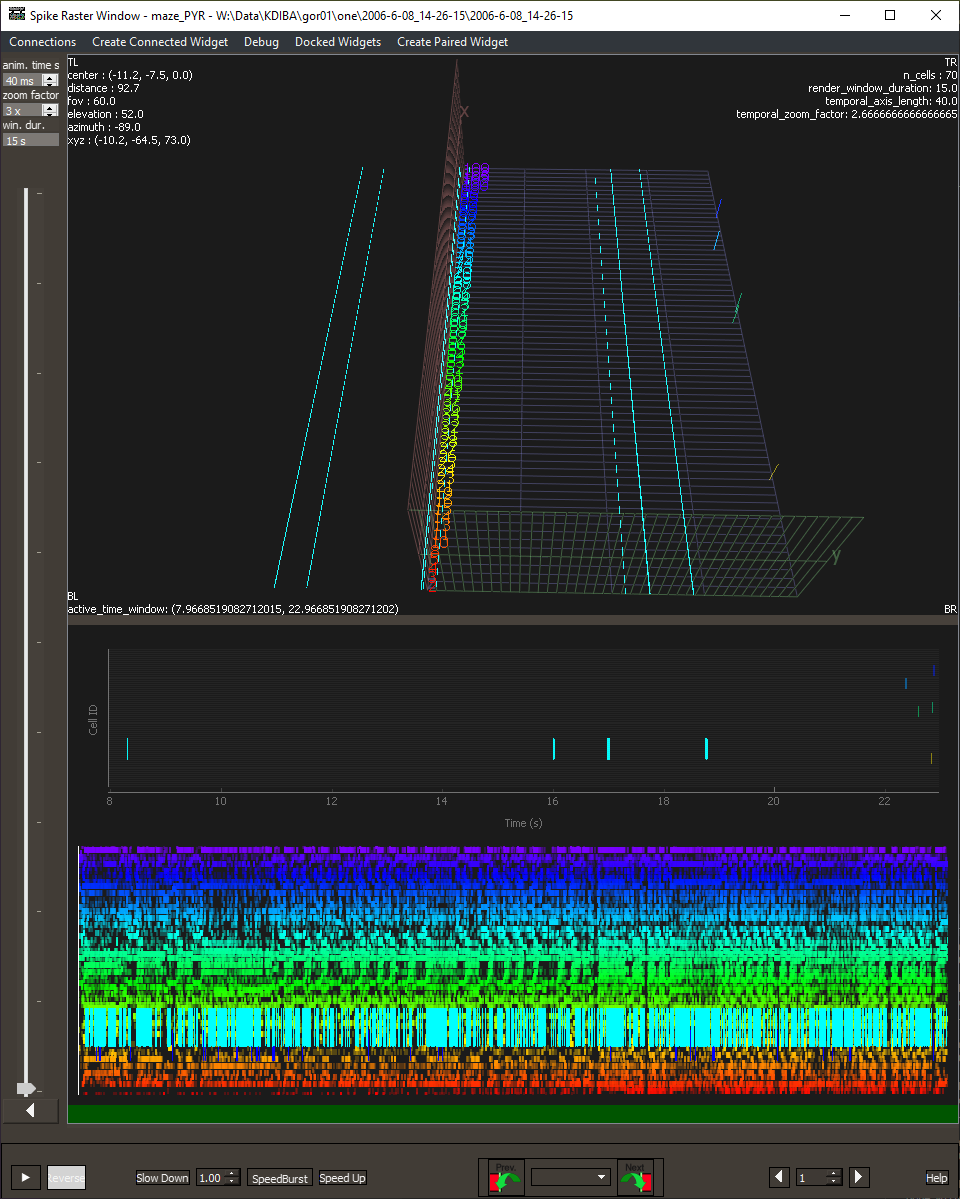
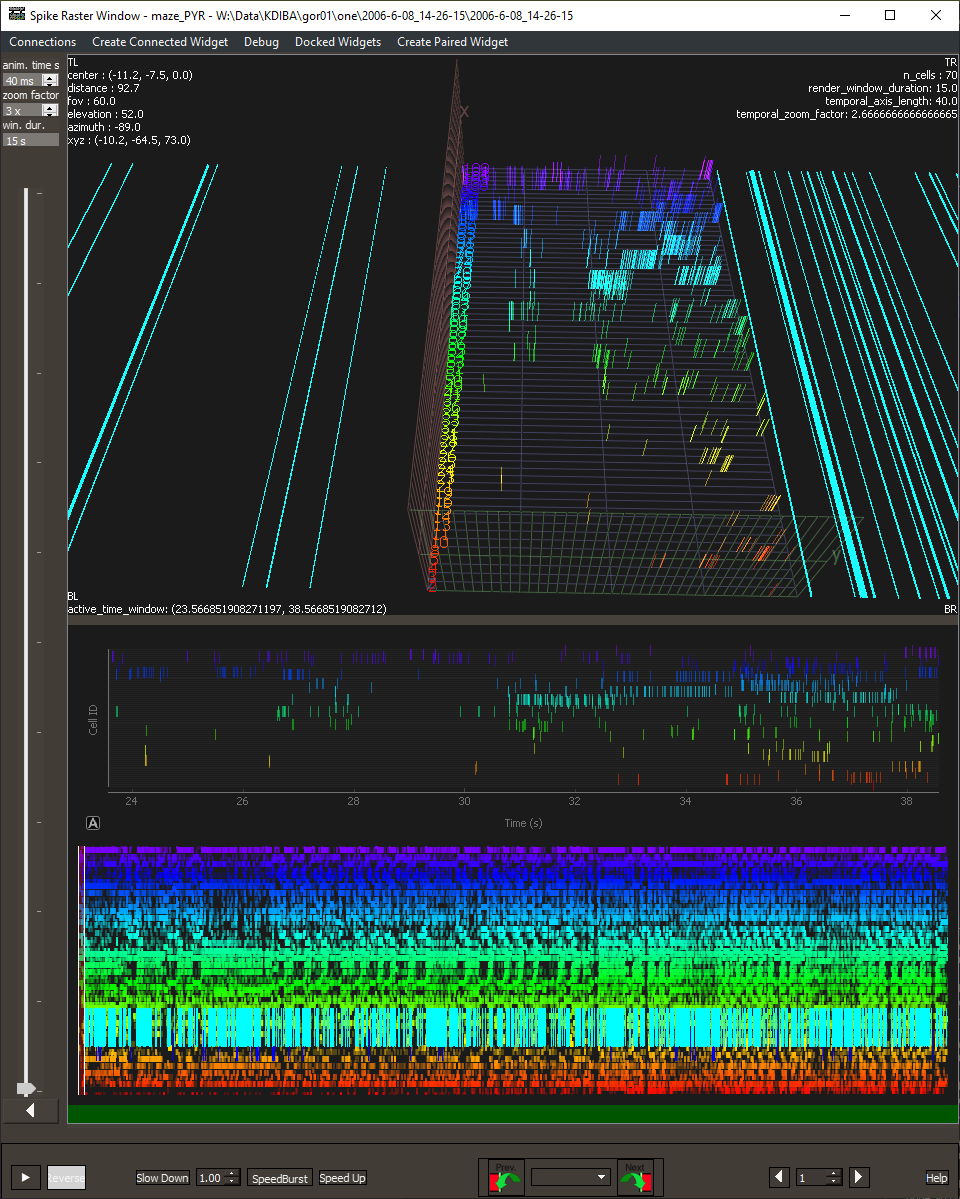

# ◽📣 Rectangle Epoch Documentation Guide

IntervalsDatasource

C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Model\Datasources\IntervalDatasource.py

C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\GUI\PyQtPlot\Widgets\Mixins\RenderTimeEpochs\EpochRenderingMixin.py
C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\GUI\PyQtPlot\Widgets\Mixins\RenderTimeEpochs\RenderTimeEpoch3DMeshesMixin.py
C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\GUI\PyQtPlot\Widgets\Mixins\RenderTimeEpochs\Render2DEventRectanglesHelper.py

C:\Users\pho\repos\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\GUI\PyQtPlot\Widgets\Mixins\RenderTimeEpochs\Specific2DRenderTimeEpochs.py



## ◽📣 ✅ Testing 2D Rectangle Epochs on Raster Plot

In [ ]:
laps_interval_datasource = Specific2DRenderTimeEpochsHelper.build_Laps_render_time_epochs_datasource(curr_sess=sess, series_vertical_offset=max_series_top, series_height=1.0) # series_vertical_offset=42.0
new_PBEs_interval_datasource = Specific2DRenderTimeEpochsHelper.build_PBEs_render_time_epochs_datasource(curr_sess=sess, series_vertical_offset=(max_series_top+1.0), series_height=3.0) # new_PBEs_interval_datasource

## General Adding:
active_2d_plot.add_rendered_intervals(new_PBEs_interval_datasource, name='PBEs', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)
active_2d_plot.add_rendered_intervals(laps_interval_datasource, name='Laps', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)

In [ ]:
active_2d_plot.add_laps_intervals(sess)

In [ ]:
active_2d_plot.remove_laps_intervals()

In [ ]:
# active_2d_plot.add_PBEs_intervals(sess)

In [ ]:
active_2d_plot.interval_rendering_plots

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

## ◽📣 Test Updating Custom Epochs

In [ ]:
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
active_2d_plot.interval_rendering_plots

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs

# Need to deal with pg.mkPen(a_pen_color) and pg.mkBrush
def build_custom_epochs_dataframe_formatter(cls, **kwargs):
    def _add_interval_dataframe_visualization_columns_general_epoch(active_df):
        """ Adds the remaining _required_interval_visualization_columns specifically for PBEs
        """
        num_intervals = np.shape(active_df)[0]
        ## parameters:
        y_location = 0.0
        height = 20.5
        pen_color = pg.mkColor('w')
        pen_color.setAlphaF(0.8)

        brush_color = pg.mkColor('grey')
        brush_color.setAlphaF(0.5)

        ## Update the dataframe's visualization columns:
        active_df = cls._update_df_visualization_columns(active_df, y_location=y_location, height=height, pen_color=pen_color, brush_color=brush_color, **kwargs)
        return active_df
    return _add_interval_dataframe_visualization_columns_general_epoch

interval_datasource = Ripples_2DRenderTimeEpochs.build_render_time_epochs_datasource(sess.laps.as_epoch_obj(), epochs_dataframe_formatter=build_custom_epochs_dataframe_formatter) # **({'series_vertical_offset': 42.0, 'series_height': 1.0} | kwargs)
spike_raster_window.spike_raster_plt_2d.add_rendered_intervals(interval_datasource, name='CustomRipples', debug_print=False) # removes the rendered intervals

## ◽📣 Get list of existing interval rect datasources:
blah blah

In [ ]:
# Plot items:
active_2d_plot.interval_rendering_plots

In [ ]:
# active_2d_plot.interval_datasources.new_ripples
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

In [ ]:
active_2d_plot.interval_datasources # RenderPlotsData
# datasource_to_update

In [ ]:
active_2d_plot.interval_datasources.PBEs # IntervalsDatasource

## ◽📣 Update existing interval rects:
Write a function that takes your existing datasource dataframe and updates its columns.

### Before Update:
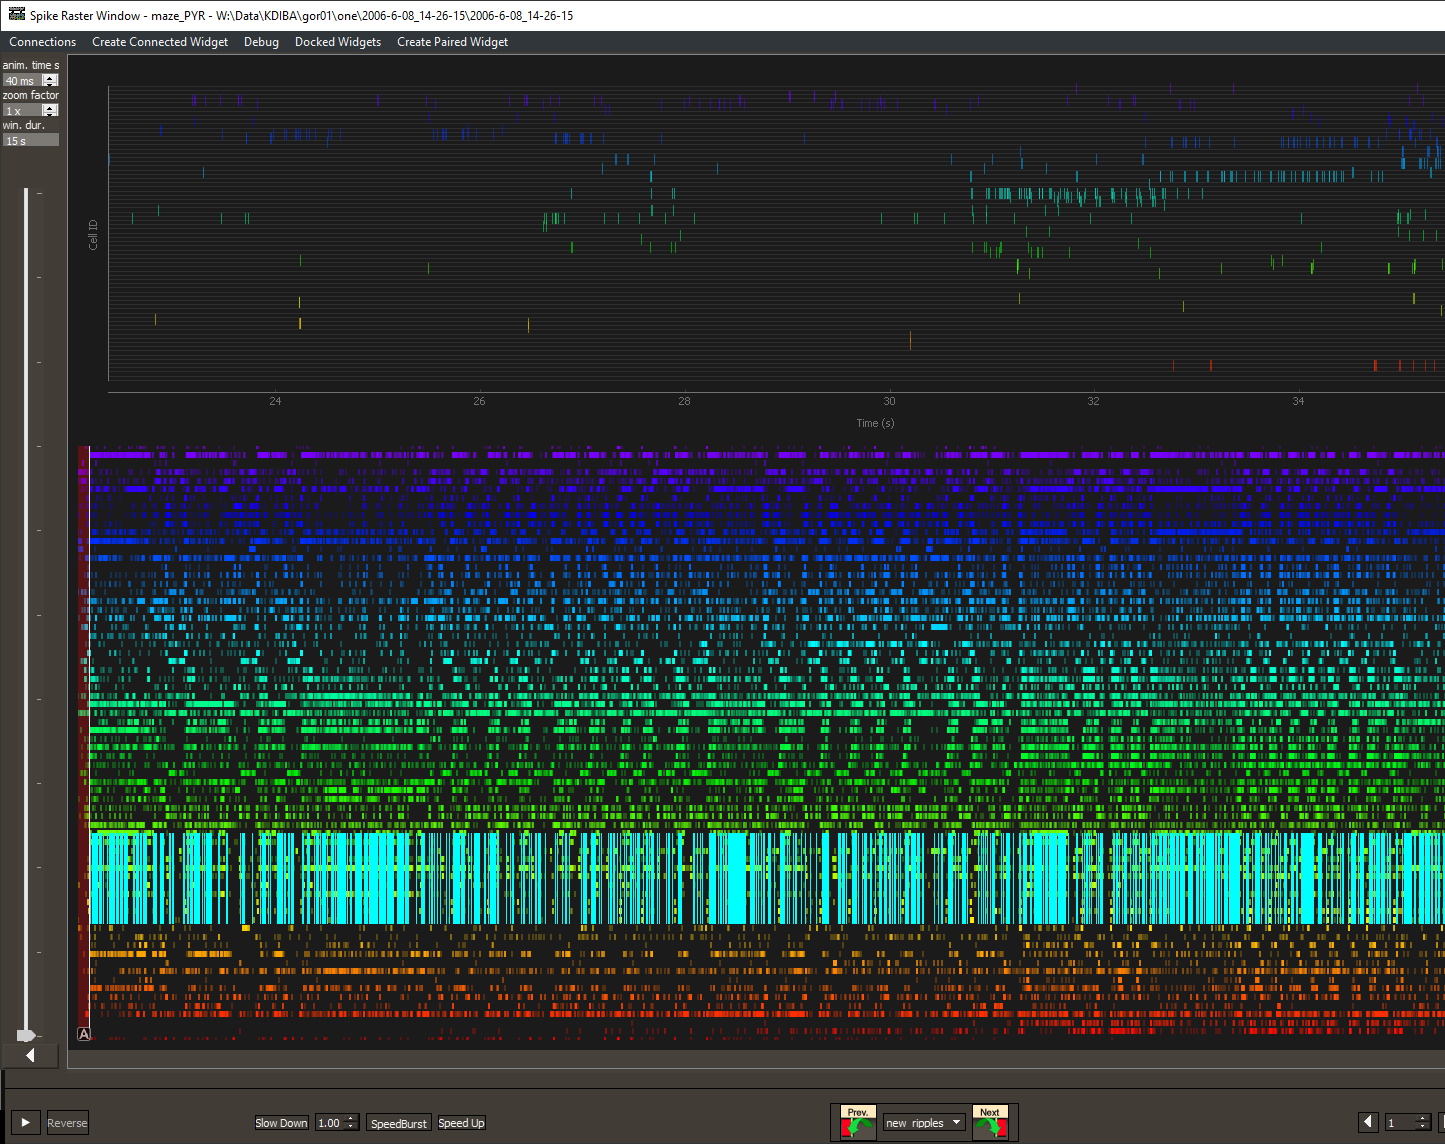

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs
# series_vertical_offset, series_height, pen, brush

def _updated_custom_interval_dataframe_visualization_columns_general_epoch(active_df, **kwargs):
    """ Adds the remaining _required_interval_visualization_columns specifically for PBEs
    """
    num_intervals = np.shape(active_df)[0]
    ## parameters:
    y_location = 0.0
    height = 30.5
    pen_color = pg.mkColor('grey')
    pen_color.setAlphaF(0.8)

    brush_color = pg.mkColor('grey')
    brush_color.setAlphaF(0.5)

    ## Update the dataframe's visualization columns:
    active_df = General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=y_location, height=height, pen_color=pen_color, brush_color=brush_color, **kwargs)
    return active_df

# get the existing dataframe to be updated:
# datasource_to_update = active_2d_plot.interval_datasources.Ripples
datasource_to_update = active_2d_plot.interval_datasources.new_ripples
# datasource_to_update = active_2d_plot.interval_datasources.CustomRipples
datasource_to_update.update_visualization_properties(_updated_custom_interval_dataframe_visualization_columns_general_epoch)

### Post Update:
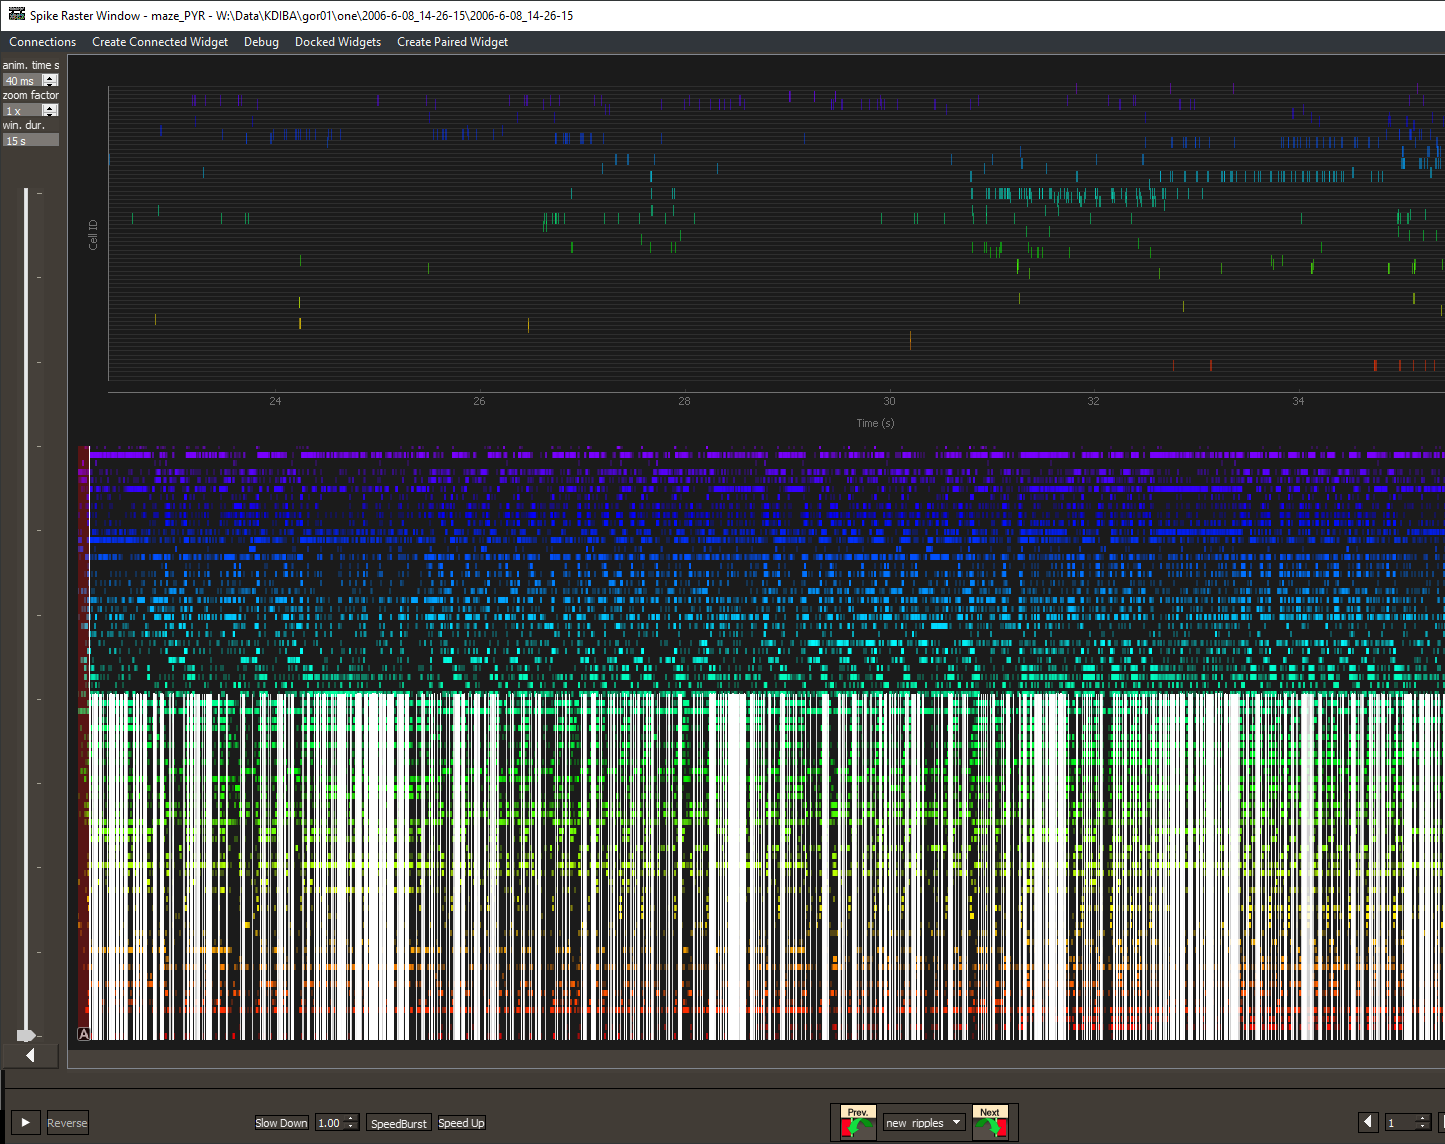

In [ ]:
datasource_to_update.custom_datasource_name

In [ ]:
datasource_to_update.df

In [ ]:
spike_raster_window.spike_raster_plt_2d.add_rendered_intervals(datasource_to_update, name='CustomRipples', debug_print=True) # removes the rendered intervals

# `matplotview` testing

In [ ]:
from neuropy.core import Epoch
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, SessionEpochs2DRenderTimeEpochs, PBE_2DRenderTimeEpochs, Laps2DRenderTimeEpochs, Replays_2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import NewRipples_2DRenderTimeEpochs
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
# from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from neuropy.utils.efficient_interval_search import _searchsorted_find_event_interval_indicies

## Continuous prediction probabilities (for a single shank):
shank_id = 2
ripple_predictions_df, (prediction_timesteps, prediction_values) = _build_cnn_computed_ripple_prediction_probabilities(loaded_ripple_detector, shank_id=shank_id)
# ripple_predictions_df
print(f'np.shape(prediction_timesteps): {np.shape(prediction_timesteps)}')
found_start_end_indicies = _searchsorted_find_event_interval_indicies(prediction_timesteps, epoch_slices)
# found_start_indicies = found_start_end_indicies[:,0]
# found_end_indicies = found_start_end_indicies[:,1]
# found_start_end_indicies #.shape # (2, 6016)
global_all_epoch = [np.nanmin(prediction_timesteps), np.nanmax(prediction_timesteps)]
print(f'global_all_epoch: {global_all_epoch}')

## Out Ripples
new_ripple_df = loaded_ripple_detector.ripple_df.copy() #.sort_values(by=['start'])
num_ripples = np.shape(new_ripple_df)[0]
print(f'num_ripples: {num_ripples}')

# new_ripple_df

## Add the global_all_epoch as the first epoch
# new_ripple_df = new_ripple_df.append(pd.DataFrame({'start': [global_all_epoch[0]], 'stop': [global_all_epoch[1]]}), ignore_index=True)
new_ripple_df = new_ripple_df.sort_values(by=['start'])
num_slices = np.shape(new_ripple_df)[0]
print(f'num_slices: {num_slices}')


epoch_slices = new_ripple_df[['start','stop']].to_numpy()
print(f'np.shape(epoch_slices): {np.shape(epoch_slices)}')

In [ ]:
ripple_predictions_df

In [ ]:
new_ripple_df

In [ ]:

# , override_time_variable_name=override_time_variable_name
debug_print = True



In [ ]:
found_start_end_indicies
range(0, 10)
i = 0
np.arange(found_start_end_indicies[i,0], found_start_end_indicies[i,1]+1, 1)

In [ ]:
found_start_end_indicies[0] # array([266, 268], dtype=int64)



In [ ]:
prediction_timesteps, prediction_values

In [ ]:
found_start_indicies = found_start_end_indicies[:,0]
found_end_indicies = found_start_end_indicies[:,1]

In [ ]:
## MATPLOTLIB Imports:
import matplotlib
# configure backend here
matplotlib.use('Qt5Agg')
# backend_qt5agg
# matplotlib.use('AGG') # non-interactive backend
# from matplotview import view
import matplotlib.pyplot as plt
# from matplotlib.patches import FancyArrowPatch
# from matplotlib_scalebar.scalebar import ScaleBar
# from matplotlib_scalebar.dimension import _Dimension, _PREFIXES_FACTORS, _LATEX_MU
from neuropy.utils.matplotlib_helpers import draw_sizebar


# class TimeDimension(_Dimension):
#     def __init__(self):
#         super().__init__("s")
#         for prefix, factor in _PREFIXES_FACTORS.items():
#             latexrepr = None
#             if prefix == "\u00b5" or prefix == "u":
#                 latexrepr = _LATEX_MU + "s"
#             self.add_units(prefix + "s", factor, latexrepr)

# plt.figure()
# plt.gca().add_artist(
#     ScaleBar(5, units="ms", dimension=TimeDimension(), location="lower right")
# )

# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm
# fontprops = fm.FontProperties(size=18)

from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_matplotlib_build_view
plot_function_name = 'New Ripples - Stacked Epoch Slices View - MATPLOTLIB subplots Version'
params, plots_data, plots, ui = stacked_epoch_slices_matplotlib_build_view(epoch_slices, name=f'stacked_epoch_slices_matplotlib_subplots_new_ripples: shank {shank_id}', plot_function_name=plot_function_name, debug_test_max_num_slices=24, debug_print=False)

global_all_data_ax = None
for i, curr_ax in enumerate(plots.axs):
    ## View version, doesn't work
    # if i==0:
    #     global_all_data_ax = curr_ax
    #     global_all_data_ax.plot(ripple_predictions_df.t.to_numpy(), ripple_predictions_df.v.to_numpy()) # , "-o"
    #     global_all_data_ax.set_title(f'global predicted ripple probability: shank {shank_id}')
    # else:
    #     # Create a view! Turn axes 2 into a view of axes 1.
    #     view(curr_ax, global_all_data_ax)
        
    curr_idx_range = np.arange(found_start_end_indicies[i,0], found_start_end_indicies[i,1]+1, 1)
    curr_timepoints = ripple_predictions_df.t.to_numpy()[curr_idx_range]
    # curr_ax.plot(curr_timepoints, ripple_predictions_df.v.to_numpy()[curr_idx_range], "-o")
    # curr_ax.plot(curr_timepoints, [ripple_predictions_df[col].to_numpy()[curr_idx_range] for col in ripple_predictions_df.columns[1:]]) # , "-o"
    # curr_ax.plot(curr_timepoints, *[ripple_predictions_df[col].to_numpy()[curr_idx_range] for col in ripple_predictions_df.columns[1:]])
    for col in ripple_predictions_df.columns[1:]:
        curr_ax.plot(curr_timepoints, ripple_predictions_df[col].to_numpy()[curr_idx_range])
    
    curr_ax.set_xlim(*plots_data.epoch_slices[i,:])
    curr_ax.set_ylim([0.0, 1.0])
    # Create scale bar
    # scalebar = ScaleBar(1.0, "ms", dimension=TimeDimension(), location="lower right")
    # scalebar = ScaleBar(1.0, "ms", dimension=TimeDimension(), location="lower right", fixed_value=1.0, fixed_units='sec')

    _scale_bar_duration = 0.001 # 1ms
    _temp_end_t = curr_timepoints[-1]
    # offset by about one 0.1 of the frame
    curr_duration = curr_timepoints[-1] - curr_timepoints[0]
    print(f'curr_duration: {curr_duration} [sec]')
    _scale_end_t = _temp_end_t - (0.1 * curr_duration)
    _scale_start_t = _scale_end_t - _scale_bar_duration
    _scale_center_t = _scale_start_t + (curr_duration/2.0)
    # patch = FancyArrowPatch(
    #     (_scale_start_t, 0.9), (_scale_end_t, 0.9), arrowstyle="|-|,widthA=3,widthB=3", zorder=7, lw=1.5
    # )
    # curr_ax.add_patch(patch)
    # curr_ax.annotate('1ms', xy=(_scale_center_t, 0.8),  xycoords='data',
    #         # xytext=(0.8, 0.95), textcoords='axes fraction',
    #         # arrowprops=dict(facecolor='black', shrink=0.05),
    #         horizontalalignment='center', verticalalignment='center'
    #         )
    curr_ax.text(_scale_center_t, 0.8, '1ms', horizontalalignment='center', verticalalignment='center', transform=curr_ax.transAxes)
#     scalebar = AnchoredSizeBar(curr_ax.transData,
#                            1, '1 sec', 'lower center', 
#                            pad=0.1,
#                            color='white',
#                            frameon=False,
#                            size_vertical=1,
#                            fontproperties=fontprops)

#     # scalebar = draw_sizebar(
#     curr_ax.add_artist(scalebar)



In [ ]:
# ## Global main plot (doesn't work)
# fig_global, main_ax = plt.subplots()
# # fig_global, (main_ax) = plt.subplots(1, 1)

# Plot a line in the first axes.
main_ax.plot(ripple_predictions_df.t.to_numpy(), ripple_predictions_df.v.to_numpy(), "-o")
main_ax.set_title(f'global predicted ripple probability: shank {shank_id}')

# # Create a view! Turn axes 2 into a view of axes 1.
# view(ax2, ax1)

# # Modify the second axes data limits so we get a slightly zoomed out view
# ax2.set_xlim(-5, 15)
# ax2.set_ylim(-5, 15)

# fig_global.show()

In [ ]:
plots.fig.show()

In [ ]:
# laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
# laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]

# epochs = sess.laps.to_dataframe()
# epoch_slices = epochs[['start', 'stop']].to_numpy()
# epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]
# print(f'epoch_description_list: {epoch_description_list}')


from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_slices_view

stacked_epoch_slices_view_laps_containers = stacked_epoch_slices_view(epoch_slices, laps_position_times_list, laps_position_traces_list, name=f'stacked_epoch_slices_view_new_ripples: shank {shank_id}')
params, plots_data, plots, ui = stacked_epoch_slices_view_laps_containers

# 2022-11-08 Jonathan-Pho Analyses

In [ ]:
%matplotlib qt
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import _final_compute_jonathan_replay_fr_analyses
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import _make_jonathan_interactive_plot

owning_pipeline_reference = curr_active_pipeline
include_whitelist = None
computation_results = curr_active_pipeline.computation_results

neuron_IDs = np.unique(computation_results['maze_PYR'].sess.spikes_df.aclu)
neuron_IDXs = np.arange(len(neuron_IDs))
instantaneous_unit_specific_spike_rate = computation_results['maze_PYR']['computed_data']['firing_rate_trends'].all_session_spikes.instantaneous_unit_specific_spike_rate
instantaneous_unit_specific_spike_rate_values = pd.DataFrame(instantaneous_unit_specific_spike_rate.magnitude, columns=neuron_IDs) # builds a df with times along the rows and aclu values along the columns in the style of unit_specific_binned_spike_counts

In [ ]:
instantaneous_unit_specific_spike_rate.times.magnitude.shape # (3429,)

In [ ]:
instantaneous_unit_specific_spike_rate[:,0].shape # (3429, 1)

In [ ]:
instantaneous_unit_specific_spike_rate.magnitude.shape # (3429, 71)

In [ ]:
replays_df = owning_pipeline_reference.sess.pbe.to_dataframe()
replays_df

In [ ]:
sess.neuron_ids.shape

In [ ]:
active_session_spikes_df = computation_result.sess.spikes_df.copy()

In [ ]:
neuron_IDs.shape

In [ ]:
neuron_IDs = pf.ratemap.neuron_ids


In [ ]:
active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate

In [ ]:
if include_whitelist is None:
    include_whitelist = owning_pipeline_reference.active_completed_computation_result_names # ['maze', 'sprinkle']

long_epoch_name = include_whitelist[0] # 'maze1_PYR'
short_epoch_name = include_whitelist[1] # 'maze2_PYR'
if len(include_whitelist) > 2:
    global_epoch_name = include_whitelist[-1] # 'maze_PYR'

print(f'include_whitelist: {include_whitelist}\nlong_epoch_name: {long_epoch_name}, short_epoch_name: {short_epoch_name}, global_epoch_name: {global_epoch_name}')
pf1d_long = computation_results[long_epoch_name]['computed_data']['pf1D']
pf1d_short = computation_results[short_epoch_name]['computed_data']['pf1D']

try:
    active_firing_rate_trends = computation_results[global_epoch_name]['computed_data']['firing_rate_trends']
    instantaneous_unit_specific_spike_rate = active_firing_rate_trends.all_session_spikes.instantaneous_unit_specific_spike_rate
    
    time_bins = instantaneous_unit_specific_spike_rate.times.magnitude # .shape (3429,)
    time_binned_unit_specific_binned_spike_rate = instantaneous_unit_specific_spike_rate_values # .shape (3429, 71)
    
    # active_unique_aclu_values = np.unique(active_aclu_binned_time_multiindex.get_level_values('aclu'))
    
    
    # active_firing_rate_trends = computation_results[global_epoch_name]['computed_data']['firing_rate_trends']
    # time_bins = active_firing_rate_trends.all_session_spikes.time_binning_container.centers
    # time_binned_unit_specific_binned_spike_rate = active_firing_rate_trends.all_session_spikes.time_binned_unit_specific_binned_spike_rate

except KeyError:
    # except ValueError:
    time_bins, time_binned_unit_specific_binned_spike_rate = {}, {}

# ## Compute for all the session spikes first:
sess = owning_pipeline_reference.sess
# BAD DOn'T DO THIS:
# replays_df = sess.replay
replays_df = sess.pbe.to_dataframe()
rdf, aclu_to_idx, irdf, aclu_to_idx_irdf = _final_compute_jonathan_replay_fr_analyses(sess, replays_df)
pos_df = sess.position.to_dataframe()

## TODO: This is the proper way once global computations work:
# aclu_to_idx = computation_result.computed_data['jonathan_firing_rate_analysis']['rdf']['aclu_to_idx']
# rdf = computation_result.computed_data['jonathan_firing_rate_analysis']['rdf']['rdf'],
# irdf = computation_result.computed_data['jonathan_firing_rate_analysis']['irdf']['irdf']
# pos_df = computation_result.sess.position.to_dataframe()
# compare_firing_rates(rdf, irdf)

In [ ]:
graphics_output_dict, neuron_df = _make_jonathan_interactive_plot(sess, time_bins, time_binned_unit_specific_binned_spike_rate, pf1d_short, pf1d_long, pos_df, aclu_to_idx, rdf, irdf, show_inter_replay_frs=False)
# output_dict = {'fig': fig, 'axs': ax, 'colors': colors}
graphics_output_dict['plot_data'] = {'df': neuron_df, 'rdf':rdf, 'aclu_to_idx':aclu_to_idx, 'irdf':irdf}

In [ ]:
rdf